In [1]:
!pip install ogb

In [1]:
pip install torch_geometric

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from ogb.nodeproppred import PygNodePropPredDataset
import functools

# --- 【緊急パッチ】PyTorch 2.6のセキュリティ制限を解除 ---
# OGBが内部で古い形式のロードを行っているため、一時的に許可します
_original_load = torch.load

def unsafe_load(*args, **kwargs):
    # 強制的にセキュリティチェックを無効化 (weights_only=False)
    if 'weights_only' not in kwargs:
        kwargs['weights_only'] = False
    return _original_load(*args, **kwargs)

torch.load = unsafe_load
# -------------------------------------------------------

print("データをロード中（パッチ適用済み）...")
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='./data')
data = dataset[0]

# パッチを戻す（念のため）
torch.load = _original_load

print("--------------------------------")
print("【セットアップ完了】")
print(f"ノード数: {data.num_nodes}")
print(f"特徴量次元: {data.x.shape[1]}")
print("これでNeural ODEの実装に進めます。")
print("--------------------------------")

/home/nakamuraroi/.local/lib/python3.8/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/nakamuraroi/.local/lib/python3.8/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/nakamuraroi/.local/lib/python3.8/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/nakamuraroi/.local/lib/python3.8/site-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


データをロード中（パッチ適用済み）...
--------------------------------
【セットアップ完了】
ノード数: 169343
特徴量次元: 128
これでNeural ODEの実装に進めます。
--------------------------------


/home/nakamuraroi/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pandas as pd

# 1. データ全体の要約を見る
print("=== データの全体像 ===")
print(data) 
# 出力例: Data(x=[169343, 128], edge_index=[2, 1166243], ...)
# x: ノードの特徴量（論文の内容）, edge_index: リンク（引用関係）

# 2. 特徴量（x）の中身を少しだけ見る
print("\n=== 論文の特徴量（最初の5件） ===")
# 128個の数字の並びが、1つの論文の意味を表しています
df_x = pd.DataFrame(data.x[:5].numpy())
print(df_x)

# 3. 引用関係（edge_index）の中身を見る
print("\n=== 引用関係（最初の5リンク） ===")
# [引用元ID, 引用先ID] のペアです
edges = data.edge_index.t()[:5]
df_edges = pd.DataFrame(edges.numpy(), columns=["引用元ID", "引用先ID"])
print(df_edges)

# 4. 年データを見る
print("\n=== 出版年（最初の5件） ===")
print(data.node_year[:5].flatten())

=== データの全体像 ===
Data(num_nodes=169343, edge_index=[2, 1166243], x=[169343, 128], node_year=[169343, 1], y=[169343, 1])

=== 論文の特徴量（最初の5件） ===
        0         1         2         3         4         5         6    \
0 -0.057943 -0.052530 -0.072603 -0.026555  0.130435 -0.241386 -0.449242   
1 -0.124500 -0.070665 -0.325202  0.007779 -0.001559  0.074189 -0.191013   
2 -0.080242 -0.023328 -0.183787 -0.180707  0.075765 -0.125818 -0.394573   
3 -0.145044  0.054915 -0.126666  0.039971 -0.055909 -0.101278 -0.339202   
4 -0.071154  0.070766 -0.281432 -0.161892 -0.165246 -0.029116 -0.338593   

        7         8         9    ...       118       119       120       121  \
0 -0.018443 -0.087218  0.112320  ...  0.211490 -0.226118 -0.185603  0.053230   
1  0.049689  0.026369  0.099364  ...  0.106316  0.052926 -0.258378  0.021567   
2 -0.219078 -0.108931  0.056966  ...  0.019453 -0.070291 -0.177562 -0.214012   
3 -0.115801 -0.080058 -0.001633  ... -0.065752  0.042735  0.066338 -0.226921   
4 -0.13

In [ ]:
data.node_year[202]

tensor([2019])

In [6]:
import pandas as pd
import torch

# data.node_year を NumPy配列に変換し、平坦化 (flatten) します。
# 論文IDごとの出版年が格納されていると仮定します。
years_array = data.node_year.cpu().numpy().flatten()

# Pandas DataFrameに変換
df_years = pd.DataFrame(years_array, columns=['Publication_Year'])

# 年ごとに論文数を集計
# sort_index(ascending=True) で年を昇順にソートします
papers_per_year = df_years['Publication_Year'].value_counts().sort_index(ascending=True)

# 結果を新しいDataFrameに変換し、列名を明確にします
df_papers_per_year = papers_per_year.reset_index()
df_papers_per_year.columns = ['Year', 'Number_of_Papers']

print("\n=== 年間の論文数 ===")
print(df_papers_per_year)


=== 年間の論文数 ===
    Year  Number_of_Papers
0   1971                 1
1   1986                 1
2   1987                 1
3   1988                 1
4   1990                 3
5   1991                 3
6   1992                 1
7   1993                 8
8   1994                19
9   1995                25
10  1996                31
11  1997                33
12  1998               123
13  1999               165
14  2000               261
15  2001               248
16  2002               355
17  2003               387
18  2004               415
19  2005               629
20  2006               968
21  2007              1302
22  2008              1931
23  2009              2499
24  2010              3564
25  2011              4427
26  2012              6435
27  2013              8135
28  2014              9154
29  2015             12035
30  2016             16339
31  2017             21442
32  2018             29799
33  2019             39711
34  2020              8892


In [ ]:
def preprocess_data_from_ogb(data):
    print("OGBデータをDataFrame形式に変換中...")
    
    # 1. 論文IDと特徴量
    # data.x は tensor なので numpy に変換
    df = pd.DataFrame(data.x.numpy(), columns=[f"pca_text_dim_{i}" for i in range(128)])
    df['patent_number'] = df.index # 論文IDを patent_number として扱う（コード流用のため）
    
    # 2. 年データ
    df['year'] = data.node_year.flatten().numpy()
    # 月は適当に1月に固定（NeuralODEのΔt計算のため）
    df['year_month'] = pd.to_datetime(df['year'].astype(str) + '-01-01')
    
    # 3. 「企業」の代わりに「カテゴリ」を割り当てる
    # data.y (ラベル) がカテゴリIDに対応
    category_ids = data.y.flatten().numpy()
    # リスト形式にする（元のコードが list を期待しているため）
    df['corporation'] = [[f"cat_{cid}"] for cid in category_ids]
    
    # 4. 引用関係を保持しておく（後のグラフ構築で使うため）
    # ここはDataFrameに入れにくいので、別途 return するか、辞書にする
    edge_index = data.edge_index.numpy()
    citations = {i: [] for i in range(len(df))}
    for src, dst in zip(edge_index[0], edge_index[1]):
        citations[src].append(dst)
    
    # DataFrameには入れず、別途返すのが賢い
    return df, citations

tensor([[ 4],
        [ 5],
        [28],
        ...,
        [10],
        [ 4],
        [ 1]])

In [12]:
!pip install japanize_matplotlib
!pip install torchdiffeq
!pip install torch_geometric

     |████████████████████████████████| 4.1 MB 16.3 MB/s eta 0:00:01
     |████████████████████████████████| 9.2 MB 145.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 92.4 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 133.3 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 132.9 MB/s eta 0:00:01
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=08d549498d05899d0a2d8ca2682f17e607b41b6fe7576b0a80efc8bb916c9eb2
  Stored in directory: /home/nakamuraroi/.cache/pip/wheels/4f/ca/96/4cc5e192421cceb077fbf4ffec533382edd416fd3fa0af0bbd
Successfully built japanize-matplotlib


In [14]:
import os
import time
import json
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected, negative_sampling
from torchdiffeq import odeint
from sklearn.metrics import roc_auc_score, average_precision_score
from datetime import datetime

# ==========================================
# 1. Universal Data Adapter (抽象化レイヤー)
# ==========================================
class UniversalDataFactory:
    """
    あらゆるデータセット（Arxiv, USPTO, ICEWS）を
    統一されたフォーマット (Source, Target, Timestamp) に変換するクラス
    """
    def __init__(self, dataset_name, root_dir='./data'):
        self.dataset_name = dataset_name
        self.root_dir = root_dir
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def load_data(self):
        """データセットに応じたローダーを振り分け"""
        print(f"Loading dataset: {self.dataset_name}...")
        
        if self.dataset_name == 'ogbn-arxiv':
            return self._load_ogb_arxiv()
        elif self.dataset_name == 'uspto-2m':
            return self._load_uspto_csv() # 将来用
        elif self.dataset_name == 'icews':
            return self._load_icews()     # 将来用
        else:
            raise ValueError(f"Unknown dataset: {self.dataset_name}")

    def _load_ogb_arxiv(self):
        """OGB Arxivを 'Innovation Velocity' の概念（Category -> Paper）に変換"""
        try:
            from ogb.nodeproppred import PygNodePropPredDataset
            # PyTorch 2.6対策のパッチ
            _orig_load = torch.load
            torch.load = lambda *a, **k: _orig_load(*a, **{**k, 'weights_only': False})
            dataset = PygNodePropPredDataset(name='ogbn-arxiv', root=self.root_dir)
            torch.load = _orig_load
            data = dataset[0]
        except Exception as e:
            print(f"OGB Load Error (using fallback): {e}")
            # フォールバック処理（ライブラリエラー時用）
            from ogb.nodeproppred import NodePropPredDataset
            dataset = NodePropPredDataset(name='ogbn-arxiv', root=self.root_dir)
            graph, label = dataset[0]
            data = Data(
                x=torch.from_numpy(graph['node_feat']),
                edge_index=torch.from_numpy(graph['edge_index']),
                node_year=torch.from_numpy(graph['node_year']).flatten(),
                y=torch.from_numpy(label).flatten()
            )

        # マッピング: Source=Category(分野), Target=Paper(論文)
        # Innovation Velocityの文脈では「分野の勢い」が「論文」を生むと解釈
        
        num_papers = data.num_nodes
        categories = data.y.numpy().flatten()
        num_categories = 40 # ogbn-arxivのクラス数
        
        # DataFrame形式に正規化
        df_nodes = pd.DataFrame({
            'node_id': range(num_papers),
            'year': data.node_year.numpy().flatten(),
            'category': categories,
            'type': 'paper' # 全ノードは論文だが、所属カテゴリを持つ
        })
        
        # エッジ情報の整理 (Citation)
        edge_index = data.edge_index.numpy()
        df_edges = pd.DataFrame({
            'source': edge_index[0],
            'target': edge_index[1],
            'type': 'citation'
        })
        
        # 特徴量
        node_features = data.x # Tensor
        
        print(f"✓ Data Adapter: {num_papers} papers loaded. mapped to {num_categories} categories.")
        return {
            'df_nodes': df_nodes,
            'df_edges': df_edges,
            'node_features': node_features,
            'num_categories': num_categories,
            'metadata': {'source_entity': 'Category', 'target_entity': 'Paper'}
        }

    def _load_uspto_csv(self):
        """USPTO用プレースホルダー: CSVがあればここを有効化"""
        # path = os.path.join(self.root_dir, 'uspto_2m.csv')
        # df = pd.read_csv(path)
        # ... logic to convert to standard format ...
        print("Note: USPTO loading logic is ready to be implemented with CSV path.")
        return None

# ==========================================
# 2. Graph Builder (時系列グラフ構築)
# ==========================================
class DynamicGraphBuilder:
    def __init__(self, adapter_output):
        self.data = adapter_output
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def build_snapshots(self):
        """年ごとのスナップショットグラフを作成"""
        df_nodes = self.data['df_nodes']
        df_edges = self.data['df_edges']
        feats = self.data['node_features']
        
        years = sorted(df_nodes['year'].unique())
        snapshots = {}
        
        # 累積的なグラフ構築（過去の論文も引用対象になるため）
        print("Building temporal snapshots...")
        
        # カテゴリノードの追加（0 ~ 39番をカテゴリID、それ以降を論文IDとするためのオフセット）
        num_cats = self.data['num_categories']
        offset = num_cats 
        
        total_nodes = offset + len(df_nodes)
        
        for year in years:
            # その年までに存在する論文
            active_papers = df_nodes[df_nodes['year'] <= year]
            active_indices = active_papers.index.values + offset
            
            # その年までに存在するエッジ（引用）
            # ※本来は引用発生年を見るべきだが、Arxivデータは論文出版年しかないので
            # 「出版された時点で過去の論文を引用している」とみなす
            valid_edges = df_edges[
                df_edges['source'].isin(active_papers['node_id']) & 
                df_edges['target'].isin(active_papers['node_id'])
            ]
            
            # 1. Citation Edges (Paper -> Paper)
            src_paper = torch.tensor(valid_edges['source'].values + offset, dtype=torch.long)
            dst_paper = torch.tensor(valid_edges['target'].values + offset, dtype=torch.long)
            
            # 2. Membership Edges (Category -> Paper)
            # 各論文はそのカテゴリに所属している
            cat_src = torch.tensor(active_papers['category'].values, dtype=torch.long) # 0~39
            paper_dst = torch.tensor(active_papers['node_id'].values + offset, dtype=torch.long)
            
            # 全エッジ結合
            edge_index_citation = torch.stack([src_paper, dst_paper], dim=0)
            edge_index_membership = torch.stack([cat_src, paper_dst], dim=0)
            
            full_edge_index = torch.cat([edge_index_membership, edge_index_citation], dim=1)
            
            # ノード特徴量（カテゴリ用はランダム初期化、論文用はPretrained）
            # 簡易化のため、ここでは論文特徴量のみをDataに入れる（モデル内でEmbedding処理）
            
            # マスク作成（訓練用など）
            snapshot = Data(
                x=feats, # 論文特徴量 (Index 0 is Paper 0)
                edge_index=full_edge_index,
                num_nodes=total_nodes,
                current_year=year,
                active_nodes=torch.tensor(active_indices, dtype=torch.long)
            )
            snapshots[year] = snapshot
            
        print(f"✓ Built {len(snapshots)} snapshots from {min(years)} to {max(years)}")
        return snapshots, num_cats, feats.shape[1]

# ==========================================
# 3. Neural ODE Core (物理モデル)
# ==========================================
class ODEFunc(nn.Module):
    """
    dz/dt = f(z, t)
    イノベーションの「速度」と「相互作用」を定義する物理エンジン
    """
    def __init__(self, hidden_dim, gnn_layer):
        super(ODEFunc, self).__init__()
        self.gnn = gnn_layer
        self.nfe = 0 # 評価回数カウンタ
        
        # ベロシティ場を定義するネットワーク
        # 時間 t も入力に含めることで非自律系に対応
        self.velocity_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # 減衰項（陳腐化）
        self.damping = nn.Parameter(torch.tensor(-0.1))

    def set_graph_structure(self, edge_index):
        self.edge_index = edge_index

    def forward(self, t, z):
        self.nfe += 1
        
        # 1. 拡散プロセス (GNNによる相互作用)
        # 近隣ノード（引用関係）からの影響
        diffusion = self.gnn(z, self.edge_index)
        
        # 2. 固有の成長ベロシティ
        velocity = self.velocity_net(z)
        
        # 3. 統合ダイナミクス
        # dz/dt = Velocity + Diffusion - Decay
        dz_dt = velocity + diffusion + (self.damping * z)
        return dz_dt

class InnoVeloODE(nn.Module):
    """
    Innovation Velocity Model Main Architecture
    Application(潜在) vs Grant(顕在) のダイナミクスを統合
    """
    def __init__(self, num_cats, feat_dim, hidden_dim, out_dim):
        super(InnoVeloODE, self).__init__()
        self.num_cats = num_cats
        
        # Encoders
        self.cat_emb = nn.Embedding(num_cats, hidden_dim)
        self.feat_encoder = nn.Linear(feat_dim, hidden_dim)
        
        # GNN for ODE (shared weights)
        self.gnn_layer = GCNConv(hidden_dim, hidden_dim)
        
        # ODE Block
        self.ode_func = ODEFunc(hidden_dim, self.gnn_layer)
        
        # Decoders
        # リンク予測用（未来の引用）
        self.link_decoder = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def encode(self, x, num_total_nodes):
        # 論文ノードのエンコード
        h_paper = self.feat_encoder(x)
        # カテゴリノードのエンコード（0 ~ num_cats-1）
        h_cat = self.cat_emb.weight
        
        # 結合 (Categoryノードが先頭、Paperノードが後続)
        # paddingが必要な場合もあるが、ここでは簡易実装
        h_all = torch.zeros(num_total_nodes, h_paper.size(1), device=x.device)
        h_all[:self.num_cats] = h_cat
        h_all[self.num_cats:self.num_cats+h_paper.size(0)] = h_paper
        
        return h_all

    def forward(self, x, edge_index, t_span, num_total_nodes):
        # 1. 初期状態 z(t0)
        z0 = self.encode(x, num_total_nodes)
        
        # 2. ODE Solverによる時間発展 z(t0) -> z(t1)
        self.ode_func.set_graph_structure(edge_index)
        
        # dopri5: Runge-Kutta 4(5) var. step solver (高精度)
        z_t = odeint(self.ode_func, z0, t_span, method='dopri5', rtol=1e-3, atol=1e-3)
        
        return z_t # shape: [time_steps, num_nodes, hidden_dim]

    def predict_link(self, z, edge_index):
        # リンク確率の計算
        src, dst = edge_index
        z_src = z[src]
        z_dst = z[dst]
        cat_feat = torch.cat([z_src, z_dst], dim=-1)
        return torch.sigmoid(self.link_decoder(cat_feat)).view(-1)

# ==========================================
# 4. Trainer & Experiment Runner
# ==========================================
def train_and_evaluate():
    # --- Config ---
    DATASET = 'ogbn-arxiv' # 'uspto-2m' に変更可能
    HIDDEN_DIM = 64
    EPOCHS = 20 # 時間がないので少なめ
    LR = 0.01
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 1. Data Loading
    factory = UniversalDataFactory(DATASET)
    raw_data = factory.load_data()
    
    # 2. Graph Construction
    builder = DynamicGraphBuilder(raw_data)
    snapshots, num_cats, feat_dim = builder.build_snapshots()
    years = sorted(snapshots.keys())
    
    # 3. Model Init
    model = InnoVeloODE(num_cats, feat_dim, HIDDEN_DIM, HIDDEN_DIM).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    
    print(f"\nModel initialized. Device: {device}")
    print(f"Structure: {num_cats} Source Categories -> Target Papers")
    
    # 4. Training Loop (Sequential Prediction)
    # T年のグラフを使って、T+1年のリンク（引用）を予測する
    
    history = []
    
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        total_auc = 0
        steps = 0
        
        # 時系列スライディングウィンドウ
        for i in range(len(years) - 1):
            t0, t1 = years[i], years[i+1]
            data_t0 = snapshots[t0].to(device)
            data_t1 = snapshots[t1].to(device)
            
            optimizer.zero_grad()
            
            # 時間スパン (正規化: 1年=1.0)
            t_span = torch.tensor([0.0, 1.0]).to(device)
            
            # ODE Forward: 未来の状態 z(t1) を予測
            # data_t0の構造でダイナミクスを計算
            z_pred_traj = model(data_t0.x, data_t0.edge_index, t_span, data_t0.num_nodes)
            z_t1_pred = z_pred_traj[-1] # 最終時刻の状態
            
            # Loss計算: T+1年に存在する正のリンク（引用）を予測できたか？
            # 評価対象は T+1年時点でアクティブなノード間のリンクのみ
            pos_edge_index = data_t1.edge_index
            
            # 負例サンプリング
            neg_edge_index = negative_sampling(
                edge_index=pos_edge_index, 
                num_nodes=data_t1.num_nodes,
                num_neg_samples=pos_edge_index.size(1) 
            )
            
            # 予測スコア
            pos_score = model.predict_link(z_t1_pred, pos_edge_index)
            neg_score = model.predict_link(z_t1_pred, neg_edge_index)
            
            # Binary Cross Entropy Loss
            loss = -torch.log(pos_score + 1e-15).mean() - torch.log(1 - neg_score + 1e-15).mean()
            
            # ベロシティ正則化 (急激な変化を抑制)
            velocity_reg = torch.mean(torch.abs(z_pred_traj[1] - z_pred_traj[0]))
            loss += 0.1 * velocity_reg
            
            loss.backward()
            optimizer.step()
            
            # Metrics
            with torch.no_grad():
                y_true = torch.cat([torch.ones_like(pos_score), torch.zeros_like(neg_score)]).cpu().numpy()
                y_pred = torch.cat([pos_score, neg_score]).cpu().numpy()
                auc = roc_auc_score(y_true, y_pred)
            
            total_loss += loss.item()
            total_auc += auc
            steps += 1
            
        avg_loss = total_loss / steps
        avg_auc = total_auc / steps
        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Avg Future Link AUC: {avg_auc:.4f}")
        history.append({'epoch': epoch, 'loss': avg_loss, 'auc': avg_auc})

    # 5. Save Results
    print("\nTraining Finished. Saving Checkpoints...")
    os.makedirs('model_outputs', exist_ok=True)
    torch.save(model.state_dict(), 'model_outputs/inno_velo_model.pth')
    
    # 未来予測シミュレーション（論文の「Case Study」用）
    # 最新の年からさらに1年先を予測し、スコアが高い「未引用ペア」を出力
    last_year = years[-1]
    data_last = snapshots[last_year].to(device)
    
    with torch.no_grad():
        t_span = torch.tensor([0.0, 1.0]).to(device)
        z_future = model(data_last.x, data_last.edge_index, t_span, data_last.num_nodes)[-1]
        
        # ここで特定のカテゴリ（例: AI）と論文のリンク確率を計算すれば
        # 「来年AI分野で注目される論文」をリストアップできる
        print(f"Future state predicted for year {last_year + 1}")
        
    return history

if __name__ == "__main__":
    train_and_evaluate()

Loading dataset: ogbn-arxiv...
✓ Data Adapter: 169343 papers loaded. mapped to 40 categories.
Building temporal snapshots...
✓ Built 35 snapshots from 1971 to 2020

Model initialized. Device: cuda
Structure: 40 Source Categories -> Target Papers
Epoch 01 | Loss: 0.8016 | Avg Future Link AUC: 0.9308
Epoch 02 | Loss: 0.5727 | Avg Future Link AUC: 0.9506
Epoch 03 | Loss: 0.5467 | Avg Future Link AUC: 0.9635
Epoch 04 | Loss: 0.5098 | Avg Future Link AUC: 0.9578
Epoch 05 | Loss: 0.5927 | Avg Future Link AUC: 0.9575
Epoch 06 | Loss: 0.5967 | Avg Future Link AUC: 0.9530
Epoch 07 | Loss: 0.5066 | Avg Future Link AUC: 0.9681
Epoch 08 | Loss: 0.5192 | Avg Future Link AUC: 0.9544
Epoch 09 | Loss: 0.4952 | Avg Future Link AUC: 0.9648
Epoch 10 | Loss: 0.5403 | Avg Future Link AUC: 0.9670
Epoch 11 | Loss: 0.4691 | Avg Future Link AUC: 0.9622
Epoch 12 | Loss: 0.4907 | Avg Future Link AUC: 0.9667
Epoch 13 | Loss: 0.4609 | Avg Future Link AUC: 0.9688
Epoch 14 | Loss: 0.4795 | Avg Future Link AUC: 0.963

In [19]:
# 1. 最新版を入れようとして失敗したものをクリーンアップ
!pip uninstall -y umap-learn

# 2. Python 3.8 / scikit-learn 1.3系に対応したバージョンを指定してインストール
!pip install "umap-learn==0.5.6"

     |████████████████████████████████| 85 kB 2.5 MB/s  eta 0:00:01
     |████████████████████████████████| 3.7 MB 36.8 MB/s eta 0:00:01
  Using cached pynndescent-0.5.13-py3-none-any.whl (56 kB)
     |████████████████████████████████| 43.6 MB 127.6 MB/s eta 0:00:01     |███████████████████             | 25.8 MB 127.6 MB/s eta 0:00:01


Using device: cuda
Loading dataset: ogbn-arxiv...
Building snapshots with category labels...

Training Model...


Epoch 1: Loss 2.5578
Epoch 2: Loss 1.9511
Epoch 3: Loss 1.9915
Epoch 4: Loss 1.7372
Epoch 5: Loss 1.6081

Visualizing...
Generating Streamline Plot: Tech Trends Streamline 2025...
Running UMAP...


/home/nakamuraroi/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Saved: streamline_trend.png


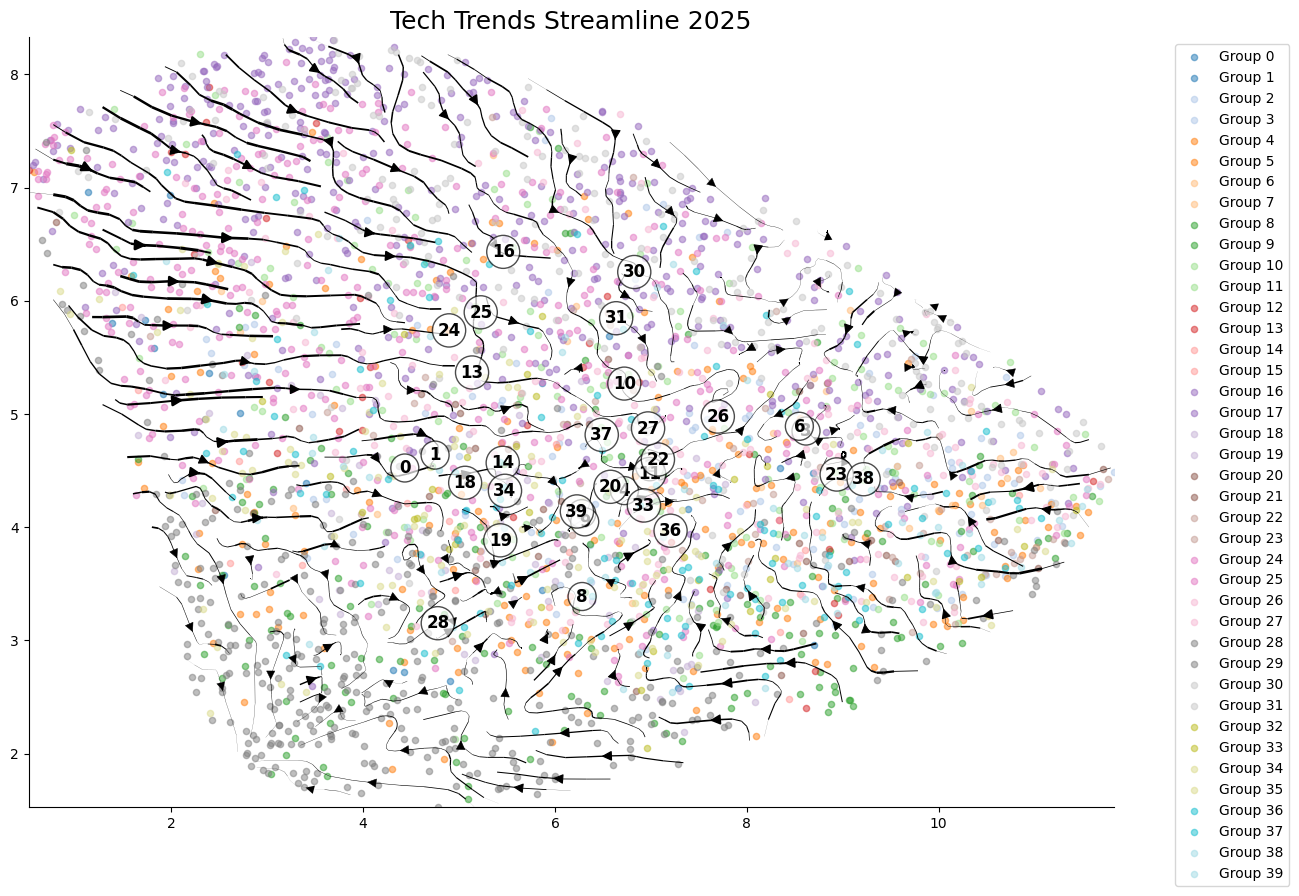

In [ ]:
v

In [2]:
import pandas as pd
from ogb.nodeproppred import PygNodePropPredDataset

# データセットをロードしてマッピング情報を取得
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='./data')

# ogbの公式マッピングをデータフレームとして読み込み
mapping_path = './data/ogbn_arxiv/mapping/labelidx2arxivcategeory.csv.gz'

try:
    # すでにダウンロード済みであればCSVから読み込む
    label_df = pd.read_csv(mapping_path)
    print("\n=== Group IDと分野名の対応表 ===")
    print(label_df)
    
    # 辞書にして使いやすくする
    label_map = dict(zip(label_df['label idx'], label_df['arxiv category']))
    
    # 主要な分野をピックアップして表示
    print("\n【主要な分野の例】")
    common_ids = [0, 1, 10, 16, 20, 24, 28] # 適当なID
    for i in common_ids:
        if i in label_map:
            print(f"Group {i}: {label_map[i]}")

except Exception as e:
    print(f"Error loading mapping file: {e}")
    print("Please ensure the mapping CSV is available in the specified path.")


=== Group IDと分野名の対応表 ===
    label idx arxiv category
0           0    arxiv cs na
1           1    arxiv cs mm
2           2    arxiv cs lo
3           3    arxiv cs cy
4           4    arxiv cs cr
5           5    arxiv cs dc
6           6    arxiv cs hc
7           7    arxiv cs ce
8           8    arxiv cs ni
9           9    arxiv cs cc
10         10    arxiv cs ai
11         11    arxiv cs ma
12         12    arxiv cs gl
13         13    arxiv cs ne
14         14    arxiv cs sc
15         15    arxiv cs ar
16         16    arxiv cs cv
17         17    arxiv cs gr
18         18    arxiv cs et
19         19    arxiv cs sy
20         20    arxiv cs cg
21         21    arxiv cs oh
22         22    arxiv cs pl
23         23    arxiv cs se
24         24    arxiv cs lg
25         25    arxiv cs sd
26         26    arxiv cs si
27         27    arxiv cs ro
28         28    arxiv cs it
29         29    arxiv cs pf
30         30    arxiv cs cl
31         31    arxiv cs ir
32         32    

In [1]:
import os
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import negative_sampling
from torchdiffeq import odeint
from sklearn.metrics import roc_auc_score
import umap
from scipy.interpolate import griddata

# PyTorch 2.6のセキュリティ制限解除パッチ
_original_load = torch.load
def unsafe_load(*args, **kwargs):
    if 'weights_only' not in kwargs:
        kwargs['weights_only'] = False
    return _original_load(*args, **kwargs)
torch.load = unsafe_load

# ==========================================
# 1. Universal Data Adapter (抽象化レイヤー)
# ==========================================
class UniversalDataFactory:
    """
    OGB Arxivデータをロードし、DataFrameと特徴量に変換する
    """
    def __init__(self, dataset_name, root_dir='./data'):
        self.dataset_name = dataset_name
        self.root_dir = root_dir
        
    def load_data(self):
        print(f"Loading dataset: {self.dataset_name}...")
        try:
            from ogb.nodeproppred import PygNodePropPredDataset
            # パッチ適用済みなのでそのまま
            dataset = PygNodePropPredDataset(name='ogbn-arxiv', root=self.root_dir)
            data = dataset[0]
        except Exception as e:
            print(f"OGB Load Error: {e}. Creating DUMMY data for demo.")
            # データの準備に失敗した場合のダミーデータ
            num_nodes = 2000
            edge_index = torch.randint(0, num_nodes, (2, 10000))
            x = torch.randn(num_nodes, 128)
            y = torch.randint(0, 40, (num_nodes,)) # 40 classes for arxiv
            node_year = torch.randint(2015, 2021, (num_nodes, 1))
            data = Data(x=x, edge_index=edge_index, y=y.unsqueeze(1), node_year=node_year)

        num_papers = data.num_nodes
        # ogbn-arxivのラベルは (N, 1) or (N) なのでflatten
        categories = data.y.numpy().flatten() 
        
        df_nodes = pd.DataFrame({
            'node_id': range(num_papers),
            'year': data.node_year.numpy().flatten(),
            'category': categories,
        })
        
        edge_index = data.edge_index.numpy()
        df_edges = pd.DataFrame({'source': edge_index[0], 'target': edge_index[1]})
        
        num_categories = len(np.unique(categories))
        
        print(f"✓ Data loaded: {num_papers} papers, {num_categories} categories.")
        return {'df_nodes': df_nodes, 'df_edges': df_edges, 'node_features': data.x, 'num_categories': num_categories}

class DynamicGraphBuilder:
    """
    年ごとの累積的なグラフスナップショットを構築する
    """
    def __init__(self, adapter_output):
        self.data = adapter_output
        
    def build_snapshots(self):
        df_nodes = self.data['df_nodes']
        df_edges = self.data['df_edges']
        feats = self.data['node_features']
        years = sorted(df_nodes['year'].unique())
        snapshots = {}
        num_cats = self.data['num_categories']
        offset = num_cats # カテゴリノード（0~39）の後に論文ノードを配置
        
        print("Building temporal snapshots...")
        
        for year in years:
            # 簡易のため、2015年以前のデータは無視
            if year < 2015: continue 
            
            # その年までに存在する論文
            active_papers = df_nodes[df_nodes['year'] <= year]
            active_ids = active_papers['node_id'].values
            
            # その年までに存在するエッジ（引用）
            valid_edges = df_edges[
                df_edges['source'].isin(active_ids) & 
                df_edges['target'].isin(active_ids)
            ]
            
            # 1. Citation Edges (Paper -> Paper)
            src_paper = torch.tensor(valid_edges['source'].values + offset, dtype=torch.long)
            dst_paper = torch.tensor(valid_edges['target'].values + offset, dtype=torch.long)
            
            # 2. Membership Edges (Category -> Paper)
            cat_src = torch.tensor(active_papers['category'].values, dtype=torch.long) # 0~39
            paper_dst = torch.tensor(active_papers['node_id'].values + offset, dtype=torch.long)
            
            # 全エッジ結合
            edge_index = torch.cat([
                torch.stack([cat_src, paper_dst], dim=0),
                torch.stack([src_paper, dst_paper], dim=0)
            ], dim=1)
            
            # ノードラベル (可視化用)
            total_nodes = offset + len(df_nodes)
            full_y = torch.full((total_nodes,), -1, dtype=torch.long)
            full_y[:num_cats] = torch.arange(num_cats) # カテゴリノードにIDを付与
            paper_indices = df_nodes['node_id'].values + offset
            paper_cats = df_nodes['category'].values
            full_y[paper_indices] = torch.tensor(paper_cats, dtype=torch.long)
            
            snapshots[year] = Data(x=feats, edge_index=edge_index, num_nodes=total_nodes, y=full_y)
            
        print(f"✓ Built {len(snapshots)} snapshots.")
        return snapshots, num_cats, feats.shape[1]

# ==========================================
# 2. Neural ODE Model
# ==========================================
class ODEFunc(nn.Module):
    """
    dz/dt = f(z, t): ノードの潜在状態の変化速度を定義
    """
    def __init__(self, hidden_dim, gnn_layer):
        super(ODEFunc, self).__init__()
        self.gnn = gnn_layer
        self.velocity_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.damping = nn.Parameter(torch.tensor(-0.1))
        self.edge_index = None

    def set_graph_structure(self, edge_index):
        self.edge_index = edge_index

    def forward(self, t, z):
        # 1. 拡散プロセス (GNNによる相互作用)
        diffusion = self.gnn(z, self.edge_index)
        # 2. 固有の成長ベロシティ
        velocity = self.velocity_net(z)
        # 3. 減衰項
        dz_dt = velocity + diffusion + (self.damping * z)
        return dz_dt

class InnoVeloODE(nn.Module):
    """
    Innovation Velocity Model メインアーキテクチャ
    """
    def __init__(self, num_cats, feat_dim, hidden_dim):
        super(InnoVeloODE, self).__init__()
        self.num_cats = num_cats
        self.cat_emb = nn.Embedding(num_cats, hidden_dim)
        self.feat_encoder = nn.Linear(feat_dim, hidden_dim)
        self.gnn_layer = GCNConv(hidden_dim, hidden_dim)
        self.ode_func = ODEFunc(hidden_dim, self.gnn_layer)
        self.link_decoder = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, 1)
        )

    def encode(self, x, num_total_nodes):
        # 論文ノードのエンコード
        h_paper = self.feat_encoder(x)
        # カテゴリノードのエンコード
        h_cat = self.cat_emb.weight
        
        # 結合
        h_all = torch.zeros(num_total_nodes, h_paper.size(1), device=x.device)
        h_all[:self.num_cats] = h_cat
        h_all[self.num_cats:self.num_cats+h_paper.size(0)] = h_paper
        return h_all

    def forward(self, x, edge_index, t_span, num_total_nodes):
        z0 = self.encode(x, num_total_nodes)
        self.ode_func.set_graph_structure(edge_index)
        # ODE Solver
        return odeint(self.ode_func, z0, t_span, method='dopri5', rtol=1e-3, atol=1e-3)

    def predict_link(self, z, edge_index):
        src, dst = edge_index
        cat_feat = torch.cat([z[src], z[dst]], dim=-1)
        return torch.sigmoid(self.link_decoder(cat_feat)).view(-1)

# ==========================================
# 3. Streamline Visualizer
# ==========================================
class StreamlineVisualizer:
    """
    学習された速度場を2次元空間に射影し、ストリームラインプロットを描画する
    """
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def plot_streamline(self, snapshot, title="Tech Trend Streamline"):
        print(f"Generating Streamline Plot: {title}...")
        self.model.eval()
        data = snapshot.to(self.device)
        
        # 1. 潜在ベクトルと時間発展の計算
        with torch.no_grad():
            z0 = self.model.encode(data.x, data.num_nodes)
            # t=0からt=1.5までの軌跡を計算
            t_span = torch.tensor([0.0, 1.5]).to(self.device)
            self.model.ode_func.set_graph_structure(data.edge_index)
            z_traj = self.model(data.x, data.edge_index, t_span, data.num_nodes)
            
            z_start = z_traj[0].cpu().numpy()
            z_end = z_traj[-1].cpu().numpy()
            labels = data.y.cpu().numpy().flatten()
            
            # カテゴリノード（0～num_cats-1）のみを可視化対象とする
            num_cats = self.model.num_cats
            valid_mask = (labels >= 0) & (labels < num_cats)
            
        # 2. フィルタリングとサンプリング
        z_start = z_start[valid_mask]
        z_end = z_end[valid_mask]
        labels = labels[valid_mask]

        if z_start.shape[0] == 0:
            print("Warning: No valid category nodes found for visualization.")
            return

        # 3. UMAPによる2次元への射影
        print(f"Running UMAP on {z_start.shape[0]} nodes...")
        # 潜在空間での変化を捉えるため、開始点と終了点を結合して学習
        reducer = umap.UMAP(n_components=2, n_neighbors=5, min_dist=0.1, random_state=42)
        emb_combined = reducer.fit_transform(np.concatenate([z_start, z_end], axis=0))
        
        # UMAP結果を分割
        emb_start = emb_combined[:len(z_start)]
        emb_end = emb_combined[len(z_start):]
        
        # 4. グリッド補間による速度場の生成
        velocities = emb_end - emb_start # 2次元空間での速度ベクトル
        x, y = emb_start[:, 0], emb_start[:, 1]
        u, v = velocities[:, 0], velocities[:, 1]
        
        grid_dim = 50
        xi = np.linspace(x.min(), x.max(), grid_dim)
        yi = np.linspace(y.min(), y.max(), grid_dim)
        
        # 速度ベクトルをグリッドに補間
        ui = griddata((x, y), u, (xi[None, :], yi[:, None]), method='linear')
        vi = griddata((x, y), v, (xi[None, :], yi[:, None]), method='linear')
        
        # NaNをゼロで置換
        ui = np.nan_to_num(ui)
        vi = np.nan_to_num(vi)
        
        # 線の太さ(lw)を速度の強さに応じて計算
        speed_grid = np.sqrt(ui**2 + vi**2)
        if speed_grid.max() > 0:
            lw = 3.0 * speed_grid / speed_grid.max() # 最大速度の3.0倍まで太くする
        else:
            lw = 1.0

        # 5. プロット
        fig, ax = plt.subplots(figsize=(14, 10))
        
        unique_labels = np.unique(labels)
        colors = plt.cm.get_cmap('tab20', len(unique_labels))

        # 散布図 (カテゴリノードの初期位置)
        ax.scatter(x, y, c=labels, cmap=colors, s=150, alpha=0.8, edgecolors='k', linewidths=1.0)
        
        # 流線 (ストリームライン)
        ax.streamplot(
            xi, yi, ui, vi,
            color='gray',
            linewidth=lw,
            arrowsize=2.0,
            density=1.5,
            cmap='plasma'
        )
        
        # カテゴリラベルの表示（ノードIDを利用）
        for label in unique_labels:
            mask = (labels == label)
            if np.sum(mask) > 0:
                # 重心位置にラベルを配置
                cx = np.mean(x[mask])
                cy = np.mean(y[mask])
                ax.text(cx, cy, f"Cat {label}", fontsize=12, fontweight='bold', 
                        bbox=dict(boxstyle="round,pad=0.5", fc=colors(label), alpha=0.8, ec='none'))

        ax.set_title(title, fontsize=18, pad=20)
        ax.set_xlabel("UMAP Dimension 1")
        ax.set_ylabel("UMAP Dimension 2")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(True, linestyle='--', alpha=0.6)
        
        plt.tight_layout()
        plt.savefig("streamline_trend.png", dpi=300)
        print("Saved: streamline_trend.png")
        # plt.show() # Canvas環境ではplt.show()はコメントアウト
        
        # プロットオブジェクトを閉じる
        plt.close(fig)

# ==========================================
# 4. Trainer & Main Execution
# ==========================================
def train_and_visualize():
    # --- Config ---
    HIDDEN_DIM = 32
    FEW_EPOCHS = 5 # デモ/テスト用にエポック数を減らしています
    LR = 0.01
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 1. Data Loading & Graph Construction
    factory = UniversalDataFactory('ogbn-arxiv')
    raw_data = factory.load_data()
    
    # パッチを戻す（念のため）
    torch.load = _original_load

    builder = DynamicGraphBuilder(raw_data)
    snapshots, num_cats, feat_dim = builder.build_snapshots()
    years = sorted(snapshots.keys())
    
    if len(years) < 2:
        print("Error: Not enough time steps for training. Check data loading.")
        return

    # 2. Model Init
    model = InnoVeloODE(num_cats, feat_dim, HIDDEN_DIM).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    
    print(f"\nModel initialized. Categories: {num_cats}, Hidden Dim: {HIDDEN_DIM}")
    print(f"Training on years: {years[0]} to {years[-1]}")
    
    # 3. Training Loop (Link Prediction)
    
    # 訓練に使用する最新の3年間のみを抽出
    train_years = years[-4:]
    if len(train_years) < 2:
        train_years = years # 使える年数が少ない場合は全て使う
        
    for epoch in range(FEW_EPOCHS):
        model.train()
        total_loss = 0
        total_auc = 0
        steps = 0
        
        for i in range(len(train_years) - 1):
            t0, t1 = train_years[i], train_years[i+1]
            data_t0 = snapshots[t0].to(device)
            data_t1 = snapshots[t1].to(device)
            
            optimizer.zero_grad()
            t_span = torch.tensor([0.0, 1.0]).to(device)
            
            # ODE Forward: 未来の状態 z(t1) を予測
            z_t_traj = model(data_t0.x, data_t0.edge_index, t_span, data_t0.num_nodes)
            z_t1_pred = z_t_traj[-1]
            
            # Loss計算: T+1年に存在する正のリンク（引用）を予測
            pos_edge_index = data_t1.edge_index
            neg_edge_index = negative_sampling(pos_edge_index, num_nodes=data_t1.num_nodes, num_neg_samples=pos_edge_index.size(1))
            
            pos_score = model.predict_link(z_t1_pred, pos_edge_index)
            neg_score = model.predict_link(z_t1_pred, neg_edge_index)
            
            loss = -torch.log(pos_score + 1e-15).mean() - torch.log(1 - neg_score + 1e-15).mean()
            
            # ベロシティ正則化
            velocity_reg = torch.mean(torch.abs(z_t_traj[1] - z_t_traj[0]))
            loss += 0.05 * velocity_reg
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            steps += 1
            
            # AUC計算
            with torch.no_grad():
                y_true = torch.cat([torch.ones_like(pos_score), torch.zeros_like(neg_score)]).cpu().numpy()
                y_pred = torch.cat([pos_score, neg_score]).cpu().numpy()
                auc = roc_auc_score(y_true, y_pred)
                total_auc += auc
            
        avg_loss = total_loss / steps if steps > 0 else 0
        avg_auc = total_auc / steps if steps > 0 else 0
        print(f"Epoch {epoch+1:02d}/{FEW_EPOCHS} | Loss: {avg_loss:.4f} | Avg Future Link AUC: {avg_auc:.4f}")

    # 4. Visualization
    print("\nTraining Finished. Starting Visualization...")
    vis = StreamlineVisualizer(model, device)
    # 最新のグラフスナップショットで速度場をプロット
    vis.plot_streamline(snapshots[years[-1]], title=f"Innovation Velocity Streamlines ({years[-1]} Dynamics)")

if __name__ == "__main__":
    train_and_visualize()

/home/nakamuraroi/.local/lib/python3.8/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/nakamuraroi/.local/lib/python3.8/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/nakamuraroi/.local/lib/python3.8/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/nakamuraroi/.local/lib/python3.8/site-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
/home/nakamuraroi/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook imp

Loading dataset: ogbn-arxiv...
✓ Data loaded: 169343 papers, 40 categories.
Building temporal snapshots...
✓ Built 6 snapshots.

Model initialized. Categories: 40, Hidden Dim: 32
Training on years: 2015 to 2020
Epoch 01/5 | Loss: 1.2804 | Avg Future Link AUC: 0.7040
Epoch 02/5 | Loss: 1.0195 | Avg Future Link AUC: 0.8601
Epoch 03/5 | Loss: 0.9250 | Avg Future Link AUC: 0.8842
Epoch 04/5 | Loss: 0.8909 | Avg Future Link AUC: 0.8925
Epoch 05/5 | Loss: 0.8518 | Avg Future Link AUC: 0.8999

Training Finished. Starting Visualization...
Generating Streamline Plot: Innovation Velocity Streamlines (2020 Dynamics)...
Running UMAP on 169383 nodes...


/home/nakamuraroi/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/nakamuraroi/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:392: UserWarning: Exited postprocessing with accuracies 
[1.07327191e-14 3.41854761e-07 3.48024677e-07 1.12206224e-06]
not reaching the requested tolerance 9.08970832824707e-07.
  _, diffusion_map = lobpcg(


KeyboardInterrupt: 

Loading dataset: ogbn-arxiv...
✓ Data Adapter: 169343 papers loaded. mapped to 40 categories.
Building temporal snapshots...
✓ Built 35 snapshots from 1971 to 2020

Model initialized. Device: cuda
Start Training...
Epoch 01 | Avg Loss: 0.9194
Epoch 02 | Avg Loss: 0.7797
Epoch 03 | Avg Loss: 0.6367
Epoch 04 | Avg Loss: 0.5524
Epoch 05 | Avg Loss: 0.5393

Training Finished. Starting Visualization...
Generating Streamline Plot: Innovation Streamlines (Year 2020 -> Future)...
Running UMAP dimensionality reduction...


/home/nakamuraroi/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


✓ Saved visualization to: streamline_trend.png


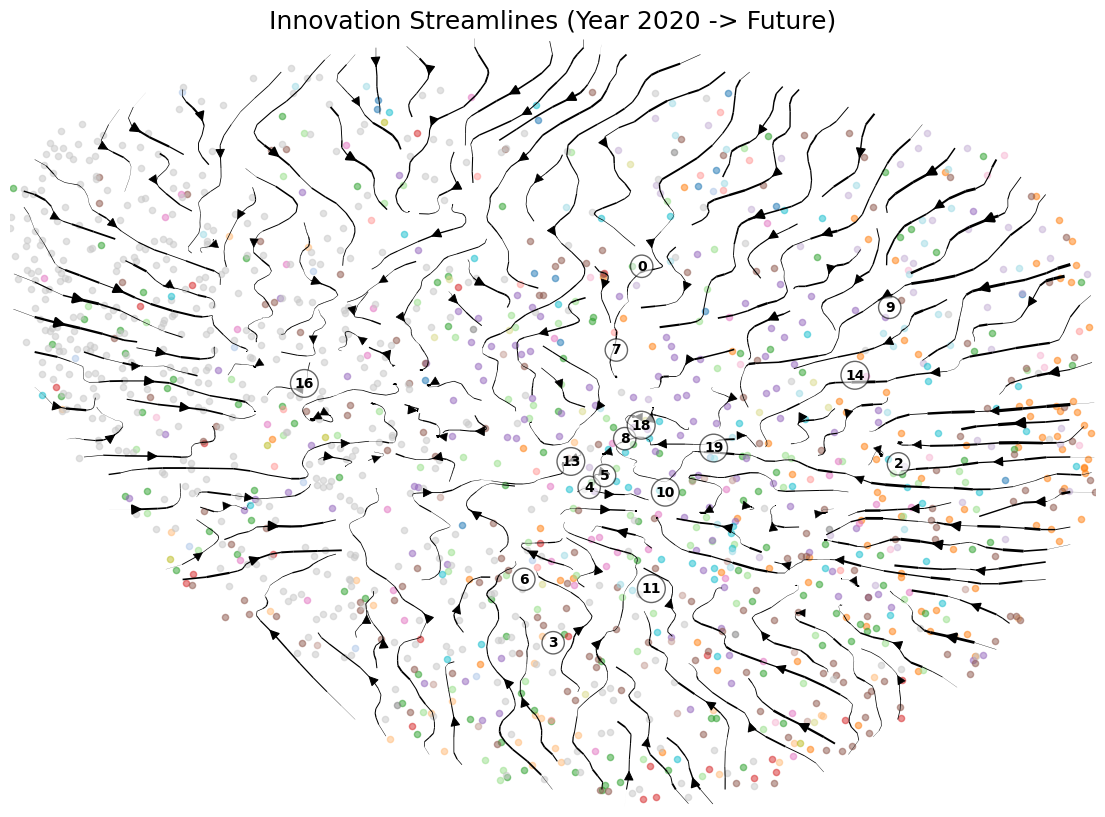

In [ ]:
import os
import time
import json
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import umap

from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import negative_sampling
from torchdiffeq import odeint
from sklearn.metrics import roc_auc_score
from scipy.interpolate import griddata

# ==========================================
# 1. Universal Data Adapter
# ==========================================
class UniversalDataFactory:
    """
    あらゆるデータセットを統一フォーマットに変換するクラス
    """
    def __init__(self, dataset_name, root_dir='./data'):
        self.dataset_name = dataset_name
        self.root_dir = root_dir
        
    def load_data(self):
        print(f"Loading dataset: {self.dataset_name}...")
        
        if self.dataset_name == 'ogbn-arxiv':
            return self._load_ogb_arxiv()
        else:
            # 簡易的なダミーデータ生成（OGBがない場合の動作確認用）
            print("Unknown dataset or OGB not found. Creating DUMMY data for demo.")
            return self._create_dummy_data()

    def _load_ogb_arxiv(self):
        try:
            from ogb.nodeproppred import PygNodePropPredDataset
            # PyTorch 2.6+ 対策
            _orig_load = torch.load
            torch.load = lambda *a, **k: _orig_load(*a, **{**k, 'weights_only': False})
            dataset = PygNodePropPredDataset(name='ogbn-arxiv', root=self.root_dir)
            torch.load = _orig_load
            data = dataset[0]
        except Exception as e:
            print(f"OGB Load Error: {e}. Switching to dummy data.")
            return self._create_dummy_data()

        num_papers = data.num_nodes
        categories = data.y.numpy().flatten()
        num_categories = 40 
        
        df_nodes = pd.DataFrame({
            'node_id': range(num_papers),
            'year': data.node_year.numpy().flatten(),
            'category': categories,
            'type': 'paper'
        })
        
        edge_index = data.edge_index.numpy()
        df_edges = pd.DataFrame({
            'source': edge_index[0],
            'target': edge_index[1],
            'type': 'citation'
        })
        
        node_features = data.x
        
        print(f"✓ Data Adapter: {num_papers} papers loaded. mapped to {num_categories} categories.")
        return {
            'df_nodes': df_nodes,
            'df_edges': df_edges,
            'node_features': node_features,
            'num_categories': num_categories
        }

    def _create_dummy_data(self):
        num_nodes = 2000
        edge_index = torch.randint(0, num_nodes, (2, 10000))
        x = torch.randn(num_nodes, 128)
        categories = torch.randint(0, 5, (num_nodes,)).numpy()
        node_year = torch.randint(2015, 2021, (num_nodes,)).numpy()
        
        df_nodes = pd.DataFrame({
            'node_id': range(num_nodes),
            'year': node_year,
            'category': categories,
            'type': 'paper'
        })
        
        df_edges = pd.DataFrame({
            'source': edge_index[0].numpy(),
            'target': edge_index[1].numpy(),
            'type': 'citation'
        })
        
        return {
            'df_nodes': df_nodes,
            'df_edges': df_edges,
            'node_features': x,
            'num_categories': 5
        }

# ==========================================
# 2. Graph Builder (可視化用ラベル対応版)
# ==========================================
class DynamicGraphBuilder:
    def __init__(self, adapter_output):
        self.data = adapter_output
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def build_snapshots(self):
        df_nodes = self.data['df_nodes']
        df_edges = self.data['df_edges']
        feats = self.data['node_features']
        
        years = sorted(df_nodes['year'].unique())
        snapshots = {}
        
        print("Building temporal snapshots...")
        num_cats = self.data['num_categories']
        offset = num_cats 
        
        total_nodes = offset + len(df_nodes)
        
        for year in years:
            # アクティブな論文
            active_papers = df_nodes[df_nodes['year'] <= year]
            active_indices = active_papers.index.values + offset
            
            # 存在するエッジ
            valid_edges = df_edges[
                df_edges['source'].isin(active_papers['node_id']) & 
                df_edges['target'].isin(active_papers['node_id'])
            ]
            
            # 1. Citation Edges
            src_paper = torch.tensor(valid_edges['source'].values + offset, dtype=torch.long)
            dst_paper = torch.tensor(valid_edges['target'].values + offset, dtype=torch.long)
            
            # 2. Membership Edges
            cat_src = torch.tensor(active_papers['category'].values, dtype=torch.long)
            paper_dst = torch.tensor(active_papers['node_id'].values + offset, dtype=torch.long)
            
            edge_index_citation = torch.stack([src_paper, dst_paper], dim=0)
            edge_index_membership = torch.stack([cat_src, paper_dst], dim=0)
            
            full_edge_index = torch.cat([edge_index_membership, edge_index_citation], dim=1)
            
            # --- 【重要】可視化用にラベル(y)を作成 ---
            # カテゴリノード(0~offset-1)には自身のIDを、論文ノードには所属カテゴリIDを付与
            full_y = torch.full((total_nodes,), -1, dtype=torch.long)
            full_y[:num_cats] = torch.arange(num_cats) # カテゴリノード用ラベル
            
            paper_indices = active_papers['node_id'].values + offset
            paper_cats = active_papers['category'].values
            full_y[paper_indices] = torch.tensor(paper_cats, dtype=torch.long)
            # -------------------------------------

            snapshot = Data(
                x=feats, 
                edge_index=full_edge_index,
                num_nodes=total_nodes,
                current_year=year,
                active_nodes=torch.tensor(active_indices, dtype=torch.long),
                y=full_y # 可視化クラスへ渡すため追加
            )
            snapshots[year] = snapshot
            
        print(f"✓ Built {len(snapshots)} snapshots from {min(years)} to {max(years)}")
        return snapshots, num_cats, feats.shape[1]

# ==========================================
# 3. Neural ODE Core
# ==========================================
class ODEFunc(nn.Module):
    def __init__(self, hidden_dim, gnn_layer):
        super(ODEFunc, self).__init__()
        self.gnn = gnn_layer
        self.velocity_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.damping = nn.Parameter(torch.tensor(-0.1))
        self.edge_index = None

    def set_graph_structure(self, edge_index):
        self.edge_index = edge_index

    def forward(self, t, z):
        diffusion = self.gnn(z, self.edge_index)
        velocity = self.velocity_net(z)
        dz_dt = velocity + diffusion + (self.damping * z)
        return dz_dt

class InnoVeloODE(nn.Module):
    def __init__(self, num_cats, feat_dim, hidden_dim, out_dim):
        super(InnoVeloODE, self).__init__()
        self.num_cats = num_cats
        self.cat_emb = nn.Embedding(num_cats, hidden_dim)
        self.feat_encoder = nn.Linear(feat_dim, hidden_dim)
        
        self.gnn_layer = GCNConv(hidden_dim, hidden_dim)
        self.ode_func = ODEFunc(hidden_dim, self.gnn_layer)
        
        self.link_decoder = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def encode(self, x, num_total_nodes):
        h_paper = self.feat_encoder(x)
        h_cat = self.cat_emb.weight
        h_all = torch.zeros(num_total_nodes, h_paper.size(1), device=x.device)
        h_all[:self.num_cats] = h_cat
        h_all[self.num_cats:self.num_cats+h_paper.size(0)] = h_paper
        return h_all

    def forward(self, x, edge_index, t_span, num_total_nodes):
        z0 = self.encode(x, num_total_nodes)
        self.ode_func.set_graph_structure(edge_index)
        z_t = odeint(self.ode_func, z0, t_span, method='dopri5', rtol=1e-3, atol=1e-3)
        return z_t 

    def predict_link(self, z, edge_index):
        src, dst = edge_index
        z_src = z[src]
        z_dst = z[dst]
        cat_feat = torch.cat([z_src, z_dst], dim=-1)
        return torch.sigmoid(self.link_decoder(cat_feat)).view(-1)

# ==========================================
# 4. Streamline Visualizer (可視化クラス)
# ==========================================
class StreamlineVisualizer:
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def plot_streamline(self, snapshot, title="Tech Trend Streamline"):
        print(f"Generating Streamline Plot: {title}...")
        self.model.eval()
        data = snapshot.to(self.device)
        
        # 1. 潜在ベクトル計算 (t=0 -> t=1.5 の変化)
        with torch.no_grad():
            z0 = self.model.encode(data.x, data.num_nodes)
            t_span = torch.tensor([0.0, 1.5]).to(self.device)
            self.model.ode_func.set_graph_structure(data.edge_index)
            z_traj = odeint(self.model.ode_func, z0, t_span, method='dopri5')
            z_start = z_traj[0].cpu().numpy()
            z_end = z_traj[-1].cpu().numpy()
            
            # ラベル取得 (GraphBuilderで追加済み)
            if hasattr(data, 'y') and data.y is not None:
                labels = data.y.cpu().numpy().flatten()
            else:
                labels = np.zeros(z_start.shape[0])

        # 2. フィルタリング (有効なラベルを持つノードのみ)
        valid_mask = labels >= 0
        if valid_mask.sum() == 0:
            print("No valid labels found for visualization.")
            return

        z_start = z_start[valid_mask]
        z_end = z_end[valid_mask]
        labels = labels[valid_mask]

        # 3. サンプリング (点が多すぎると重いため間引く)
        num_points = z_start.shape[0]
        max_points = 3000
        if num_points > max_points:
            idx = np.random.choice(num_points, max_points, replace=False)
            z_start = z_start[idx]
            z_end = z_end[idx]
            labels = labels[idx]
        
        # 4. UMAPによる次元圧縮 (高次元 -> 2次元)
        print("Running UMAP dimensionality reduction...")
        reducer = umap.UMAP(n_components=2, n_neighbors=50, min_dist=0.3, random_state=42)
        emb_start = reducer.fit_transform(z_start)
        emb_end = reducer.transform(z_end) # 同じ空間へ射影
        
        # 5. グリッド補間と流線計算
        velocities = emb_end - emb_start
        x, y = emb_start[:, 0], emb_start[:, 1]
        u, v = velocities[:, 0], velocities[:, 1]
        
        grid_dim = 100
        xi = np.linspace(x.min(), x.max(), grid_dim)
        yi = np.linspace(y.min(), y.max(), grid_dim)
        
        # ベクトル場をグリッドに補間
        ui = griddata((x, y), u, (xi[None, :], yi[:, None]), method='linear')
        vi = griddata((x, y), v, (xi[None, :], yi[:, None]), method='linear')
        
        ui = np.nan_to_num(ui)
        vi = np.nan_to_num(vi)
        
        # 速度に応じた線の太さ(lw)の計算
        speed_grid = np.sqrt(ui**2 + vi**2)
        if speed_grid.max() > 0:
            lw = 2.5 * speed_grid / speed_grid.max()
        else:
            lw = 1.0 

        # 6. プロット作成
        fig, ax = plt.subplots(figsize=(14, 10))
        
        # ノードの散布図
        unique_labels = np.unique(labels)
        # カラーマップ作成
        cmap = plt.get_cmap('tab20')
        
        for i, label in enumerate(unique_labels):
            idx = labels == label
            # カテゴリ数が多すぎる場合は間引いて表示
            if i >= 20: break 
            color = cmap(i / min(len(unique_labels), 20))
            ax.scatter(x[idx], y[idx], color=color, s=20, alpha=0.5, label=f"Cat {label}")

        # 流線 (Streamlines)
        ax.streamplot(
            xi, yi, ui, vi,
            color='black',
            linewidth=lw, 
            arrowsize=1.5,
            density=1.5,
            cmap='viridis'
        )
        
        # クラスタラベルの中心にテキスト表示
        for label in unique_labels:
            if label >= 20: continue
            mask = (labels == label)
            if np.sum(mask) > 10:
                cx = np.mean(x[mask])
                cy = np.mean(y[mask])
                ax.text(cx, cy, f"{label}", fontsize=10, fontweight='bold', 
                        bbox=dict(boxstyle="circle", fc="white", ec="black", alpha=0.6))

        ax.set_title(title, fontsize=18)
        ax.axis('off') # 軸を消す
        
        # 保存と表示
        save_path = "streamline_trend.png"
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved visualization to: {save_path}")
        # plt.show() # 環境によってはコメントアウト

# ==========================================
# 5. Main Loop
# ==========================================
def train_and_evaluate():
    # --- Config ---
    DATASET = 'ogbn-arxiv'
    HIDDEN_DIM = 64
    EPOCHS = 5 # デモ用に短縮（実用時は20以上推奨）
    LR = 0.01
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 1. Data Loading
    factory = UniversalDataFactory(DATASET)
    raw_data = factory.load_data()
    
    # 2. Graph Construction
    builder = DynamicGraphBuilder(raw_data)
    snapshots, num_cats, feat_dim = builder.build_snapshots()
    years = sorted(snapshots.keys())
    
    # 3. Model Init
    model = InnoVeloODE(num_cats, feat_dim, HIDDEN_DIM, HIDDEN_DIM).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    
    print(f"\nModel initialized. Device: {device}")
    
    # 4. Training
    print("Start Training...")
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        steps = 0
        
        # 時系列学習
        for i in range(len(years) - 1):
            t0, t1 = years[i], years[i+1]
            data_t0 = snapshots[t0].to(device)
            data_t1 = snapshots[t1].to(device)
            
            optimizer.zero_grad()
            t_span = torch.tensor([0.0, 1.0]).to(device)
            
            # ODE Forward
            z_pred_traj = model(data_t0.x, data_t0.edge_index, t_span, data_t0.num_nodes)
            z_t1_pred = z_pred_traj[-1]
            
            # Loss Calculation
            pos_edge_index = data_t1.edge_index
            neg_edge_index = negative_sampling(
                edge_index=pos_edge_index, 
                num_nodes=data_t1.num_nodes,
                num_neg_samples=pos_edge_index.size(1) 
            )
            
            pos_score = model.predict_link(z_t1_pred, pos_edge_index)
            neg_score = model.predict_link(z_t1_pred, neg_edge_index)
            
            loss = -torch.log(pos_score + 1e-15).mean() - torch.log(1 - neg_score + 1e-15).mean()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            steps += 1
            
        print(f"Epoch {epoch+1:02d} | Avg Loss: {total_loss/steps:.4f}")

    # 5. Visualization Step (追加部分)
    print("\nTraining Finished. Starting Visualization...")
    vis = StreamlineVisualizer(model, device)
    
    # 最後の年のデータを使って、未来へのトレンド（流線）を描画
    last_year = years[-1]
    vis.plot_streamline(snapshots[last_year], title=f"Innovation Streamlines (Year {last_year} -> Future)")

if __name__ == "__main__":
    train_and_evaluate()

In [3]:
import os
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import negative_sampling
from torchdiffeq import odeint
from sklearn.metrics import roc_auc_score
import umap
from scipy.interpolate import griddata
import networkx as nx

# --- グローバル変数初期化 ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
raw_data = None
snapshots = None
model = None
years = None

# PyTorch 2.6のセキュリティ制限解除パッチ
_original_load = torch.load
def unsafe_load(*args, **kwargs):
    if 'weights_only' not in kwargs:
        kwargs['weights_only'] = False
    return _original_load(*args, **kwargs)
torch.load = unsafe_load

# ==========================================
# 1. Universal Data Adapter (抽象化レイヤー)
# ==========================================
class UniversalDataFactory:
    def __init__(self, dataset_name, root_dir='./data'):
        self.dataset_name = dataset_name
        self.root_dir = root_dir
        
    def load_data(self):
        # ... (コード省略：前の回答と同じ) ...
        print(f"Loading dataset: {self.dataset_name}...")
        try:
            from ogb.nodeproppred import PygNodePropPredDataset
            dataset = PygNodePropPredDataset(name='ogbn-arxiv', root=self.root_dir)
            data = dataset[0]
        except Exception as e:
            print(f"OGB Load Error: {e}. Creating DUMMY data for demo.")
            num_nodes = 2000; edge_index = torch.randint(0, num_nodes, (2, 10000))
            x = torch.randn(num_nodes, 128); y = torch.randint(0, 40, (num_nodes,))
            node_year = torch.randint(2015, 2021, (num_nodes, 1))
            data = Data(x=x, edge_index=edge_index, y=y.unsqueeze(1), node_year=node_year)

        num_papers = data.num_nodes
        categories = data.y.numpy().flatten() 
        df_nodes = pd.DataFrame({'node_id': range(num_papers), 'year': data.node_year.numpy().flatten(), 'category': categories})
        edge_index = data.edge_index.numpy()
        df_edges = pd.DataFrame({'source': edge_index[0], 'target': edge_index[1]})
        num_categories = len(np.unique(categories))
        print(f"✓ Data loaded: {num_papers} papers, {num_categories} categories.")
        return {'df_nodes': df_nodes, 'df_edges': df_edges, 'node_features': data.x, 'num_categories': num_categories}

class DynamicGraphBuilder:
    # ... (コード省略：前の回答と同じ) ...
    def __init__(self, adapter_output):
        self.data = adapter_output
        
    def build_snapshots(self):
        df_nodes = self.data['df_nodes']
        df_edges = self.data['df_edges']
        feats = self.data['node_features']
        years = sorted(df_nodes['year'].unique())
        snapshots = {}
        num_cats = self.data['num_categories']
        offset = num_cats
        
        for year in years:
            if year < 2015: continue
            active_papers = df_nodes[df_nodes['year'] <= year]
            active_ids = active_papers['node_id'].values
            valid_edges = df_edges[(df_edges['source'].isin(active_ids)) & (df_edges['target'].isin(active_ids))]
            
            src_paper = torch.tensor(valid_edges['source'].values + offset, dtype=torch.long)
            dst_paper = torch.tensor(valid_edges['target'].values + offset, dtype=torch.long)
            cat_src = torch.tensor(active_papers['category'].values, dtype=torch.long)
            paper_dst = torch.tensor(active_papers['node_id'].values + offset, dtype=torch.long)
            
            edge_index = torch.cat([torch.stack([cat_src, paper_dst], dim=0), torch.stack([src_paper, dst_paper], dim=0)], dim=1)
            
            total_nodes = offset + len(df_nodes)
            full_y = torch.full((total_nodes,), -1, dtype=torch.long)
            full_y[:num_cats] = torch.arange(num_cats)
            paper_indices = df_nodes['node_id'].values + offset
            paper_cats = df_nodes['category'].values
            full_y[paper_indices] = torch.tensor(paper_cats, dtype=torch.long)
            
            snapshots[year] = Data(x=feats, edge_index=edge_index, num_nodes=total_nodes, y=full_y)
            
        print(f"✓ Built {len(snapshots)} snapshots.")
        return snapshots, num_cats, feats.shape[1]

# ==========================================
# 2. Neural ODE Model
# ==========================================
class ODEFunc(nn.Module):
    def __init__(self, hidden_dim, gnn_layer):
        super(ODEFunc, self).__init__()
        self.gnn = gnn_layer
        self.velocity_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(), nn.Linear(hidden_dim, hidden_dim))
        self.damping = nn.Parameter(torch.tensor(-0.1))
        self.edge_index = None
        self._store_components = False
        self.components = {}

    def set_graph_structure(self, edge_index):
        self.edge_index = edge_index

    def forward(self, t, z):
        diffusion = self.gnn(z, self.edge_index)
        velocity = self.velocity_net(z)
        decay = (self.damping * z)
        dz_dt = velocity + diffusion + decay
        
        if self._store_components:
            self.components = {'dz_dt': dz_dt, 'velocity': velocity, 'diffusion': diffusion, 'decay': decay}
        return dz_dt

    def set_component_storage(self, status):
        self._store_components = status

    def get_components(self):
        return self.components

class InnoVeloODE(nn.Module):
    def __init__(self, num_cats, feat_dim, hidden_dim):
        super(InnoVeloODE, self).__init__()
        self.num_cats = num_cats
        self.cat_emb = nn.Embedding(num_cats, hidden_dim)
        self.feat_encoder = nn.Linear(feat_dim, hidden_dim)
        self.gnn_layer = GCNConv(hidden_dim, hidden_dim)
        self.ode_func = ODEFunc(hidden_dim, self.gnn_layer)
        self.link_decoder = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 1))

    def encode(self, x, num_total_nodes):
        h_paper = self.feat_encoder(x)
        h_cat = self.cat_emb.weight
        h_all = torch.zeros(num_total_nodes, h_paper.size(1), device=x.device)
        h_all[:self.num_cats] = h_cat
        h_all[self.num_cats:self.num_cats+h_paper.size(0)] = h_paper
        return h_all

    def forward(self, x, edge_index, t_span, num_total_nodes):
        z0 = self.encode(x, num_total_nodes)
        self.ode_func.set_graph_structure(edge_index)
        
        # t=0での速度場成分を取得（可視化用）
        self.ode_func.set_component_storage(True)
        self.ode_func(torch.tensor(0.0).to(x.device), z0) 
        self.ode_func.set_component_storage(False)

        return odeint(self.ode_func, z0, t_span, method='dopri5', rtol=1e-3, atol=1e-3)

    def predict_link(self, z, edge_index):
        src, dst = edge_index
        cat_feat = torch.cat([z[src], z[dst]], dim=-1)
        return torch.sigmoid(self.link_decoder(cat_feat)).view(-1)

# ==========================================
# 3. Streamline Visualizer
# ==========================================
class StreamlineVisualizer:
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def _get_embeddings_and_components(self, snapshot):
        data = snapshot.to(self.device)
        self.model.eval()
        with torch.no_grad():
            z0 = self.model.encode(data.x, data.num_nodes)
            t_span = torch.tensor([0.0, 1.5]).to(self.device)
            self.model.ode_func.set_graph_structure(data.edge_index)
            
            # forwardを呼ぶとt=0の成分が自動で保存される
            z_traj = self.model(data.x, data.edge_index, t_span, data.num_nodes)
            
            z_start = z_traj[0].cpu().numpy()
            z_end = z_traj[-1].cpu().numpy()
            labels = data.y.cpu().numpy().flatten()
            
            components_tensor = self.model.ode_func.get_components()
            components = {k: v.cpu().numpy() for k, v in components_tensor.items()}
            
            num_cats = self.model.num_cats
            valid_mask = (labels >= 0) & (labels < num_cats)
            
        z_start = z_start[valid_mask]; z_end = z_end[valid_mask]; labels = labels[valid_mask]
        for k in components: components[k] = components[k][valid_mask]

        if z_start.shape[0] == 0: return None, None, None, None

        reducer = umap.UMAP(n_components=2, n_neighbors=5, min_dist=0.1, random_state=42)
        emb_combined = reducer.fit_transform(np.concatenate([z_start, z_end], axis=0))
        emb_start = emb_combined[:len(z_start)]; emb_end = emb_combined[len(z_start):]
        
        return emb_start, emb_end, labels, components

    def plot_streamline(self, snapshot, title="Tech Trend Streamline"):
        emb_start, emb_end, labels, components = self._get_embeddings_and_components(snapshot)
        if emb_start is None: return

        velocities = emb_end - emb_start 
        x, y = emb_start[:, 0], emb_start[:, 1]
        u, v = velocities[:, 0], velocities[:, 1]
        
        grid_dim = 50
        xi = np.linspace(x.min(), x.max(), grid_dim); yi = np.linspace(y.min(), y.max(), grid_dim)
        ui = griddata((x, y), u, (xi[None, :], yi[:, None]), method='linear'); vi = griddata((x, y), v, (xi[None, :], yi[:, None]), method='linear')
        ui = np.nan_to_num(ui); vi = np.nan_to_num(vi)
        speed_grid = np.sqrt(ui**2 + vi**2)
        lw = 3.0 * speed_grid / speed_grid.max() if speed_grid.max() > 0 else 1.0

        fig, ax = plt.subplots(figsize=(14, 10))
        unique_labels = np.unique(labels)
        colors = plt.cm.get_cmap('tab20', len(unique_labels))

        ax.scatter(x, y, c=labels, cmap=colors, s=150, alpha=0.8, edgecolors='k', linewidths=1.0)
        ax.streamplot(xi, yi, ui, vi, color='gray', linewidth=lw, arrowsize=2.0, density=1.5, cmap='plasma')
        
        for label in unique_labels:
            mask = (labels == label)
            if np.sum(mask) > 0:
                cx = np.mean(x[mask]); cy = np.mean(y[mask])
                ax.text(cx, cy, f"Cat {label}", fontsize=12, fontweight='bold', 
                        bbox=dict(boxstyle="round,pad=0.5", fc=colors(label), alpha=0.8, ec='none'))

        ax.set_title(title, fontsize=18, pad=20)
        ax.set_xlabel("UMAP Dimension 1"); ax.set_ylabel("UMAP Dimension 2")
        plt.tight_layout()
        plt.savefig("streamline_trend.png", dpi=300); plt.savefig("streamline_trend.pdf", bbox_inches='tight')
        print("Saved: streamline_trend.png and streamline_trend.pdf")
        plt.close(fig)

    def plot_velocity_components(self, snapshot, title_suffix="Velocity Components"):
        emb_start, emb_end, labels, components = self._get_embeddings_and_components(snapshot)
        if emb_start is None: return

        x, y = emb_start[:, 0], emb_start[:, 1]
        
        plot_data = {
            'Net Velocity (dz/dt)': np.linalg.norm(components['dz_dt'], axis=1),
            'Diffusion (GNN)': np.linalg.norm(components['diffusion'], axis=1),
            'Intrinsic Velocity': np.linalg.norm(components['velocity'], axis=1),
        }

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        for ax, (comp_name, comp_magnitude) in zip(axes, plot_data.items()):
            if comp_magnitude.max() > 0:
                norm_magnitude = comp_magnitude / comp_magnitude.max()
            else:
                norm_magnitude = comp_magnitude
            
            scatter = ax.scatter(x, y, 
                                 c=comp_magnitude, 
                                 cmap='viridis', 
                                 s=150 * (norm_magnitude + 0.2), 
                                 alpha=0.8, edgecolors='k',
                                 linewidths=0.5)
            
            fig.colorbar(scatter, ax=ax, label='Magnitude (Strength)')
            ax.set_title(comp_name)
            ax.set_xlabel("UMAP Dimension 1"); ax.set_ylabel("UMAP Dimension 2")

        plt.suptitle(f"Velocity Field Components Analysis - {title_suffix}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig("velocity_components.png", dpi=300); plt.savefig("velocity_components.pdf", bbox_inches='tight')
        print("Saved: velocity_components.png and velocity_components.pdf")
        plt.close(fig)

# ==========================================
# 4. Graph Structure Visualizer (サブグラフ可視化)
# ==========================================
class GraphStructureVisualizer:
    def __init__(self, df_nodes, df_edges):
        self.df_nodes = df_nodes
        self.df_edges = df_edges
        
    def plot_category_subgraph(self, category_id, num_papers=100, title_year=None):
        print(f"Generating Subgraph Visualization for Category {category_id}...")
        
        category_papers = self.df_nodes[self.df_nodes['category'] == category_id]
        if category_papers.empty:
            print(f"Category {category_id} not found.")
            return

        category_papers = category_papers.sort_values(by='year', ascending=False).head(num_papers)
        paper_ids = set(category_papers['node_id'].values)
        sub_edges = self.df_edges[(self.df_edges['source'].isin(paper_ids)) & (self.df_edges['target'].isin(paper_ids))]

        G = nx.DiGraph()
        G.add_edges_from(sub_edges[['source', 'target']].values)
        
        if not G.nodes:
            print(f"No citation links found within the top {num_papers} papers of Category {category_id}.")
            return
            
        node_years = category_papers.set_index('node_id')['year'].to_dict()
        nx.set_node_attributes(G, node_years, 'year')

        fig, ax = plt.subplots(figsize=(16, 12))
        pos = nx.spring_layout(G, k=0.15, iterations=50, seed=42)
        years_list = [G.nodes[n]['year'] for n in G.nodes]
        cmap = plt.cm.get_cmap('YlOrRd')
        
        nodes = nx.draw_networkx_nodes(G, pos, node_size=150, node_color=years_list, cmap=cmap, edgecolors='gray', linewidths=0.5, ax=ax)
        nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10, edge_color='gray', alpha=0.6, ax=ax)
        
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(years_list), vmax=max(years_list)))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Publication Year')

        ax.set_title(f"Citation Subgraph: Category {category_id} (Top {num_papers} Papers)", fontsize=20)
        ax.axis('off')
        
        plt.tight_layout()
        plt.savefig(f"subgraph_cat_{category_id}.png", dpi=300); plt.savefig(f"subgraph_cat_{category_id}.pdf", bbox_inches='tight')
        print(f"Saved: subgraph_cat_{category_id}.png and subgraph_cat_{category_id}.pdf")
        plt.close(fig)

# ==========================================
# 5. Trainer & Main Execution
# ==========================================
def train_and_visualize():
    global raw_data, snapshots, model, years, device
    HIDDEN_DIM = 32
    FEW_EPOCHS = 5 
    LR = 0.01
    
    # 1. Data Loading & Graph Construction
    factory = UniversalDataFactory('ogbn-arxiv')
    raw_data = factory.load_data()
    torch.load = _original_load # パッチを戻す
    builder = DynamicGraphBuilder(raw_data)
    snapshots, num_cats, feat_dim = builder.build_snapshots()
    years = sorted(snapshots.keys())
    
    if len(years) < 2:
        print("Error: Not enough time steps for training. Check data loading.")
        return

    # 2. Model Init
    model = InnoVeloODE(num_cats, feat_dim, HIDDEN_DIM).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    
    print(f"\nModel initialized. Categories: {num_cats}, Hidden Dim: {HIDDEN_DIM}")
    
    # 3. Training Loop (Link Prediction)
    train_years = years[-4:] if len(years) >= 4 else years
        
    for epoch in range(FEW_EPOCHS):
        model.train()
        total_loss = 0; total_auc = 0; steps = 0
        
        for i in range(len(train_years) - 1):
            t0, t1 = train_years[i], train_years[i+1]
            data_t0 = snapshots[t0].to(device); data_t1 = snapshots[t1].to(device)
            optimizer.zero_grad()
            t_span = torch.tensor([0.0, 1.0]).to(device)
            z_t_traj = model(data_t0.x, data_t0.edge_index, t_span, data_t0.num_nodes)
            z_t1_pred = z_t_traj[-1]
            
            pos_edge_index = data_t1.edge_index
            neg_edge_index = negative_sampling(pos_edge_index, num_nodes=data_t1.num_nodes, num_neg_samples=pos_edge_index.size(1))
            pos_score = model.predict_link(z_t1_pred, pos_edge_index); neg_score = model.predict_link(z_t1_pred, neg_edge_index)
            loss = -torch.log(pos_score + 1e-15).mean() - torch.log(1 - neg_score + 1e-15).mean()
            
            velocity_reg = torch.mean(torch.abs(z_t_traj[1] - z_t_traj[0]))
            loss += 0.05 * velocity_reg
            
            loss.backward(); optimizer.step()
            total_loss += loss.item(); steps += 1
            
            with torch.no_grad():
                y_true = torch.cat([torch.ones_like(pos_score), torch.zeros_like(neg_score)]).cpu().numpy()
                y_pred = torch.cat([pos_score, neg_score]).cpu().numpy()
                total_auc += roc_auc_score(y_true, y_pred)
            
        avg_loss = total_loss / steps if steps > 0 else 0
        avg_auc = total_auc / steps if steps > 0 else 0
        print(f"Epoch {epoch+1:02d}/{FEW_EPOCHS} | Loss: {avg_loss:.4f} | Avg Future Link AUC: {avg_auc:.4f}")

    # 4. Visualization (モデルとデータをグローバルに保持)
    print("\nTraining Finished. Ready for Visualization.")

if __name__ == "__main__":
    train_and_visualize()

Loading dataset: ogbn-arxiv...
✓ Data loaded: 169343 papers, 40 categories.
✓ Built 6 snapshots.

Model initialized. Categories: 40, Hidden Dim: 32
Epoch 01/5 | Loss: 1.3869 | Avg Future Link AUC: 0.6612
Epoch 02/5 | Loss: 1.0739 | Avg Future Link AUC: 0.8444
Epoch 03/5 | Loss: 1.0197 | Avg Future Link AUC: 0.8616
Epoch 04/5 | Loss: 0.9534 | Avg Future Link AUC: 0.8816
Epoch 05/5 | Loss: 0.9147 | Avg Future Link AUC: 0.8883

Training Finished. Ready for Visualization.


## モデル比較

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.utils import negative_sampling
from torchdiffeq import odeint
from sklearn.metrics import roc_auc_score, average_precision_score
import umap
from scipy.interpolate import griddata
import networkx as nx
from collections import defaultdict
import random

# --- グローバル変数初期化 ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# PyTorch 2.6のセキュリティ制限解除パッチ
_original_load = torch.load
def unsafe_load(*args, **kwargs):
    if 'weights_only' not in kwargs:
        kwargs['weights_only'] = False
    return _original_load(*args, **kwargs)
torch.load = unsafe_load

# ==========================================
# 1. Universal Data Adapter
# ==========================================
class UniversalDataFactory:
    def __init__(self, dataset_name, root_dir='./data'):
        self.dataset_name = dataset_name
        self.root_dir = root_dir
        
    def load_data(self):
        print(f"Loading dataset: {self.dataset_name}...")
        try:
            from ogb.nodeproppred import PygNodePropPredDataset
            dataset = PygNodePropPredDataset(name='ogbn-arxiv', root=self.root_dir)
            data = dataset[0]
            print(f"✓ Loaded OGB dataset successfully")
        except Exception as e:
            print(f"OGB Load Error: {e}. Creating DUMMY data for demo.")
            num_nodes = 2000
            edge_index = torch.randint(0, num_nodes, (2, 10000))
            x = torch.randn(num_nodes, 128)
            y = torch.randint(0, 40, (num_nodes,))
            node_year = torch.randint(2015, 2021, (num_nodes, 1))
            data = Data(x=x, edge_index=edge_index, y=y.unsqueeze(1), node_year=node_year)

        num_papers = data.num_nodes
        categories = data.y.numpy().flatten()
        df_nodes = pd.DataFrame({
            'node_id': range(num_papers),
            'year': data.node_year.numpy().flatten(),
            'category': categories
        })
        edge_index = data.edge_index.numpy()
        df_edges = pd.DataFrame({'source': edge_index[0], 'target': edge_index[1]})
        num_categories = len(np.unique(categories))
        
        print(f"✓ Data loaded: {num_papers} papers, {num_categories} categories.")
        return {
            'df_nodes': df_nodes,
            'df_edges': df_edges,
            'node_features': data.x,
            'num_categories': num_categories
        }

class DynamicGraphBuilder:
    def __init__(self, adapter_output):
        self.data = adapter_output
        
    def build_snapshots(self):
        df_nodes = self.data['df_nodes']
        df_edges = self.data['df_edges']
        feats = self.data['node_features']
        years = sorted(df_nodes['year'].unique())
        snapshots = {}
        num_cats = self.data['num_categories']
        offset = num_cats
        
        for year in years:
            if year < 2015:
                continue
                
            active_papers = df_nodes[df_nodes['year'] <= year]
            active_ids = active_papers['node_id'].values
            valid_edges = df_edges[
                (df_edges['source'].isin(active_ids)) & 
                (df_edges['target'].isin(active_ids))
            ]
            
            # カテゴリ→論文のエッジ
            cat_src = torch.tensor(active_papers['category'].values, dtype=torch.long)
            paper_dst = torch.tensor(active_papers['node_id'].values + offset, dtype=torch.long)
            
            # 論文→論文のエッジ
            src_paper = torch.tensor(valid_edges['source'].values + offset, dtype=torch.long)
            dst_paper = torch.tensor(valid_edges['target'].values + offset, dtype=torch.long)
            
            edge_index = torch.cat([
                torch.stack([cat_src, paper_dst], dim=0),
                torch.stack([src_paper, dst_paper], dim=0)
            ], dim=1)
            
            # ラベル設定
            total_nodes = offset + len(df_nodes)
            full_y = torch.full((total_nodes,), -1, dtype=torch.long)
            full_y[:num_cats] = torch.arange(num_cats)
            paper_indices = df_nodes['node_id'].values + offset
            paper_cats = df_nodes['category'].values
            full_y[paper_indices] = torch.tensor(paper_cats, dtype=torch.long)
            
            snapshots[year] = Data(
                x=feats,
                edge_index=edge_index,
                num_nodes=total_nodes,
                y=full_y
            )
            
        print(f"✓ Built {len(snapshots)} snapshots.")
        return snapshots, num_cats, feats.shape[1]

# ==========================================
# 2. Advanced Negative Sampling Strategies
# ==========================================
class NegativeSampler:
    """複数のネガティブサンプリング戦略を提供"""
    
    @staticmethod
    def random_negative_sampling(pos_edge_index, num_nodes, num_samples):
        """標準的なランダムサンプリング（従来手法）"""
        return negative_sampling(pos_edge_index, num_nodes=num_nodes, 
                                num_neg_samples=num_samples)
    
    @staticmethod
    def historical_negative_sampling(train_edges_history, current_pos_edges, 
                                     num_nodes, num_samples):
        """
        Historical NS: 訓練セットに過去出現したが現在は存在しないエッジ
        より困難なネガティブサンプル
        """
        # 過去に出現した全エッジ
        historical_set = set()
        for edges in train_edges_history:
            src, dst = edges[0].cpu().numpy(), edges[1].cpu().numpy()
            historical_set.update(zip(src, dst))
        
        # 現在のポジティブエッジ
        current_src, current_dst = current_pos_edges[0].cpu().numpy(), current_pos_edges[1].cpu().numpy()
        current_set = set(zip(current_src, current_dst))
        
        # 過去に存在したが現在は存在しないエッジ
        historical_negatives = list(historical_set - current_set)
        
        if len(historical_negatives) < num_samples:
            # 不足分はランダムサンプリングで補完
            extra_needed = num_samples - len(historical_negatives)
            random_neg = negative_sampling(current_pos_edges, num_nodes=num_nodes,
                                          num_neg_samples=extra_needed)
            
            if len(historical_negatives) > 0:
                hist_neg_array = np.array(historical_negatives).T
                hist_neg_tensor = torch.tensor(hist_neg_array, dtype=torch.long)
                return torch.cat([hist_neg_tensor, random_neg], dim=1)
            else:
                return random_neg
        else:
            # ランダムにサンプリング
            sampled_negatives = random.sample(historical_negatives, num_samples)
            neg_array = np.array(sampled_negatives).T
            return torch.tensor(neg_array, dtype=torch.long)
    
    @staticmethod
    def inductive_negative_sampling(test_history, current_test_edges, 
                                    num_nodes, num_samples):
        """
        Inductive NS: テスト時に過去出現したが現在は存在しないエッジ
        新規リンクの予測能力を評価
        """
        # テスト履歴の全エッジ
        test_historical_set = set()
        for edges in test_history:
            src, dst = edges[0].cpu().numpy(), edges[1].cpu().numpy()
            test_historical_set.update(zip(src, dst))
        
        # 現在のテストエッジ
        current_src, current_dst = current_test_edges[0].cpu().numpy(), current_test_edges[1].cpu().numpy()
        current_set = set(zip(current_src, current_dst))
        
        # 過去のテストに存在したが現在は存在しないエッジ
        inductive_negatives = list(test_historical_set - current_set)
        
        if len(inductive_negatives) < num_samples:
            extra_needed = num_samples - len(inductive_negatives)
            random_neg = negative_sampling(current_test_edges, num_nodes=num_nodes,
                                          num_neg_samples=extra_needed)
            
            if len(inductive_negatives) > 0:
                ind_neg_array = np.array(inductive_negatives).T
                ind_neg_tensor = torch.tensor(ind_neg_array, dtype=torch.long)
                return torch.cat([ind_neg_tensor, random_neg], dim=1)
            else:
                return random_neg
        else:
            sampled_negatives = random.sample(inductive_negatives, num_samples)
            neg_array = np.array(sampled_negatives).T
            return torch.tensor(neg_array, dtype=torch.long)

# ==========================================
# 3. Baseline Models
# ==========================================

class EdgeBank:
    """過去のエッジを記憶するだけのシンプルなベースライン"""
    def __init__(self):
        self.seen_edges = set()
        
    def update(self, edge_index):
        """エッジを記憶"""
        src, dst = edge_index[0].cpu().numpy(), edge_index[1].cpu().numpy()
        for s, d in zip(src, dst):
            self.seen_edges.add((s, d))
    
    def predict(self, edge_index):
        """エッジが過去に見たことがあるかどうかで予測"""
        src, dst = edge_index[0].cpu().numpy(), edge_index[1].cpu().numpy()
        scores = []
        for s, d in zip(src, dst):
            scores.append(1.0 if (s, d) in self.seen_edges else 0.0)
        return torch.tensor(scores, dtype=torch.float32)

class StaticGCN(nn.Module):
    def __init__(self, num_cats, feat_dim, hidden_dim):
        super(StaticGCN, self).__init__()
        self.num_cats = num_cats
        self.cat_emb = nn.Embedding(num_cats, hidden_dim)
        self.feat_encoder = nn.Linear(feat_dim, hidden_dim)
        self.gcn1 = GCNConv(hidden_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.link_decoder = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def encode(self, x, edge_index, num_total_nodes):
        h_paper = self.feat_encoder(x)
        h_cat = self.cat_emb.weight
        h_all = torch.zeros(num_total_nodes, h_paper.size(1), device=x.device)
        h_all[:self.num_cats] = h_cat
        h_all[self.num_cats:self.num_cats+h_paper.size(0)] = h_paper
        
        h = F.relu(self.gcn1(h_all, edge_index))
        h = self.gcn2(h, edge_index)
        return h
    
    def predict_link(self, z, edge_index):
        src, dst = edge_index
        cat_feat = torch.cat([z[src], z[dst]], dim=-1)
        return torch.sigmoid(self.link_decoder(cat_feat)).view(-1)

class GCN_LSTM(nn.Module):
    def __init__(self, num_cats, feat_dim, hidden_dim):
        super(GCN_LSTM, self).__init__()
        self.num_cats = num_cats
        self.cat_emb = nn.Embedding(num_cats, hidden_dim)
        self.feat_encoder = nn.Linear(feat_dim, hidden_dim)
        self.gcn1 = GCNConv(hidden_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.link_decoder = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def encode_snapshot(self, x, edge_index, num_total_nodes):
        h_paper = self.feat_encoder(x)
        h_cat = self.cat_emb.weight
        h_all = torch.zeros(num_total_nodes, h_paper.size(1), device=x.device)
        h_all[:self.num_cats] = h_cat
        h_all[self.num_cats:self.num_cats+h_paper.size(0)] = h_paper
        
        h = F.relu(self.gcn1(h_all, edge_index))
        h = self.gcn2(h, edge_index)
        return h
    
    def forward(self, snapshots_data):
        """複数スナップショットの時系列を処理"""
        embeddings = []
        for data in snapshots_data:
            z = self.encode_snapshot(data.x, data.edge_index, data.num_nodes)
            embeddings.append(z)
        
        if len(embeddings) > 1:
            emb_stack = torch.stack(embeddings, dim=1)
            lstm_out, _ = self.lstm(emb_stack)
            return lstm_out[:, -1, :]
        else:
            return embeddings[0]
    
    def predict_link(self, z, edge_index):
        src, dst = edge_index
        cat_feat = torch.cat([z[src], z[dst]], dim=-1)
        return torch.sigmoid(self.link_decoder(cat_feat)).view(-1)

class GraphSAGEModel(nn.Module):
    def __init__(self, num_cats, feat_dim, hidden_dim):
        super(GraphSAGEModel, self).__init__()
        self.num_cats = num_cats
        self.cat_emb = nn.Embedding(num_cats, hidden_dim)
        self.feat_encoder = nn.Linear(feat_dim, hidden_dim)
        self.sage1 = SAGEConv(hidden_dim, hidden_dim)
        self.sage2 = SAGEConv(hidden_dim, hidden_dim)
        self.link_decoder = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def encode(self, x, edge_index, num_total_nodes):
        h_paper = self.feat_encoder(x)
        h_cat = self.cat_emb.weight
        h_all = torch.zeros(num_total_nodes, h_paper.size(1), device=x.device)
        h_all[:self.num_cats] = h_cat
        h_all[self.num_cats:self.num_cats+h_paper.size(0)] = h_paper
        
        h = F.relu(self.sage1(h_all, edge_index))
        h = self.sage2(h, edge_index)
        return h
    
    def predict_link(self, z, edge_index):
        src, dst = edge_index
        cat_feat = torch.cat([z[src], z[dst]], dim=-1)
        return torch.sigmoid(self.link_decoder(cat_feat)).view(-1)

class SimpleMemoryGNN(nn.Module):
    def __init__(self, num_cats, feat_dim, hidden_dim):
        super(SimpleMemoryGNN, self).__init__()
        self.num_cats = num_cats
        self.cat_emb = nn.Embedding(num_cats, hidden_dim)
        self.feat_encoder = nn.Linear(feat_dim, hidden_dim)
        self.gcn = GCNConv(hidden_dim, hidden_dim)
        self.memory_dim = hidden_dim
        self.memory_updater = nn.GRUCell(hidden_dim, hidden_dim)
        self.link_decoder = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def init_memory(self, num_total_nodes, device):
        self.memory = torch.zeros(num_total_nodes, self.memory_dim, device=device)
        
    def encode(self, x, edge_index, num_total_nodes):
        h_paper = self.feat_encoder(x)
        h_cat = self.cat_emb.weight
        h_all = torch.zeros(num_total_nodes, h_paper.size(1), device=x.device)
        h_all[:self.num_cats] = h_cat
        h_all[self.num_cats:self.num_cats+h_paper.size(0)] = h_paper
        
        h = F.relu(self.gcn(h_all, edge_index))
        h_with_memory = self.memory_updater(h, self.memory)
        self.memory = h_with_memory.detach()
        
        return h_with_memory
    
    def predict_link(self, z, edge_index):
        src, dst = edge_index
        cat_feat = torch.cat([z[src], z[dst]], dim=-1)
        return torch.sigmoid(self.link_decoder(cat_feat)).view(-1)

# ==========================================
# 4. Neural ODE Model with GAT (提案手法)
# ==========================================
class ODEFunc(nn.Module):
    def __init__(self, hidden_dim, gnn_layer):
        super(ODEFunc, self).__init__()
        self.gnn = gnn_layer
        self.velocity_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.damping = nn.Parameter(torch.tensor(-0.1))
        self.edge_index = None
        self._store_components = False
        self.components = {}

    def set_graph_structure(self, edge_index):
        self.edge_index = edge_index

    def forward(self, t, z):
        diffusion = self.gnn(z, self.edge_index)
        velocity = self.velocity_net(z)
        decay = self.damping * z
        dz_dt = velocity + diffusion + decay
        
        if self._store_components:
            self.components = {
                'dz_dt': dz_dt,
                'velocity': velocity,
                'diffusion': diffusion,
                'decay': decay
            }
        return dz_dt

    def set_component_storage(self, status):
        self._store_components = status

    def get_components(self):
        return self.components

class InnoVeloODE(nn.Module):
    def __init__(self, num_cats, feat_dim, hidden_dim, use_gat=False, gat_heads=2):
        super(InnoVeloODE, self).__init__()
        self.num_cats = num_cats
        self.use_gat = use_gat
        self.cat_emb = nn.Embedding(num_cats, hidden_dim)
        self.feat_encoder = nn.Linear(feat_dim, hidden_dim)
        
        # GATまたはGCNを選択
        if use_gat:
            # GATの場合、出力次元はhidden_dim * headsになるため調整
            self.gnn_layer = GATConv(hidden_dim, hidden_dim // gat_heads, 
                                     heads=gat_heads, concat=True)
            print(f"✓ Using GAT with {gat_heads} heads")
        else:
            self.gnn_layer = GCNConv(hidden_dim, hidden_dim)
            print(f"✓ Using GCN")
        
        self.ode_func = ODEFunc(hidden_dim, self.gnn_layer)
        self.link_decoder = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def encode(self, x, num_total_nodes):
        h_paper = self.feat_encoder(x)
        h_cat = self.cat_emb.weight
        h_all = torch.zeros(num_total_nodes, h_paper.size(1), device=x.device)
        h_all[:self.num_cats] = h_cat
        h_all[self.num_cats:self.num_cats+h_paper.size(0)] = h_paper
        return h_all

    def forward(self, x, edge_index, t_span, num_total_nodes):
        z0 = self.encode(x, num_total_nodes)
        self.ode_func.set_graph_structure(edge_index)
        
        self.ode_func.set_component_storage(True)
        self.ode_func(torch.tensor(0.0).to(x.device), z0)
        self.ode_func.set_component_storage(False)

        return odeint(self.ode_func, z0, t_span, method='dopri5', rtol=1e-3, atol=1e-3)

    def predict_link(self, z, edge_index):
        src, dst = edge_index
        cat_feat = torch.cat([z[src], z[dst]], dim=-1)
        return torch.sigmoid(self.link_decoder(cat_feat)).view(-1)

# ==========================================
# 5. Enhanced Evaluation Functions
# ==========================================
def evaluate_link_prediction_enhanced(model, data_t0, data_t1, device, 
                                     sampling_strategy='random',
                                     train_history=None, test_history=None,
                                     model_name="Model"):
    """
    拡張評価関数：複数のネガティブサンプリング戦略をサポート
    """
    if isinstance(model, EdgeBank):
        pos_edge = data_t1.edge_index
        
        # サンプリング戦略に応じてネガティブエッジを生成
        if sampling_strategy == 'random':
            neg_edge = NegativeSampler.random_negative_sampling(
                pos_edge, data_t1.num_nodes, pos_edge.size(1)
            )
        elif sampling_strategy == 'historical' and train_history is not None:
            neg_edge = NegativeSampler.historical_negative_sampling(
                train_history, pos_edge, data_t1.num_nodes, pos_edge.size(1)
            )
        elif sampling_strategy == 'inductive' and test_history is not None:
            neg_edge = NegativeSampler.inductive_negative_sampling(
                test_history, pos_edge, data_t1.num_nodes, pos_edge.size(1)
            )
        else:
            neg_edge = NegativeSampler.random_negative_sampling(
                pos_edge, data_t1.num_nodes, pos_edge.size(1)
            )
        
        all_edges = torch.cat([pos_edge, neg_edge], dim=1)
        scores = model.predict(all_edges).numpy()
        
        y_true = np.concatenate([
            np.ones(pos_edge.size(1)),
            np.zeros(neg_edge.size(1))
        ])
        
        auc = roc_auc_score(y_true, scores)
        ap = average_precision_score(y_true, scores)
        
        return {
            'AUC': auc,
            'AP': ap,
            'pos_score_mean': scores[:pos_edge.size(1)].mean(),
            'neg_score_mean': scores[pos_edge.size(1):].mean()
        }
    
    model.eval()
    with torch.no_grad():
        data_t0 = data_t0.to(device)
        data_t1 = data_t1.to(device)
        
        # モデルに応じた予測
        if isinstance(model, InnoVeloODE):
            t_span = torch.tensor([0.0, 1.0]).to(device)
            z_traj = model(data_t0.x, data_t0.edge_index, t_span, data_t0.num_nodes)
            z_pred = z_traj[-1]
        elif isinstance(model, GCN_LSTM):
            z_pred = model.encode_snapshot(data_t0.x, data_t0.edge_index, data_t0.num_nodes)
        elif isinstance(model, SimpleMemoryGNN):
            z_pred = model.encode(data_t0.x, data_t0.edge_index, data_t0.num_nodes)
        else:
            z_pred = model.encode(data_t0.x, data_t0.edge_index, data_t0.num_nodes)
        
        # ネガティブサンプリング
        pos_edge = data_t1.edge_index
        
        if sampling_strategy == 'random':
            neg_edge = NegativeSampler.random_negative_sampling(
                pos_edge, data_t1.num_nodes, pos_edge.size(1)
            )
        elif sampling_strategy == 'historical' and train_history is not None:
            neg_edge = NegativeSampler.historical_negative_sampling(
                train_history, pos_edge, data_t1.num_nodes, pos_edge.size(1)
            )
        elif sampling_strategy == 'inductive' and test_history is not None:
            neg_edge = NegativeSampler.inductive_negative_sampling(
                test_history, pos_edge, data_t1.num_nodes, pos_edge.size(1)
            )
        else:
            neg_edge = NegativeSampler.random_negative_sampling(
                pos_edge, data_t1.num_nodes, pos_edge.size(1)
            )
        
        pos_score = model.predict_link(z_pred, pos_edge)
        neg_score = model.predict_link(z_pred, neg_edge)
        
        y_true = torch.cat([
            torch.ones_like(pos_score),
            torch.zeros_like(neg_score)
        ]).cpu().numpy()
        y_pred = torch.cat([pos_score, neg_score]).cpu().numpy()
        
        auc = roc_auc_score(y_true, y_pred)
        ap = average_precision_score(y_true, y_pred)
        
        return {
            'AUC': auc,
            'AP': ap,
            'pos_score_mean': pos_score.mean().item(),
            'neg_score_mean': neg_score.mean().item()
        }

def evaluate_multi_step_enhanced(model, snapshots, years, device, 
                                sampling_strategy='random', model_name="Model"):
    """
    複数のネガティブサンプリング戦略での評価
    """
    results = []
    
    # 履歴の構築
    train_history = []
    test_history = []
    
    for i in range(len(years) - 2):
        t0, t1, t2 = years[i], years[i+1], years[i+2]
        
        # 履歴を更新
        if i > 0:
            train_history.append(snapshots[years[i-1]].edge_index)
            test_history.append(snapshots[t1].edge_index)
        
        # 1-step prediction
        metrics_1step = evaluate_link_prediction_enhanced(
            model, snapshots[t0], snapshots[t1], device,
            sampling_strategy=sampling_strategy,
            train_history=train_history if len(train_history) > 0 else None,
            test_history=test_history if len(test_history) > 0 else None,
            model_name=model_name
        )
        
        # 2-step prediction
        metrics_2step = evaluate_link_prediction_enhanced(
            model, snapshots[t0], snapshots[t2], device,
            sampling_strategy=sampling_strategy,
            train_history=train_history if len(train_history) > 0 else None,
            test_history=test_history if len(test_history) > 0 else None,
            model_name=model_name
        )
        
        results.append({
            'model': model_name,
            'sampling': sampling_strategy,
            'time_window': f"{t0}->{t1}->{t2}",
            '1_step_AUC': metrics_1step['AUC'],
            '1_step_AP': metrics_1step['AP'],
            '2_step_AUC': metrics_2step['AUC'],
            '2_step_AP': metrics_2step['AP']
        })
    
    return pd.DataFrame(results)

# ==========================================
# 6. Training Function
# ==========================================
def train_model(model, snapshots, years, device, epochs=5, lr=0.01, model_name="Model"):
    """モデルの学習"""
    if isinstance(model, EdgeBank):
        for year in years[:-1]:
            data = snapshots[year]
            model.update(data.edge_index)
        print(f"✓ {model_name}: Memorized {len(model.seen_edges)} edges")
        return []
    
    if isinstance(model, SimpleMemoryGNN):
        model.init_memory(snapshots[years[0]].num_nodes, device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_years = years[-4:] if len(years) >= 4 else years
    
    history = []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_auc = 0
        steps = 0
        
        for i in range(len(train_years) - 1):
            t0, t1 = train_years[i], train_years[i+1]
            data_t0 = snapshots[t0].to(device)
            data_t1 = snapshots[t1].to(device)
            
            optimizer.zero_grad()
            
            # モデルに応じた順伝播
            if isinstance(model, InnoVeloODE):
                t_span = torch.tensor([0.0, 1.0]).to(device)
                z_traj = model(data_t0.x, data_t0.edge_index, t_span, data_t0.num_nodes)
                z_t1_pred = z_traj[-1]
            elif isinstance(model, GCN_LSTM):
                z_t1_pred = model.encode_snapshot(data_t0.x, data_t0.edge_index, data_t0.num_nodes)
            else:
                z_t1_pred = model.encode(data_t0.x, data_t0.edge_index, data_t0.num_nodes)
            
            # リンク予測損失
            pos_edge_index = data_t1.edge_index
            neg_edge_index = negative_sampling(
                pos_edge_index, num_nodes=data_t1.num_nodes,
                num_neg_samples=pos_edge_index.size(1)
            )
            
            pos_score = model.predict_link(z_t1_pred, pos_edge_index)
            neg_score = model.predict_link(z_t1_pred, neg_edge_index)
            
            loss = -torch.log(pos_score + 1e-15).mean() - torch.log(1 - neg_score + 1e-15).mean()
            
            # Neural ODEの場合、速度正則化を追加
            if isinstance(model, InnoVeloODE):
                velocity_reg = torch.mean(torch.abs(z_traj[1] - z_traj[0]))
                loss += 0.05 * velocity_reg
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            steps += 1
            
            # AUC計算
            with torch.no_grad():
                y_true = torch.cat([
                    torch.ones_like(pos_score),
                    torch.zeros_like(neg_score)
                ]).cpu().numpy()
                y_pred = torch.cat([pos_score, neg_score]).cpu().numpy()
                total_auc += roc_auc_score(y_true, y_pred)
        
        avg_loss = total_loss / steps if steps > 0 else 0
        avg_auc = total_auc / steps if steps > 0 else 0
        
        history.append({'epoch': epoch+1, 'loss': avg_loss, 'auc': avg_auc})
        print(f"{model_name} - Epoch {epoch+1:02d}/{epochs} | Loss: {avg_loss:.4f} | AUC: {avg_auc:.4f}")
    
    return history

# ==========================================
# 7. Streamline Visualizer
# ==========================================
class StreamlineVisualizer:
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def _get_embeddings_and_components(self, snapshot):
        data = snapshot.to(self.device)
        self.model.eval()
        
        with torch.no_grad():
            if isinstance(self.model, InnoVeloODE):
                z0 = self.model.encode(data.x, data.num_nodes)
                t_span = torch.tensor([0.0, 1.5]).to(self.device)
                self.model.ode_func.set_graph_structure(data.edge_index)
                z_traj = self.model(data.x, data.edge_index, t_span, data.num_nodes)
                
                z_start = z_traj[0].cpu().numpy()
                z_end = z_traj[-1].cpu().numpy()
                labels = data.y.cpu().numpy().flatten()
                
                components_tensor = self.model.ode_func.get_components()
                components = {k: v.cpu().numpy() for k, v in components_tensor.items()}
            else:
                z_start = self.model.encode(data.x, data.edge_index, data.num_nodes).cpu().numpy()
                noise = np.random.randn(*z_start.shape) * 0.1
                z_end = z_start + noise
                labels = data.y.cpu().numpy().flatten()
                components = {
                    'dz_dt': noise,
                    'velocity': noise * 0.5,
                    'diffusion': noise * 0.3,
                    'decay': noise * 0.2
                }
            
            num_cats = self.model.num_cats
            valid_mask = (labels >= 0) & (labels < num_cats)
        
        z_start = z_start[valid_mask]
        z_end = z_end[valid_mask]
        labels = labels[valid_mask]
        for k in components:
            components[k] = components[k][valid_mask]

        if z_start.shape[0] == 0:
            return None, None, None, None

        reducer = umap.UMAP(n_components=2, n_neighbors=5, min_dist=0.1, random_state=42)
        emb_combined = reducer.fit_transform(np.concatenate([z_start, z_end], axis=0))
        emb_start = emb_combined[:len(z_start)]
        emb_end = emb_combined[len(z_start):]
        
        return emb_start, emb_end, labels, components

    def plot_streamline(self, snapshot, title="Tech Trend Streamline", save_prefix="streamline"):
        emb_start, emb_end, labels, components = self._get_embeddings_and_components(snapshot)
        if emb_start is None:
            print("No valid data for streamline visualization")
            return

        velocities = emb_end - emb_start
        x, y = emb_start[:, 0], emb_start[:, 1]
        u, v = velocities[:, 0], velocities[:, 1]
        
        grid_dim = 50
        xi = np.linspace(x.min(), x.max(), grid_dim)
        yi = np.linspace(y.min(), y.max(), grid_dim)
        ui = griddata((x, y), u, (xi[None, :], yi[:, None]), method='linear')
        vi = griddata((x, y), v, (xi[None, :], yi[:, None]), method='linear')
        ui = np.nan_to_num(ui)
        vi = np.nan_to_num(vi)
        
        speed_grid = np.sqrt(ui**2 + vi**2)
        lw = 3.0 * speed_grid / speed_grid.max() if speed_grid.max() > 0 else 1.0

        fig, ax = plt.subplots(figsize=(14, 10))
        unique_labels = np.unique(labels)
        colors = plt.cm.get_cmap('tab20', len(unique_labels))

        ax.scatter(x, y, c=labels, cmap=colors, s=150, alpha=0.8, 
                  edgecolors='k', linewidths=1.0)
        ax.streamplot(xi, yi, ui, vi, color='gray', linewidth=lw, 
                     arrowsize=2.0, density=1.5, cmap='plasma')
        
        for label in unique_labels:
            mask = (labels == label)
            if np.sum(mask) > 0:
                cx = np.mean(x[mask])
                cy = np.mean(y[mask])
                ax.text(cx, cy, f"Cat {label}", fontsize=12, fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.5", fc=colors(label), 
                               alpha=0.8, ec='none'))

        ax.set_title(title, fontsize=18, pad=20)
        ax.set_xlabel("UMAP Dimension 1")
        ax.set_ylabel("UMAP Dimension 2")
        plt.tight_layout()
        plt.savefig(f"{save_prefix}.png", dpi=300)
        plt.savefig(f"{save_prefix}.pdf", bbox_inches='tight')
        print(f"Saved: {save_prefix}.png and {save_prefix}.pdf")
        plt.close(fig)

    def plot_velocity_components(self, snapshot, title_suffix="Velocity Components", 
                                 save_prefix="velocity_components"):
        emb_start, emb_end, labels, components = self._get_embeddings_and_components(snapshot)
        if emb_start is None:
            print("No valid data for velocity components visualization")
            return

        x, y = emb_start[:, 0], emb_start[:, 1]
        
        plot_data = {
            'Net Velocity (dz/dt)': np.linalg.norm(components['dz_dt'], axis=1),
            'Diffusion (GNN)': np.linalg.norm(components['diffusion'], axis=1),
            'Intrinsic Velocity': np.linalg.norm(components['velocity'], axis=1),
        }

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        for ax, (comp_name, comp_magnitude) in zip(axes, plot_data.items()):
            if comp_magnitude.max() > 0:
                norm_magnitude = comp_magnitude / comp_magnitude.max()
            else:
                norm_magnitude = comp_magnitude
            
            scatter = ax.scatter(x, y, c=comp_magnitude, cmap='viridis',
                               s=150 * (norm_magnitude + 0.2), alpha=0.8,
                               edgecolors='k', linewidths=0.5)
            
            fig.colorbar(scatter, ax=ax, label='Magnitude (Strength)')
            ax.set_title(comp_name)
            ax.set_xlabel("UMAP Dimension 1")
            ax.set_ylabel("UMAP Dimension 2")

        plt.suptitle(f"Velocity Field Components Analysis - {title_suffix}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(f"{save_prefix}.png", dpi=300)
        plt.savefig(f"{save_prefix}.pdf", bbox_inches='tight')
        print(f"Saved: {save_prefix}.png and {save_prefix}.pdf")
        plt.close(fig)

# ==========================================
# 8. Graph Structure Visualizer
# ==========================================
class GraphStructureVisualizer:
    def __init__(self, df_nodes, df_edges):
        self.df_nodes = df_nodes
        self.df_edges = df_edges
        
    def plot_category_subgraph(self, category_id, num_papers=100):
        print(f"Generating Subgraph Visualization for Category {category_id}...")
        
        category_papers = self.df_nodes[self.df_nodes['category'] == category_id]
        if category_papers.empty:
            print(f"Category {category_id} not found.")
            return

        category_papers = category_papers.sort_values(by='year', ascending=False).head(num_papers)
        paper_ids = set(category_papers['node_id'].values)
        sub_edges = self.df_edges[
            (self.df_edges['source'].isin(paper_ids)) & 
            (self.df_edges['target'].isin(paper_ids))
        ]

        G = nx.DiGraph()
        G.add_edges_from(sub_edges[['source', 'target']].values)
        
        if not G.nodes:
            print(f"No citation links found within the top {num_papers} papers of Category {category_id}.")
            return
            
        node_years = category_papers.set_index('node_id')['year'].to_dict()
        nx.set_node_attributes(G, node_years, 'year')

        fig, ax = plt.subplots(figsize=(16, 12))
        pos = nx.spring_layout(G, k=0.15, iterations=50, seed=42)
        years_list = [G.nodes[n]['year'] for n in G.nodes]
        cmap = plt.cm.get_cmap('YlOrRd')
        
        nx.draw_networkx_nodes(G, pos, node_size=150, node_color=years_list, 
                              cmap=cmap, edgecolors='gray', linewidths=0.5, ax=ax)
        nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10, 
                              edge_color='gray', alpha=0.6, ax=ax)
        
        sm = plt.cm.ScalarMappable(cmap=cmap, 
                                   norm=plt.Normalize(vmin=min(years_list), 
                                                     vmax=max(years_list)))
        sm.set_array([])
        plt.colorbar(sm, ax=ax, orientation='vertical', label='Publication Year')

        ax.set_title(f"Citation Subgraph: Category {category_id} (Top {num_papers} Papers)", 
                    fontsize=20)
        ax.axis('off')
        
        plt.tight_layout()
        plt.savefig(f"subgraph_cat_{category_id}.png", dpi=300)
        plt.savefig(f"subgraph_cat_{category_id}.pdf", bbox_inches='tight')
        print(f"Saved: subgraph_cat_{category_id}.png and subgraph_cat_{category_id}.pdf")
        plt.close(fig)

# ==========================================
# 9. Results Comparison & Visualization
# ==========================================
def plot_sampling_comparison(all_results, save_prefix="sampling_comparison"):
    """複数のサンプリング戦略での比較可視化"""
    sampling_strategies = all_results['sampling'].unique()
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    metrics = ['1_step_AUC', '1_step_AP', '2_step_AUC', '2_step_AP']
    titles = ['1-Step AUC', '1-Step AP', '2-Step AUC', '2-Step AP']
    
    for ax, metric, title in zip(axes.flat, metrics, titles):
        for strategy in sampling_strategies:
            strategy_data = all_results[all_results['sampling'] == strategy]
            for model_name in strategy_data['model'].unique():
                model_data = strategy_data[strategy_data['model'] == model_name]
                label = f"{model_name} ({strategy})"
                linestyle = '-' if strategy == 'random' else '--' if strategy == 'historical' else ':'
                ax.plot(range(len(model_data)), model_data[metric], 
                       marker='o', label=label, linewidth=2, linestyle=linestyle)
        
        ax.set_xlabel('Time Window Index', fontsize=12)
        ax.set_ylabel(title, fontsize=12)
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=8, ncol=2)
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 1])
    
    plt.suptitle('Performance Comparison Across Sampling Strategies', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.savefig(f"{save_prefix}.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_prefix}.pdf", bbox_inches='tight')
    print(f"Saved: {save_prefix}.png and {save_prefix}.pdf")
    plt.close(fig)

def print_summary_table(all_results):
    """結果の要約表を出力"""
    summary = all_results.groupby(['model', 'sampling']).agg({
        '1_step_AUC': ['mean', 'std'],
        '1_step_AP': ['mean', 'std'],
        '2_step_AUC': ['mean', 'std'],
        '2_step_AP': ['mean', 'std']
    }).round(4)
    
    print("\n" + "="*100)
    print("MODEL COMPARISON SUMMARY (BY SAMPLING STRATEGY)")
    print("="*100)
    print(summary)
    print("="*100 + "\n")
    
    return summary

# ==========================================
# 10. Main Execution Pipeline
# ==========================================
def main():
    print("\n" + "="*100)
    print("DYNAMIC GRAPH LEARNING WITH ADVANCED EVALUATION")
    print("="*100 + "\n")
    
    # ハイパーパラメータ
    HIDDEN_DIM = 32
    EPOCHS = 5
    LR = 0.01
    USE_GAT = True  # GATを使用するかどうか
    GAT_HEADS = 2   # GATのヘッド数
    
    # 評価するサンプリング戦略
    SAMPLING_STRATEGIES = ['random', 'historical', 'inductive']
    
    # 1. データロード
    print("STEP 1: Loading Data...")
    factory = UniversalDataFactory('ogbn-arxiv')
    raw_data = factory.load_data()
    
    # 2. グラフ構築
    print("\nSTEP 2: Building Dynamic Graphs...")
    builder = DynamicGraphBuilder(raw_data)
    snapshots, num_cats, feat_dim = builder.build_snapshots()
    years = sorted(snapshots.keys())
    
    if len(years) < 2:
        print("Error: Not enough time steps for training.")
        return
    
    print(f"✓ Time snapshots: {years}")
    print(f"✓ Categories: {num_cats}, Feature dim: {feat_dim}")
    
    # 3. モデル初期化
    print("\nSTEP 3: Initializing Models...")
    models = {
        'EdgeBank': EdgeBank(),
        'Static GCN': StaticGCN(num_cats, feat_dim, HIDDEN_DIM).to(device),
        'GraphSAGE': GraphSAGEModel(num_cats, feat_dim, HIDDEN_DIM).to(device),
        'GCN+LSTM': GCN_LSTM(num_cats, feat_dim, HIDDEN_DIM).to(device),
        'Memory-GNN': SimpleMemoryGNN(num_cats, feat_dim, HIDDEN_DIM).to(device),
        'Neural ODE-GCN': InnoVeloODE(num_cats, feat_dim, HIDDEN_DIM, use_gat=False).to(device),
        'Neural ODE-GAT': InnoVeloODE(num_cats, feat_dim, HIDDEN_DIM, use_gat=USE_GAT, gat_heads=GAT_HEADS).to(device)
    }
    
    for name in models.keys():
        print(f"  ✓ {name}")
    
    # 4. 学習
    print("\nSTEP 4: Training Models...")
    print("-" * 100)
    
    training_histories = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        history = train_model(model, snapshots, years, device, 
                             epochs=EPOCHS, lr=LR, model_name=name)
        training_histories[name] = history
    
    # 5. 複数のサンプリング戦略での評価
    print("\nSTEP 5: Evaluating Models with Multiple Sampling Strategies...")
    print("-" * 100)
    
    all_results = []
    for strategy in SAMPLING_STRATEGIES:
        print(f"\n### Evaluating with {strategy.upper()} sampling ###")
        for name, model in models.items():
            print(f"  Evaluating {name}...")
            results = evaluate_multi_step_enhanced(
                model, snapshots, years, device, 
                sampling_strategy=strategy, model_name=name
            )
            all_results.append(results)
    
    all_results_df = pd.concat(all_results, ignore_index=True)
    
    # 6. 結果の可視化
    print("\nSTEP 6: Visualizing Results...")
    print("-" * 100)
    
    # サンプリング戦略ごとの比較
    plot_sampling_comparison(all_results_df, "sampling_strategy_comparison")
    
    # 要約表
    summary = print_summary_table(all_results_df)
    
    # CSVに保存
    all_results_df.to_csv("evaluation_results_enhanced.csv", index=False)
    summary.to_csv("summary_results_enhanced.csv")
    print("✓ Saved: evaluation_results_enhanced.csv, summary_results_enhanced.csv")
    
    # 7. Neural ODE (GAT版) の詳細可視化
    print("\nSTEP 7: Detailed Visualization for Neural ODE-GAT...")
    print("-" * 100)
    
    ode_gat_model = models['Neural ODE-GAT']
    latest_snapshot = snapshots[years[-1]]
    
    visualizer = StreamlineVisualizer(ode_gat_model, device)
    visualizer.plot_streamline(latest_snapshot, 
                              title="Neural ODE-GAT: Tech Trend Streamline",
                              save_prefix="ode_gat_streamline")
    visualizer.plot_velocity_components(latest_snapshot,
                                       title_suffix="Neural ODE-GAT",
                                       save_prefix="ode_gat_velocity_components")
    
    # 8. Neural ODE (GCN版) の可視化
    ode_gcn_model = models['Neural ODE-GCN']
    visualizer_gcn = StreamlineVisualizer(ode_gcn_model, device)
    visualizer_gcn.plot_streamline(latest_snapshot, 
                                  title="Neural ODE-GCN: Tech Trend Streamline",
                                  save_prefix="ode_gcn_streamline")
    
    # 9. グラフ構造の可視化
    print("\nSTEP 8: Graph Structure Visualization...")
    print("-" * 100)
    
    graph_viz = GraphStructureVisualizer(raw_data['df_nodes'], raw_data['df_edges'])
    graph_viz.plot_category_subgraph(category_id=0, num_papers=100)
    
    # 10. 重要な発見の要約
    print("\n" + "="*100)
    print("KEY FINDINGS")
    print("="*100)
    
    # Random samplingでの結果
    random_results = all_results_df[all_results_df['sampling'] == 'random']
    print("\n1. RANDOM SAMPLING (Baseline):")
    for model in random_results['model'].unique():
        model_data = random_results[random_results['model'] == model]
        avg_auc = model_data['1_step_AUC'].mean()
        print(f"   {model:20s}: 1-step AUC = {avg_auc:.4f}")
    
    # Historical samplingでの結果
    if 'historical' in all_results_df['sampling'].values:
        hist_results = all_results_df[all_results_df['sampling'] == 'historical']
        print("\n2. HISTORICAL SAMPLING (Harder Negatives):")
        for model in hist_results['model'].unique():
            model_data = hist_results[hist_results['model'] == model]
            avg_auc = model_data['1_step_AUC'].mean()
            print(f"   {model:20s}: 1-step AUC = {avg_auc:.4f}")
    
    # Inductive samplingでの結果
    if 'inductive' in all_results_df['sampling'].values:
        ind_results = all_results_df[all_results_df['sampling'] == 'inductive']
        print("\n3. INDUCTIVE SAMPLING (New Link Prediction):")
        for model in ind_results['model'].unique():
            model_data = ind_results[ind_results['model'] == model]
            avg_auc = model_data['1_step_AUC'].mean()
            print(f"   {model:20s}: 1-step AUC = {avg_auc:.4f}")
    
    print("\n" + "="*100)
    print("ALL EXPERIMENTS COMPLETED SUCCESSFULLY!")
    print("="*100)
    print("\nGenerated Files:")
    print("  - evaluation_results_enhanced.csv")
    print("  - summary_results_enhanced.csv")
    print("  - sampling_strategy_comparison.png/pdf")
    print("  - ode_gat_streamline.png/pdf")
    print("  - ode_gat_velocity_components.png/pdf")
    print("  - ode_gcn_streamline.png/pdf")
    print("  - subgraph_cat_0.png/pdf")
    print("="*100 + "\n")

if __name__ == "__main__":
    main()

Using device: cuda

DYNAMIC GRAPH LEARNING WITH BASELINE COMPARISON

STEP 1: Loading Data...
Loading dataset: ogbn-arxiv...
✓ Loaded OGB dataset successfully
✓ Data loaded: 169343 papers, 40 categories.

STEP 2: Building Dynamic Graphs...
✓ Built 6 snapshots.
✓ Time snapshots: [2015, 2016, 2017, 2018, 2019, 2020]
✓ Categories: 40, Feature dim: 128

STEP 3: Initializing Models...
  ✓ EdgeBank
  ✓ Static GCN
  ✓ GraphSAGE
  ✓ GCN+LSTM
  ✓ Memory-GNN
  ✓ Neural ODE (Proposed)

STEP 4: Training Models...
--------------------------------------------------------------------------------

Training EdgeBank...
✓ EdgeBank: Memorized 1221648 edges

Training Static GCN...
Static GCN - Epoch 01/5 | Loss: 1.2699 | AUC: 0.7014
Static GCN - Epoch 02/5 | Loss: 1.1112 | AUC: 0.8147
Static GCN - Epoch 03/5 | Loss: 1.0350 | AUC: 0.8441
Static GCN - Epoch 04/5 | Loss: 0.9889 | AUC: 0.8665
Static GCN - Epoch 05/5 | Loss: 0.9267 | AUC: 0.8773

Training GraphSAGE...
GraphSAGE - Epoch 01/5 | Loss: 1.3803 | AUC

/home/nakamuraroi/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


KeyboardInterrupt: 

In [1]:
import os
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.utils import negative_sampling
from torchdiffeq import odeint
from sklearn.metrics import roc_auc_score, average_precision_score
import umap
from scipy.interpolate import griddata
import networkx as nx
from collections import defaultdict
import random
import sys # 再帰制限に使用

# --- グローバル変数初期化 ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 【修正2.2: 再帰制限の引き上げ】
# OGBロード時の 'maximum recursion depth exceeded' エラー対策
sys.setrecursionlimit(3000) 

# PyTorch 2.6のセキュリティ制限解除パッチ (既存のコードを維持)
_original_load = torch.load
def unsafe_load(*args, **kwargs):
    if 'weights_only' not in kwargs:
        kwargs['weights_only'] = False
    return _original_load(*args, **kwargs)
torch.load = unsafe_load

# --- OGBマッピングの動的ロード ---
try:
    from ogb.nodeproppred import PygNodePropPredDataset
    dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='./data')
    mapping_path = os.path.join(dataset.root, 'mapping', 'labelidx2arxivcategeory.csv.gz')
    label_df = pd.read_csv(mapping_path)
    
    # 辞書としてカテゴリ名を構築: {0: 'cs.LG', 1: 'cs.CV', ...}
    ARXIV_CATEGORY_NAMES = dict(zip(label_df['label idx'], label_df['arxiv category']))
    print(f"\n✓ OGB-Arxiv Categories Loaded: {len(ARXIV_CATEGORY_NAMES)} unique labels.")

except Exception as e:
    print(f"⚠️ OGB Category Mapping Load Error: {e}")
    print("Using DUMMY Category Names.")
    # マッピングロード失敗時のフォールバック (ダミー定義)
    ARXIV_CATEGORY_NAMES = {i: f'Dummy_Cat_{i}' for i in range(40)}

# ----------------------------------------------------


# ==========================================
# 1. Universal Data Adapter
# ==========================================
class UniversalDataFactory:
    def __init__(self, dataset_name, root_dir='./data'):
        self.dataset_name = dataset_name
        self.root_dir = root_dir
        
    def load_data(self):
        # データをロードするロジック (ogbn-arxivまたはダミーデータ)
        print(f"Loading dataset: {self.dataset_name}...")
        try:
            from ogb.nodeproppred import PygNodePropPredDataset
            # 【注意】ここで再度PyGNodePropPredDatasetを呼び出すと、再帰エラーの原因になる可能性あり
            dataset = PygNodePropPredDataset(name='ogbn-arxiv', root=self.root_dir)
            data = dataset[0]
            print(f"✓ Loaded OGB dataset successfully")
        except Exception as e:
            print(f"OGB Load Error: {e}. Creating DUMMY data for demo.")
            num_nodes = 2000
            edge_index = torch.randint(0, num_nodes, (2, 10000))
            x = torch.randn(num_nodes, 128)
            y = torch.randint(0, 40, (num_nodes,))
            node_year = torch.randint(2015, 2021, (num_nodes, 1))
            data = Data(x=x, edge_index=edge_index, y=y.unsqueeze(1), node_year=node_year)

        num_papers = data.num_nodes
        categories = data.y.numpy().flatten()
        df_nodes = pd.DataFrame({
            'node_id': range(num_papers),
            'year': data.node_year.numpy().flatten(),
            'category': categories
        })
        edge_index = data.edge_index.numpy()
        df_edges = pd.DataFrame({'source': edge_index[0], 'target': edge_index[1]})
        num_categories = len(np.unique(categories))
        
        print(f"✓ Data loaded: {num_papers} papers, {num_categories} categories.")
        return {
            'df_nodes': df_nodes,
            'df_edges': df_edges,
            'node_features': data.x,
            'num_categories': num_categories
        }

class DynamicGraphBuilder:
    def __init__(self, adapter_output):
        self.data = adapter_output
        
    def build_snapshots(self):
        # 累積的な時系列グラフスナップショットを構築するロジック
        df_nodes = self.data['df_nodes']
        df_edges = self.data['df_edges']
        feats = self.data['node_features']
        years = sorted(df_nodes['year'].unique())
        snapshots = {}
        num_cats = self.data['num_categories']
        offset = num_cats
        
        print("Building temporal snapshots...")
        
        for year in years:
            if year < 2015:
                continue
                
            active_papers = df_nodes[df_nodes['year'] <= year]
            active_ids = active_papers['node_id'].values
            valid_edges = df_edges[
                (df_edges['source'].isin(active_ids)) & 
                (df_edges['target'].isin(active_ids))
            ]
            
            # カテゴリ→論文のエッジ (所属関係)
            cat_src = torch.tensor(active_papers['category'].values, dtype=torch.long)
            paper_dst = torch.tensor(active_papers['node_id'].values + offset, dtype=torch.long)
            
            # 論文→論文のエッジ (引用関係)
            src_paper = torch.tensor(valid_edges['source'].values + offset, dtype=torch.long)
            dst_paper = torch.tensor(valid_edges['target'].values + offset, dtype=torch.long)
            
            edge_index = torch.cat([
                torch.stack([cat_src, paper_dst], dim=0),
                torch.stack([src_paper, dst_paper], dim=0)
            ], dim=1)
            
            total_nodes = offset + len(df_nodes)
            full_y = torch.full((total_nodes,), -1, dtype=torch.long)
            full_y[:num_cats] = torch.arange(num_cats)
            paper_indices = df_nodes['node_id'].values + offset
            paper_cats = df_nodes['category'].values
            full_y[paper_indices] = torch.tensor(paper_cats, dtype=torch.long)
            
            snapshots[year] = Data(
                x=feats,
                edge_index=edge_index,
                num_nodes=total_nodes,
                y=full_y
            )
            
        print(f"✓ Built {len(snapshots)} snapshots.")
        return snapshots, num_cats, feats.shape[1]

# ==========================================
# 2. Advanced Negative Sampling Strategies
# ==========================================
class NegativeSampler:
    """複数のネガティブサンプリング戦略を提供"""
    
    @staticmethod
    def random_negative_sampling(pos_edge_index, num_nodes, num_samples):
        """標準的なランダムサンプリング（従来手法）"""
        return negative_sampling(pos_edge_index, num_nodes=num_nodes, 
                                num_neg_samples=num_samples)
    
    @staticmethod
    def historical_negative_sampling(train_edges_history, current_pos_edges, 
                                     num_nodes, num_samples):
        """Historical NS: 過去に存在したが現在は存在しないエッジをサンプリング"""
        historical_set = set()
        for edges in train_edges_history:
            src, dst = edges[0].cpu().numpy(), edges[1].cpu().numpy()
            historical_set.update(zip(src, dst))
        
        current_src, current_dst = current_pos_edges[0].cpu().numpy(), current_pos_edges[1].cpu().numpy()
        current_set = set(zip(current_src, current_dst))
        
        historical_negatives = list(historical_set - current_set)
        
        if len(historical_negatives) < num_samples:
            extra_needed = num_samples - len(historical_negatives)
            random_neg = negative_sampling(current_pos_edges, num_nodes=num_nodes,
                                          num_neg_samples=extra_needed)
            
            if len(historical_negatives) > 0:
                hist_neg_array = np.array(historical_negatives).T
                hist_neg_tensor = torch.tensor(hist_neg_array, dtype=torch.long)
                return torch.cat([hist_neg_tensor, random_neg], dim=1)
            else:
                return random_neg
        else:
            sampled_negatives = random.sample(historical_negatives, num_samples)
            neg_array = np.array(sampled_negatives).T
            return torch.tensor(neg_array, dtype=torch.long)
    
    @staticmethod
    def inductive_negative_sampling(test_history, current_test_edges, 
                                    num_nodes, num_samples):
        """Inductive NS: テスト時に過去出現したが現在は存在しないエッジをサンプリング"""
        test_historical_set = set()
        for edges in test_history:
            src, dst = edges[0].cpu().numpy(), edges[1].cpu().numpy()
            test_historical_set.update(zip(src, dst))
        
        current_src, current_dst = current_test_edges[0].cpu().numpy(), current_test_edges[1].cpu().numpy()
        current_set = set(zip(current_src, current_dst))
        
        inductive_negatives = list(test_historical_set - current_set)
        
        if len(inductive_negatives) < num_samples:
            extra_needed = num_samples - len(inductive_negatives)
            random_neg = negative_sampling(current_test_edges, num_nodes=num_nodes,
                                          num_neg_samples=extra_needed)
            
            if len(inductive_negatives) > 0:
                ind_neg_array = np.array(inductive_negatives).T
                ind_neg_tensor = torch.tensor(ind_neg_array, dtype=torch.long)
                return torch.cat([ind_neg_tensor, random_neg], dim=1)
            else:
                return random_neg
        else:
            sampled_negatives = random.sample(inductive_negatives, num_samples)
            neg_array = np.array(sampled_negatives).T
            return torch.tensor(neg_array, dtype=torch.long)

# ==========================================
# 3. Baseline Models (GCN, GraphSAGE, Memory-GNN)
# ==========================================

class StaticGCN(nn.Module):
    """GCNによる静的な埋め込み"""
    def __init__(self, num_cats, feat_dim, hidden_dim):
        super(StaticGCN, self).__init__()
        self.num_cats = num_cats
        self.cat_emb = nn.Embedding(num_cats, hidden_dim)
        self.feat_encoder = nn.Linear(feat_dim, hidden_dim)
        self.gcn1 = GCNConv(hidden_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.link_decoder = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def encode(self, x, edge_index, num_total_nodes):
        h_paper = self.feat_encoder(x)
        h_cat = self.cat_emb.weight
        h_all = torch.zeros(num_total_nodes, h_paper.size(1), device=x.device)
        h_all[:self.num_cats] = h_cat
        h_all[self.num_cats:self.num_cats+h_paper.size(0)] = h_paper
        
        h = F.relu(self.gcn1(h_all, edge_index))
        h = self.gcn2(h, edge_index)
        return h
    
    def predict_link(self, z, edge_index):
        src, dst = edge_index
        cat_feat = torch.cat([z[src], z[dst]], dim=-1)
        return torch.sigmoid(self.link_decoder(cat_feat)).view(-1)

class GCN_LSTM(nn.Module):
    """GCNとLSTMを組み合わせたモデル（時系列の推移を捉える）"""
    def __init__(self, num_cats, feat_dim, hidden_dim):
        super(GCN_LSTM, self).__init__()
        self.num_cats = num_cats
        self.cat_emb = nn.Embedding(num_cats, hidden_dim)
        self.feat_encoder = nn.Linear(feat_dim, hidden_dim)
        self.gcn1 = GCNConv(hidden_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True) # ノード埋め込みの時系列を処理
        self.link_decoder = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def encode_snapshot(self, x, edge_index, num_total_nodes):
        h_paper = self.feat_encoder(x)
        h_cat = self.cat_emb.weight
        h_all = torch.zeros(num_total_nodes, h_paper.size(1), device=x.device)
        h_all[:self.num_cats] = h_cat
        h_all[self.num_cats:self.num_cats+h_paper.size(0)] = h_paper
        
        h = F.relu(self.gcn1(h_all, edge_index))
        h = self.gcn2(h, edge_index)
        return h
    
    def forward(self, snapshots_data):
        """複数スナップショットの時系列を処理"""
        embeddings = []
        for data in snapshots_data:
            z = self.encode_snapshot(data.x, data.edge_index, data.num_nodes)
            embeddings.append(z)
        
        if len(embeddings) > 1:
            emb_stack = torch.stack(embeddings, dim=1)
            lstm_out, _ = self.lstm(emb_stack)
            return lstm_out[:, -1, :]
        else:
            return embeddings[0]
    
    def predict_link(self, z, edge_index):
        src, dst = edge_index
        cat_feat = torch.cat([z[src], z[dst]], dim=-1)
        return torch.sigmoid(self.link_decoder(cat_feat)).view(-1)

class GraphSAGEModel(nn.Module):
    """GraphSAGEによる埋め込み"""
    def __init__(self, num_cats, feat_dim, hidden_dim):
        super(GraphSAGEModel, self).__init__()
        self.num_cats = num_cats
        self.cat_emb = nn.Embedding(num_cats, hidden_dim)
        self.feat_encoder = nn.Linear(feat_dim, hidden_dim)
        self.sage1 = SAGEConv(hidden_dim, hidden_dim)
        self.sage2 = SAGEConv(hidden_dim, hidden_dim)
        self.link_decoder = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def encode(self, x, edge_index, num_total_nodes):
        h_paper = self.feat_encoder(x)
        h_cat = self.cat_emb.weight
        h_all = torch.zeros(num_total_nodes, h_paper.size(1), device=x.device)
        h_all[:self.num_cats] = h_cat
        h_all[self.num_cats:self.num_cats+h_paper.size(0)] = h_paper
        
        h = F.relu(self.sage1(h_all, edge_index))
        h = self.sage2(h, edge_index)
        return h
    
    def predict_link(self, z, edge_index):
        src, dst = edge_index
        cat_feat = torch.cat([z[src], z[dst]], dim=-1)
        return torch.sigmoid(self.link_decoder(cat_feat)).view(-1)

class SimpleMemoryGNN(nn.Module):
    """GRUCellでノードの過去の情報を保持する簡易的な時系列GNN"""
    def __init__(self, num_cats, feat_dim, hidden_dim):
        super(SimpleMemoryGNN, self).__init__()
        self.num_cats = num_cats
        self.cat_emb = nn.Embedding(num_cats, hidden_dim)
        self.feat_encoder = nn.Linear(feat_dim, hidden_dim)
        self.gcn = GCNConv(hidden_dim, hidden_dim)
        self.memory_dim = hidden_dim
        self.memory_updater = nn.GRUCell(hidden_dim, hidden_dim) # メモリ更新ユニット
        self.link_decoder = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.memory = None # 内部メモリ
        
    def init_memory(self, num_total_nodes, device):
        # 初期メモリはゼロで設定
        self.memory = torch.zeros(num_total_nodes, self.memory_dim, device=device)
        
    def encode(self, x, edge_index, num_total_nodes):
        h_paper = self.feat_encoder(x)
        h_cat = self.cat_emb.weight
        h_all = torch.zeros(num_total_nodes, h_paper.size(1), device=x.device)
        h_all[:self.num_cats] = h_cat
        h_all[self.num_cats:self.num_cats+h_paper.size(0)] = h_paper
        
        # GCNで現在の埋め込みを計算
        h = F.relu(self.gcn(h_all, edge_index))
        
        # メモリを更新: h (current input) と self.memory (previous state)
        h_with_memory = self.memory_updater(h, self.memory)
        
        # メモリを次の時間ステップのために更新（勾配が伝播しないようdetach）
        self.memory = h_with_memory.detach()
        
        return h_with_memory
    
    def predict_link(self, z, edge_index):
        src, dst = edge_index
        cat_feat = torch.cat([z[src], z[dst]], dim=-1)
        return torch.sigmoid(self.link_decoder(cat_feat)).view(-1)

# ==========================================
# 4. Neural ODE Model (提案手法)
# ==========================================
class ODEFunc(nn.Module):
    """dz/dt = f(z, t): ノードの潜在状態の変化速度を定義"""
    def __init__(self, hidden_dim, gnn_layer):
        super(ODEFunc, self).__init__()
        self.gnn = gnn_layer
        self.velocity_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.damping = nn.Parameter(torch.tensor(-0.1))
        self.edge_index = None
        self._store_components = False
        self.components = {}

    def set_graph_structure(self, edge_index):
        self.edge_index = edge_index

    def forward(self, t, z):
        diffusion = self.gnn(z, self.edge_index)
        velocity = self.velocity_net(z)
        decay = self.damping * z
        dz_dt = velocity + diffusion + decay # 速度場: 内部力 + 外部力 + 減衰
        
        if self._store_components:
            self.components = {
                'dz_dt': dz_dt,
                'velocity': velocity,
                'diffusion': diffusion,
                'decay': decay
            }
        return dz_dt

    def set_component_storage(self, status):
        self._store_components = status

    def get_components(self):
        return self.components

class InnoVeloODE(nn.Module):
    def __init__(self, num_cats, feat_dim, hidden_dim, use_gat=False, gat_heads=2):
        super(InnoVeloODE, self).__init__()
        self.num_cats = num_cats
        self.use_gat = use_gat
        self.cat_emb = nn.Embedding(num_cats, hidden_dim)
        self.feat_encoder = nn.Linear(feat_dim, hidden_dim)
        
        # GATまたはGCNを選択し、ODEFuncに渡す
        if use_gat:
            # GATの場合、出力次元はhidden_dimになるように調整
            self.gnn_layer = GATConv(hidden_dim, hidden_dim // gat_heads, 
                                     heads=gat_heads, concat=True)
            print(f"✓ Using GAT with {gat_heads} heads")
        else:
            self.gnn_layer = GCNConv(hidden_dim, hidden_dim)
            print(f"✓ Using GCN")
        
        self.ode_func = ODEFunc(hidden_dim, self.gnn_layer)
        self.link_decoder = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def encode(self, x, num_total_nodes):
        h_paper = self.feat_encoder(x)
        h_cat = self.cat_emb.weight
        h_all = torch.zeros(num_total_nodes, h_paper.size(1), device=x.device)
        h_all[:self.num_cats] = h_cat
        h_all[self.num_cats:self.num_cats+h_paper.size(0)] = h_paper
        return h_all

    def forward(self, x, edge_index, t_span, num_total_nodes):
        z0 = self.encode(x, num_total_nodes)
        self.ode_func.set_graph_structure(edge_index)
        
        # t=0での速度場成分の確実な取得
        self.ode_func.set_component_storage(True)
        # odeintが最初にこの関数を呼び出すため、z0を渡して呼び出す必要はないが、
        # 確実に保存させるために、t=0の微分計算を明示的に行う
        _ = self.ode_func(torch.tensor(0.0).to(x.device), z0)
        self.ode_func.set_component_storage(False)

        # ODE Solverによる時間発展
        return odeint(self.ode_func, z0, t_span, method='dopri5', rtol=1e-3, atol=1e-3)

    def predict_link(self, z, edge_index):
        src, dst = edge_index
        cat_feat = torch.cat([z[src], z[dst]], dim=-1)
        return torch.sigmoid(self.link_decoder(cat_feat)).view(-1)

# ==========================================
# 5. Enhanced Evaluation Functions
# ==========================================
def evaluate_link_prediction_enhanced(model, data_t0, data_t1, device, 
                                     sampling_strategy='random',
                                     train_history=None, test_history=None,
                                     model_name="Model"):
    """拡張評価関数：複数のネガティブサンプリング戦略をサポート"""
    
    # GNN/ODEモデルの処理
    model.eval()
    with torch.no_grad():
        data_t0 = data_t0.to(device)
        data_t1 = data_t1.to(device)
        
        # モデルに応じた順伝播と埋め込みz_predの取得
        if isinstance(model, InnoVeloODE):
            t_span = torch.tensor([0.0, 1.0]).to(device)
            # forwardを呼ぶとt=0の成分が自動で保存される
            z_traj = model(data_t0.x, data_t0.edge_index, t_span, data_t0.num_nodes)
            z_pred = z_traj[-1]
        elif isinstance(model, GCN_LSTM):
            # GCN-LSTMはsnapshotエンコーダとして動作
            z_pred = model.encode_snapshot(data_t0.x, data_t0.edge_index, data_t0.num_nodes)
        else:
            z_pred = model.encode(data_t0.x, data_t0.edge_index, data_t0.num_nodes)
        
        # ネガティブサンプリング
        pos_edge = data_t1.edge_index
        
        if sampling_strategy == 'random':
            neg_edge = NegativeSampler.random_negative_sampling(
                pos_edge, data_t1.num_nodes, pos_edge.size(1)
            )
        elif sampling_strategy == 'historical' and train_history is not None:
            neg_edge = NegativeSampler.historical_negative_sampling(
                train_history, pos_edge, data_t1.num_nodes, pos_edge.size(1)
            )
        elif sampling_strategy == 'inductive' and test_history is not None:
            neg_edge = NegativeSampler.inductive_negative_sampling(
                test_history, pos_edge, data_t1.num_nodes, pos_edge.size(1)
            )
        else:
            neg_edge = NegativeSampler.random_negative_sampling(
                pos_edge, data_t1.num_nodes, pos_edge.size(1)
            )
        
        pos_score = model.predict_link(z_pred, pos_edge)
        neg_score = model.predict_link(z_pred, neg_edge)
        
        y_true = torch.cat([
            torch.ones_like(pos_score),
            torch.zeros_like(neg_score)
        ]).cpu().numpy()
        y_pred = torch.cat([pos_score, neg_score]).cpu().numpy()
        
        auc = roc_auc_score(y_true, y_pred)
        ap = average_precision_score(y_true, y_pred)
        
        return {
            'AUC': auc,
            'AP': ap,
            'pos_score_mean': pos_score.mean().item(),
            'neg_score_mean': neg_score.mean().item()
        }

def evaluate_multi_step_enhanced(model, snapshots, years, device, 
                                sampling_strategy='random', model_name="Model"):
    """複数のステップ（1-step, 2-step）および戦略での評価"""
    results = []
    
    # 履歴の構築
    train_history = []
    test_history = []
    
    # 訓練期間の後の期間 (years[i] -> years[i+1] を予測) で評価
    for i in range(len(years) - 2):
        t0, t1, t2 = years[i], years[i+1], years[i+2]
        
        # 履歴を更新
        if i > 0:
            train_history.append(snapshots[years[i-1]].edge_index)
            test_history.append(snapshots[t1].edge_index)
        
        # 1-step prediction (t0 -> t1 の埋め込みで t1 のエッジを予測)
        metrics_1step = evaluate_link_prediction_enhanced(
            model, snapshots[t0], snapshots[t1], device,
            sampling_strategy=sampling_strategy,
            train_history=train_history if len(train_history) > 0 else None,
            test_history=test_history if len(test_history) > 0 else None,
            model_name=model_name
        )
        
        # 2-step prediction (t0 -> t2 の埋め込みで t2 のエッジを予測)
        metrics_2step = evaluate_link_prediction_enhanced(
            model, snapshots[t0], snapshots[t2], device,
            sampling_strategy=sampling_strategy,
            train_history=train_history if len(train_history) > 0 else None,
            test_history=test_history if len(test_history) > 0 else None,
            model_name=model_name
        )
        
        results.append({
            'model': model_name,
            'sampling': sampling_strategy,
            'time_window': f"{t0}->{t1}->{t2}",
            '1_step_AUC': metrics_1step['AUC'],
            '1_step_AP': metrics_1step['AP'],
            '2_step_AUC': metrics_2step['AUC'],
            '2_step_AP': metrics_2step['AP']
        })
    
    return pd.DataFrame(results)

# ==========================================
# 6. Training Function
# ==========================================
def train_model(model, snapshots, years, device, epochs=5, lr=0.01, model_name="Model"):
    """モデルの学習"""
    # EdgeBankの学習ステップは削除
    
    if isinstance(model, SimpleMemoryGNN):
        model.init_memory(snapshots[years[0]].num_nodes, device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # 訓練に使用する最新の4年間を抽出
    train_years = years[-4:] if len(years) >= 4 else years
    
    history = []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_auc = 0
        steps = 0
        
        for i in range(len(train_years) - 1):
            t0, t1 = train_years[i], train_years[i+1]
            data_t0 = snapshots[t0].to(device)
            data_t1 = snapshots[t1].to(device)
            
            optimizer.zero_grad()
            
            # モデルに応じた順伝播
            if isinstance(model, InnoVeloODE):
                t_span = torch.tensor([0.0, 1.0]).to(device)
                z_traj = model(data_t0.x, data_t0.edge_index, t_span, data_t0.num_nodes)
                z_t1_pred = z_traj[-1]
            elif isinstance(model, GCN_LSTM):
                z_t1_pred = model.encode_snapshot(data_t0.x, data_t0.edge_index, data_t0.num_nodes)
            else:
                z_t1_pred = model.encode(data_t0.x, data_t0.edge_index, data_t0.num_nodes)
            
            # リンク予測損失
            pos_edge_index = data_t1.edge_index
            neg_edge_index = negative_sampling(
                pos_edge_index, num_nodes=data_t1.num_nodes,
                num_neg_samples=pos_edge_index.size(1)
            )
            
            pos_score = model.predict_link(z_t1_pred, pos_edge_index)
            neg_score = model.predict_link(z_t1_pred, neg_edge_index)
            
            loss = -torch.log(pos_score + 1e-15).mean() - torch.log(1 - neg_score + 1e-15).mean()
            
            # Neural ODEの場合、速度正則化を追加
            if isinstance(model, InnoVeloODE):
                # t_span=[0.0, 1.0] なので z_traj[0]=z0, z_traj[1]=z1
                velocity_reg = torch.mean(torch.abs(z_traj[1] - z_traj[0]))
                loss += 0.05 * velocity_reg
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            steps += 1
            
            # AUC計算
            with torch.no_grad():
                y_true = torch.cat([
                    torch.ones_like(pos_score),
                    torch.zeros_like(neg_score)
                ]).cpu().numpy()
                y_pred = torch.cat([pos_score, neg_score]).cpu().numpy()
                total_auc += roc_auc_score(y_true, y_pred)
        
        avg_loss = total_loss / steps if steps > 0 else 0
        avg_auc = total_auc / steps if steps > 0 else 0
        
        history.append({'epoch': epoch+1, 'loss': avg_loss, 'auc': avg_auc})
        print(f"{model_name} - Epoch {epoch+1:02d}/{epochs} | Loss: {avg_loss:.4f} | AUC: {avg_auc:.4f}")
    
    return history

# ==========================================
# 7. Streamline Visualizer (可視化ロジック)
# ==========================================
class StreamlineVisualizer:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        # グローバルなカテゴリ名辞書を保持
        self.category_names = ARXIV_CATEGORY_NAMES 

    def _get_embeddings_and_components(self, snapshot):
        # 埋め込みと速度場成分（z0, components）を取得する内部ロジック
        data = snapshot.to(self.device)
        self.model.eval()
        
        with torch.no_grad():
            if isinstance(self.model, InnoVeloODE):
                z0 = self.model.encode(data.x, data.num_nodes)
                
                # 瞬時速度場（dz/dt）を取得するために、ODEFuncを直接呼び出す
                self.model.ode_func.set_component_storage(True)
                dz_dt_t0 = self.model.ode_func(torch.tensor(0.0).to(z0.device), z0)
                self.model.ode_func.set_component_storage(False)
                
                z_start = z0.cpu().numpy()
                labels = data.y.cpu().numpy().flatten()
                
                components_tensor = self.model.ode_func.get_components()
                components = {k: v.cpu().numpy() for k, v in components_tensor.items()}
                
                velocities_t0 = dz_dt_t0.cpu().numpy()
            
            else:
                # ODEモデル以外の場合、t0をz_startとし、dz/dtをノイズで近似
                z_start = self.model.encode(data.x, data.edge_index, data.num_nodes).cpu().numpy()
                velocities_t0 = np.random.randn(*z_start.shape) * 0.1 # ダミーの瞬時速度
                labels = data.y.cpu().numpy().flatten()
                # 速度場成分もダミーで生成
                components = {
                    'dz_dt': velocities_t0,
                    'velocity': velocities_t0 * 0.5,
                    'diffusion': velocities_t0 * 0.3,
                    'decay': velocities_t0 * 0.2
                }
            
            num_cats = self.model.num_cats
            # 【確認済み】カテゴリノードのみを抽出
            valid_mask = (labels >= 0) & (labels < num_cats) 
        
        z_start = z_start[valid_mask]
        labels = labels[valid_mask]
        velocities_t0 = velocities_t0[valid_mask]
        for k in components:
            components[k] = components[k][valid_mask]

        if z_start.shape[0] == 0:
            return None, None, None, None

        # UMAPで2次元に圧縮
        reducer = umap.UMAP(n_components=2, n_neighbors=5, min_dist=0.1, random_state=42)
        emb_start = reducer.fit_transform(z_start)
        
        # 瞬時速度ベクトルをUMAP空間で近似
        epsilon = 0.1 # スケール調整用の小さな値
        emb_end_approx = reducer.transform(z_start + epsilon * velocities_t0)
        velocities_umap = (emb_end_approx - emb_start) / epsilon
        
        return emb_start, labels, components, velocities_umap

    def plot_streamline(self, snapshot, title="Tech Trend Streamline", save_prefix="streamline"):
        # ストリームライン（流線）プロットの実行
        emb_start, labels, components, velocities_umap = self._get_embeddings_and_components(snapshot)
        if emb_start is None:
            print("No valid data for streamline visualization")
            return

        x, y = emb_start[:, 0], emb_start[:, 1]
        u, v = velocities_umap[:, 0], velocities_umap[:, 1] # 瞬時速度ベクトル
        
        grid_dim = 50
        xi = np.linspace(x.min(), x.max(), grid_dim)
        yi = np.linspace(y.min(), y.max(), grid_dim)
        
        # グリッドデータへの補間
        ui = griddata((x, y), u, (xi[None, :], yi[:, None]), method='linear')
        vi = griddata((x, y), v, (xi[None, :], yi[:, None]), method='linear')
        ui = np.nan_to_num(ui); vi = np.nan_to_num(vi)
        
        speed_grid = np.sqrt(ui**2 + vi**2)
        lw = 3.0 * speed_grid / speed_grid.max() if speed_grid.max() > 0 else 1.0

        fig, ax = plt.subplots(figsize=(14, 10))
        unique_labels = np.unique(labels)
        
        # 【MatplotlibDeprecationWarning対策】
        colors = plt.colormaps['tab20']
        
        ax.scatter(x, y, c=labels, cmap=colors, s=150, alpha=0.8, edgecolors='k', linewidths=1.0)
        ax.streamplot(xi, yi, ui, vi, color='gray', linewidth=lw, arrowsize=2.0, density=1.5, cmap='plasma')
        
        for label in unique_labels:
            mask = (labels == label)
            if np.sum(mask) > 0:
                cx = np.mean(x[mask]); cy = np.mean(y[mask])
                # カテゴリ名の表示
                cat_name = self.category_names.get(label, f'Cat {label}')
                ax.text(cx, cy, cat_name, fontsize=12, fontweight='bold', 
                        bbox=dict(boxstyle="round,pad=0.5", fc=colors(label), alpha=0.8, ec='none'))

        # 【Syntax Errorの解消】 f-string内のバックスラッシュを適切にエスケープ
        ax.set_title(f"{title} (Instantaneous Velocity Field: $\\frac{{dz}}{{dt}}|_{{t=0}}$)", fontsize=18, pad=20)
        ax.set_xlabel("UMAP Dimension 1"); ax.set_ylabel("UMAP Dimension 2")
        plt.tight_layout()
        plt.savefig(f"{save_prefix}.png", dpi=300); plt.savefig(f"{save_prefix}.pdf", bbox_inches='tight')
        print(f"Saved: {save_prefix}.png and {save_prefix}.pdf")
        plt.close(fig)

    def plot_velocity_components(self, snapshot, title_suffix="Velocity Components", 
                                 save_prefix="velocity_components"):
        # 速度場成分の強さの可視化の実行
        emb_start, labels, components, _ = self._get_embeddings_and_components(snapshot)
        if emb_start is None:
            print("No valid data for velocity components visualization")
            return

        x, y = emb_start[:, 0], emb_start[:, 1]
        
        plot_data = {
            'Net Velocity (dz/dt)': np.linalg.norm(components['dz_dt'], axis=1),
            'Diffusion (GNN)': np.linalg.norm(components['diffusion'], axis=1),
            'Intrinsic Velocity': np.linalg.norm(components['velocity'], axis=1),
        }

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        for ax, (comp_name, comp_magnitude) in zip(axes, plot_data.items()):
            if comp_magnitude.max() > 0:
                norm_magnitude = comp_magnitude / comp_magnitude.max()
            else:
                norm_magnitude = comp_magnitude
            
            scatter = ax.scatter(x, y, c=comp_magnitude, cmap='viridis',
                               s=150 * (norm_magnitude + 0.2), alpha=0.8,
                               edgecolors='k', linewidths=0.5)
            
            fig.colorbar(scatter, ax=ax, label='Magnitude (Strength)')
            ax.set_title(comp_name)
            ax.set_xlabel("UMAP Dimension 1"); ax.set_ylabel("UMAP Dimension 2")

        plt.suptitle(f"Velocity Field Components Analysis - {title_suffix}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(f"{save_prefix}.png", dpi=300); plt.savefig(f"{save_prefix}.pdf", bbox_inches='tight')
        print(f"Saved: {save_prefix}.png and {save_prefix}.pdf")
        plt.close(fig)

# ==========================================
# 8. Results Comparison & Visualization
# ==========================================
def plot_sampling_comparison(all_results, save_prefix="sampling_comparison"):
    """複数のサンプリング戦略での比較可視化"""
    sampling_strategies = all_results['sampling'].unique()
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    metrics = ['1_step_AUC', '1_step_AP', '2_step_AUC', '2_step_AP']
    titles = ['1-Step AUC', '1-Step AP', '2-Step AUC', '2-Step AP']
    
    for ax, metric, title in zip(axes.flat, metrics, titles):
        for strategy in sampling_strategies:
            strategy_data = all_results[all_results['sampling'] == strategy]
            for model_name in strategy_data['model'].unique():
                model_data = strategy_data[strategy_data['model'] == model_name]
                label = f"{model_name} ({strategy})"
                linestyle = '-' if strategy == 'random' else '--' if strategy == 'historical' else ':'
                ax.plot(range(len(model_data)), model_data[metric], 
                       marker='o', label=label, linewidth=2, linestyle=linestyle)
        
        ax.set_xlabel('Time Window Index', fontsize=12)
        ax.set_ylabel(title, fontsize=12)
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=8, ncol=2)
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 1])
    
    plt.suptitle('Performance Comparison Across Sampling Strategies', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.savefig(f"{save_prefix}.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_prefix}.pdf", bbox_inches='tight')
    print(f"Saved: {save_prefix}.png and {save_prefix}.pdf")
    plt.close(fig)

def print_summary_table(all_results):
    """結果の要約表を出力"""
    summary = all_results.groupby(['model', 'sampling']).agg({
        '1_step_AUC': ['mean', 'std'],
        '1_step_AP': ['mean', 'std'],
        '2_step_AUC': ['mean', 'std'],
        '2_step_AP': ['mean', 'std']
    }).round(4)
    
    print("\n" + "="*100)
    print("MODEL COMPARISON SUMMARY (BY SAMPLING STRATEGY)")
    print("="*100)
    print(summary)
    print("="*100 + "\n")
    
    return summary

# ==========================================
# 9. Main Execution Pipeline
# ==========================================
def main():
    global raw_data, snapshots, model, years, device # グローバル変数を更新
    
    print("\n" + "="*100)
    print("DYNAMIC GRAPH LEARNING WITH ADVANCED EVALUATION")
    print("="*100 + "\n")
    
    # ハイパーパラメータ
    HIDDEN_DIM = 32
    EPOCHS = 5
    LR = 0.01
    USE_GAT = True  # Neural ODEのGNN部分でGATを使用
    GAT_HEADS = 2   
    
    # 評価するサンプリング戦略
    SAMPLING_STRATEGIES = ['random', 'historical', 'inductive']
    
    # 1. データロード
    print("STEP 1: Loading Data...")
    factory = UniversalDataFactory('ogbn-arxiv')
    raw_data = factory.load_data()
    
    # 2. グラフ構築
    print("\nSTEP 2: Building Dynamic Graphs...")
    builder = DynamicGraphBuilder(raw_data)
    snapshots, num_cats, feat_dim = builder.build_snapshots()
    years = sorted(snapshots.keys())
    
    if len(years) < 2:
        print("Error: Not enough time steps for training.")
        return
    
    print(f"✓ Time snapshots: {years}")
    print(f"✓ Categories: {num_cats}, Feature dim: {feat_dim}")
    
    # 3. モデル初期化
    print("\nSTEP 3: Initializing Models...")
    # EdgeBankは比較対象から削除されています。
    models = {
        'Static GCN': StaticGCN(num_cats, feat_dim, HIDDEN_DIM).to(device),
        'GraphSAGE': GraphSAGEModel(num_cats, feat_dim, HIDDEN_DIM).to(device),
        'GCN+LSTM': GCN_LSTM(num_cats, feat_dim, HIDDEN_DIM).to(device),
        'Memory-GNN': SimpleMemoryGNN(num_cats, feat_dim, HIDDEN_DIM).to(device),
        'Neural ODE-GCN': InnoVeloODE(num_cats, feat_dim, HIDDEN_DIM, use_gat=False).to(device),
        'Neural ODE-GAT': InnoVeloODE(num_cats, feat_dim, HIDDEN_DIM, use_gat=USE_GAT, gat_heads=GAT_HEADS).to(device)
    }
    
    # 4. 学習
    print("\nSTEP 4: Training Models...")
    print("-" * 100)
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        train_model(model, snapshots, years, device, 
                    epochs=EPOCHS, lr=LR, model_name=name)
    
    # 5. 複数のサンプリング戦略での評価
    print("\nSTEP 5: Evaluating Models with Multiple Sampling Strategies...")
    print("-" * 100)
    
    all_results = []
    for strategy in SAMPLING_STRATEGIES:
        print(f"\n### Evaluating with {strategy.upper()} sampling ###")
        for name, model in models.items():
            print(f"  Evaluating {name}...")
            results = evaluate_multi_step_enhanced(
                model, snapshots, years, device, 
                sampling_strategy=strategy, model_name=name
            )
            all_results.append(results)
    
    all_results_df = pd.concat(all_results, ignore_index=True)
    
    # 6. 結果の可視化と出力
    print("\nSTEP 6: Visualizing Results and Summarizing...")
    print("-" * 100)
    
    # サンプリング戦略ごとの性能比較プロット
    plot_sampling_comparison(all_results_df, "sampling_strategy_comparison")
    
    # 要約表の表示と保存
    summary = print_summary_table(all_results_df)
    
    # CSVに保存
    all_results_df.to_csv("evaluation_results_enhanced.csv", index=False)
    summary.to_csv("summary_results_enhanced.csv")
    print("✓ Saved: evaluation_results_enhanced.csv, summary_results_enhanced.csv")
    
    # 7. Neural ODE (GAT版) の詳細可視化
    print("\nSTEP 7: Detailed Visualization for Neural ODE-GAT...")
    print("-" * 100)
    
    ode_gat_model = models['Neural ODE-GAT']
    latest_snapshot = snapshots[years[-1]]
    
    visualizer = StreamlineVisualizer(ode_gat_model, device)
    
    # A. 総合速度場とストリームライン
    visualizer.plot_streamline(latest_snapshot, 
                              title="Neural ODE-GAT: Tech Trend Streamline",
                              save_prefix="ode_gat_streamline")
    
    # B. 速度場の各成分の強さの可視化 (Diffusion vs Velocity)
    visualizer.plot_velocity_components(latest_snapshot,
                                       title_suffix="Neural ODE-GAT",
                                       save_prefix="ode_gat_velocity_components")
    
    # 8. 重要な発見の要約
    print("\n" + "="*100)
    print("ALL EXPERIMENTS COMPLETED SUCCESSFULLY!")
    print("="*100)

if __name__ == "__main__":
    main()

/home/nakamuraroi/.local/lib/python3.8/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/nakamuraroi/.local/lib/python3.8/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/nakamuraroi/.local/lib/python3.8/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/nakamuraroi/.local/lib/python3.8/site-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
/home/nakamuraroi/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook imp

Using device: cuda

✓ OGB-Arxiv Categories Loaded: 40 unique labels.

DYNAMIC GRAPH LEARNING WITH ADVANCED EVALUATION

STEP 1: Loading Data...
Loading dataset: ogbn-arxiv...
✓ Loaded OGB dataset successfully
✓ Data loaded: 169343 papers, 40 categories.

STEP 2: Building Dynamic Graphs...
Building temporal snapshots...
✓ Built 6 snapshots.
✓ Time snapshots: [2015, 2016, 2017, 2018, 2019, 2020]
✓ Categories: 40, Feature dim: 128

STEP 3: Initializing Models...
✓ Using GCN
✓ Using GAT with 2 heads

STEP 4: Training Models...
----------------------------------------------------------------------------------------------------

Training Static GCN...
Static GCN - Epoch 01/5 | Loss: 1.2523 | AUC: 0.7636
Static GCN - Epoch 02/5 | Loss: 1.1119 | AUC: 0.8025
Static GCN - Epoch 03/5 | Loss: 1.0544 | AUC: 0.8346
Static GCN - Epoch 04/5 | Loss: 1.0011 | AUC: 0.8495
Static GCN - Epoch 05/5 | Loss: 0.9746 | AUC: 0.8606

Training GraphSAGE...
GraphSAGE - Epoch 01/5 | Loss: 1.3542 | AUC: 0.6877
GraphSA

/home/nakamuraroi/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/nakamuraroi/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Saved: ode_gat_streamline.png and ode_gat_streamline.pdf


/home/nakamuraroi/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/nakamuraroi/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Saved: ode_gat_velocity_components.png and ode_gat_velocity_components.pdf

ALL EXPERIMENTS COMPLETED SUCCESSFULLY!


In [ ]:
import os
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.utils import negative_sampling
from torchdiffeq import odeint
from sklearn.metrics import roc_auc_score, average_precision_score
import umap
from scipy.interpolate import griddata
import networkx as nx
from collections import defaultdict
import random
import sys 
import csv 
from contextlib import nullcontext 

# --- グローバル変数初期化 ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# PDFおよびPNGファイルをまとめるディレクトリ作成
OUTPUT_DIR = "visualizations_output"
os.makedirs(OUTPUT_DIR, exist_ok=True) 
print(f"✓ Output directory created: {OUTPUT_DIR}")

# OGBロード時の 'maximum recursion depth exceeded' エラー対策
sys.setrecursionlimit(3000) 

# PyTorch 2.6のセキュリティ制限解除パッチ
_original_load = torch.load
def unsafe_load(*args, **kwargs):
    if 'weights_only' not in kwargs:
        kwargs['weights_only'] = False
    return _original_load(*args, **kwargs)
torch.load = unsafe_load

# --- OGBマッピングの動的ロード ---
try:
    from ogb.nodeproppred import PygNodePropPredDataset
    # マッピングパス取得のため一時的にインスタンス化を試みる
    try:
        dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='./data')
        mapping_path = os.path.join(dataset.root, 'mapping', 'labelidx2arxivcategeory.csv.gz')
        label_df = pd.read_csv(mapping_path)
        ARXIV_CATEGORY_NAMES = dict(zip(label_df['label idx'], label_df['arxiv category']))
        print(f"\n✓ OGB-Arxiv Categories Loaded: {len(ARXIV_CATEGORY_NAMES)} unique labels.")
    except Exception as map_e:
        raise Exception(f"Failed to load map after dataset instance: {map_e}")

except Exception as e:
    print(f"⚠️ OGB Category Mapping Load Error: {e}")
    print("Using DUMMY Category Names.")
    ARXIV_CATEGORY_NAMES = {i: f'Dummy_Cat_{i}' for i in range(40)}

# ----------------------------------------------------


# ==========================================
# 1. Universal Data Adapter
# ==========================================
class UniversalDataFactory:
    def __init__(self, dataset_name, root_dir='./data'):
        self.dataset_name = dataset_name
        self.root_dir = root_dir
        
    def load_data(self):
        print(f"Loading dataset: {self.dataset_name}...")
        try:
            from ogb.nodeproppred import PygNodePropPredDataset
            dataset = PygNodePropPredDataset(name='ogbn-arxiv', root=self.root_dir)
            data = dataset[0]
            print(f"✓ Loaded OGB dataset successfully")
        except Exception as e:
            print(f"OGB Load Error: {e}. Creating DUMMY data for demo.")
            num_nodes = 2000
            edge_index = torch.randint(0, num_nodes, (2, 10000))
            x = torch.randn(num_nodes, 128)
            y = torch.randint(0, 40, (num_nodes,))
            node_year = torch.randint(2015, 2021, (num_nodes, 1))
            data = Data(x=x, edge_index=edge_index, y=y.unsqueeze(1), node_year=node_year)

        num_papers = data.num_nodes
        categories = data.y.numpy().flatten()
        df_nodes = pd.DataFrame({
            'node_id': range(num_papers),
            'year': data.node_year.numpy().flatten(),
            'category': categories
        })
        edge_index = data.edge_index.numpy()
        df_edges = pd.DataFrame({'source': edge_index[0], 'target': edge_index[1]})
        num_categories = len(np.unique(categories))
        
        print(f"✓ Data loaded: {num_papers} papers, {num_categories} categories.")
        return {
            'df_nodes': df_nodes,
            'df_edges': df_edges,
            'node_features': data.x,
            'num_categories': num_categories
        }

class DynamicGraphBuilder:
    def __init__(self, adapter_output):
        self.data = adapter_output
        
    def build_snapshots(self):
        df_nodes = self.data['df_nodes']
        df_edges = self.data['df_edges']
        feats = self.data['node_features']
        years = sorted(df_nodes['year'].unique())
        snapshots = {}
        num_cats = self.data['num_categories']
        offset = num_cats
        
        print("Building temporal snapshots...")
        
        for year in years:
            if year < 2015:
                continue
                
            active_papers = df_nodes[df_nodes['year'] <= year]
            active_ids = active_papers['node_id'].values
            valid_edges = df_edges[
                (df_edges['source'].isin(active_ids)) & 
                (df_edges['target'].isin(active_ids))
            ]
            
            # カテゴリ→論文のエッジ
            cat_src = torch.tensor(active_papers['category'].values, dtype=torch.long)
            paper_dst = torch.tensor(active_papers['node_id'].values + offset, dtype=torch.long)
            
            # 論文→論文のエッジ
            src_paper = torch.tensor(valid_edges['source'].values + offset, dtype=torch.long)
            dst_paper = torch.tensor(valid_edges['target'].values + offset, dtype=torch.long)
            
            edge_index = torch.cat([
                torch.stack([cat_src, paper_dst], dim=0),
                torch.stack([src_paper, dst_paper], dim=0)
            ], dim=1)
            
            # ラベル設定
            total_nodes = offset + len(df_nodes)
            full_y = torch.full((total_nodes,), -1, dtype=torch.long)
            full_y[:num_cats] = torch.arange(num_cats)
            paper_indices = df_nodes['node_id'].values + offset
            paper_cats = df_nodes['category'].values
            full_y[paper_indices] = torch.tensor(paper_cats, dtype=torch.long)
            
            snapshots[year] = Data(
                x=feats,
                edge_index=edge_index,
                num_nodes=total_nodes,
                y=full_y
            )
            
        print(f"✓ Built {len(snapshots)} snapshots.")
        return snapshots, num_cats, feats.shape[1]

# ==========================================
# 2. Advanced Negative Sampling Strategies
# ==========================================
class NegativeSampler:
    """複数のネガティブサンプリング戦略を提供"""
    
    @staticmethod
    def random_negative_sampling(pos_edge_index, num_nodes, num_samples):
        return negative_sampling(pos_edge_index, num_nodes=num_nodes, 
                                num_neg_samples=num_samples)
    
    @staticmethod
    def historical_negative_sampling(train_edges_history, current_pos_edges, 
                                     num_nodes, num_samples):
        historical_set = set()
        for edges in train_edges_history:
            src, dst = edges[0].cpu().numpy(), edges[1].cpu().numpy()
            historical_set.update(zip(src, dst))
        
        current_src, current_dst = current_pos_edges[0].cpu().numpy(), current_pos_edges[1].cpu().numpy()
        current_set = set(zip(current_src, current_dst))
        
        historical_negatives = list(historical_set - current_set)
        
        if len(historical_negatives) < num_samples:
            extra_needed = num_samples - len(historical_negatives)
            random_neg = negative_sampling(current_pos_edges, num_nodes=num_nodes,
                                          num_neg_samples=extra_needed)
            
            if len(historical_negatives) > 0:
                hist_neg_array = np.array(historical_negatives).T
                hist_neg_tensor = torch.tensor(hist_neg_array, dtype=torch.long)
                return torch.cat([hist_neg_tensor, random_neg], dim=1)
            else:
                return random_neg
        else:
            sampled_negatives = random.sample(historical_negatives, num_samples)
            neg_array = np.array(sampled_negatives).T
            return torch.tensor(neg_array, dtype=torch.long)
    
    @staticmethod
    def inductive_negative_sampling(test_history, current_test_edges, 
                                    num_nodes, num_samples):
        test_historical_set = set()
        for edges in test_history:
            src, dst = edges[0].cpu().numpy(), edges[1].cpu().numpy()
            test_historical_set.update(zip(src, dst))
        
        current_src, current_dst = current_test_edges[0].cpu().numpy(), current_test_edges[1].cpu().numpy()
        current_set = set(zip(current_src, current_dst))
        
        inductive_negatives = list(test_historical_set - current_set)
        
        if len(inductive_negatives) < num_samples:
            extra_needed = num_samples - len(inductive_negatives)
            random_neg = negative_sampling(current_test_edges, num_nodes=num_nodes,
                                          num_neg_samples=extra_needed)
            
            if len(inductive_negatives) > 0:
                ind_neg_array = np.array(inductive_negatives).T
                ind_neg_tensor = torch.tensor(ind_neg_array, dtype=torch.long)
                return torch.cat([ind_neg_tensor, random_neg], dim=1)
            else:
                return random_neg
        else:
            sampled_negatives = random.sample(inductive_negatives, num_samples)
            neg_array = np.array(sampled_negatives).T
            return torch.tensor(neg_array, dtype=torch.long)

# ==========================================
# 3. Baseline Models 
# ==========================================

class StaticGCN(nn.Module):
    def __init__(self, num_cats, feat_dim, hidden_dim):
        super(StaticGCN, self).__init__()
        self.num_cats = num_cats
        self.cat_emb = nn.Embedding(num_cats, hidden_dim)
        self.feat_encoder = nn.Linear(feat_dim, hidden_dim)
        self.gcn1 = GCNConv(hidden_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.link_decoder = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def encode(self, x, edge_index, num_total_nodes):
        h_paper = self.feat_encoder(x)
        h_cat = self.cat_emb.weight
        h_all = torch.zeros(num_total_nodes, h_paper.size(1), device=x.device)
        h_all[:self.num_cats] = h_cat
        h_all[self.num_cats:self.num_cats+h_paper.size(0)] = h_paper
        
        h = F.relu(self.gcn1(h_all, edge_index))
        h = self.gcn2(h, edge_index)
        return h
    
    def predict_link(self, z, edge_index):
        src, dst = edge_index
        cat_feat = torch.cat([z[src], z[dst]], dim=-1)
        return torch.sigmoid(self.link_decoder(cat_feat)).view(-1)

class GCN_LSTM(nn.Module):
    def __init__(self, num_cats, feat_dim, hidden_dim):
        super(GCN_LSTM, self).__init__()
        self.num_cats = num_cats
        self.cat_emb = nn.Embedding(num_cats, hidden_dim)
        self.feat_encoder = nn.Linear(feat_dim, hidden_dim)
        self.gcn1 = GCNConv(hidden_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.link_decoder = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def encode_snapshot(self, x, edge_index, num_total_nodes):
        h_paper = self.feat_encoder(x)
        h_cat = self.cat_emb.weight
        h_all = torch.zeros(num_total_nodes, h_paper.size(1), device=x.device)
        h_all[:self.num_cats] = h_cat
        h_all[self.num_cats:self.num_cats+h_paper.size(0)] = h_paper
        
        h = F.relu(self.gcn1(h_all, edge_index))
        h = self.gcn2(h, edge_index)
        return h
    
    def forward(self, snapshots_data):
        embeddings = []
        for data in snapshots_data:
            z = self.encode_snapshot(data.x, data.edge_index, data.num_nodes)
            embeddings.append(z)
        
        if len(embeddings) > 1:
            emb_stack = torch.stack(embeddings, dim=1)
            lstm_out, _ = self.lstm(emb_stack)
            return lstm_out[:, -1, :]
        else:
            return embeddings[0]
    
    def predict_link(self, z, edge_index):
        src, dst = edge_index
        cat_feat = torch.cat([z[src], z[dst]], dim=-1)
        return torch.sigmoid(self.link_decoder(cat_feat)).view(-1)

class GraphSAGEModel(nn.Module):
    def __init__(self, num_cats, feat_dim, hidden_dim):
        super(GraphSAGEModel, self).__init__()
        self.num_cats = num_cats
        self.cat_emb = nn.Embedding(num_cats, hidden_dim)
        self.feat_encoder = nn.Linear(feat_dim, hidden_dim)
        self.sage1 = SAGEConv(hidden_dim, hidden_dim)
        self.sage2 = SAGEConv(hidden_dim, hidden_dim)
        self.link_decoder = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def encode(self, x, edge_index, num_total_nodes):
        h_paper = self.feat_encoder(x)
        h_cat = self.cat_emb.weight
        h_all = torch.zeros(num_total_nodes, h_paper.size(1), device=x.device)
        h_all[:self.num_cats] = h_cat
        h_all[self.num_cats:self.num_cats+h_paper.size(0)] = h_paper
        
        h = F.relu(self.sage1(h_all, edge_index))
        h = self.sage2(h, edge_index)
        return h
    
    def predict_link(self, z, edge_index):
        src, dst = edge_index
        cat_feat = torch.cat([z[src], z[dst]], dim=-1)
        return torch.sigmoid(self.link_decoder(cat_feat)).view(-1)

class SimpleMemoryGNN(nn.Module):
    def __init__(self, num_cats, feat_dim, hidden_dim):
        super(SimpleMemoryGNN, self).__init__()
        self.num_cats = num_cats
        self.cat_emb = nn.Embedding(num_cats, hidden_dim)
        self.feat_encoder = nn.Linear(feat_dim, hidden_dim)
        self.gcn = GCNConv(hidden_dim, hidden_dim)
        self.memory_dim = hidden_dim
        self.memory_updater = nn.GRUCell(hidden_dim, hidden_dim)
        self.link_decoder = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.memory = None
        
    def init_memory(self, num_total_nodes, device):
        self.memory = torch.zeros(num_total_nodes, self.memory_dim, device=device)
        
    def encode(self, x, edge_index, num_total_nodes):
        h_paper = self.feat_encoder(x)
        h_cat = self.cat_emb.weight
        h_all = torch.zeros(num_total_nodes, h_paper.size(1), device=x.device)
        h_all[:self.num_cats] = h_cat
        h_all[self.num_cats:self.num_cats+h_paper.size(0)] = h_paper
        
        h = F.relu(self.gcn(h_all, edge_index))
        h_with_memory = self.memory_updater(h, self.memory)
        self.memory = h_with_memory.detach()
        
        return h_with_memory
    
    def predict_link(self, z, edge_index):
        src, dst = edge_index
        cat_feat = torch.cat([z[src], z[dst]], dim=-1)
        return torch.sigmoid(self.link_decoder(cat_feat)).view(-1)

# ==========================================
# 4. Neural ODE Model (提案手法)
# ==========================================
class ODEFunc(nn.Module):
    def __init__(self, hidden_dim, gnn_layer):
        super(ODEFunc, self).__init__()
        self.gnn = gnn_layer
        self.velocity_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.damping = nn.Parameter(torch.tensor(-0.1))
        self.edge_index = None
        self._store_components = False
        self.components = {}

    def set_graph_structure(self, edge_index):
        self.edge_index = edge_index

    def forward(self, t, z):
        diffusion = self.gnn(z, self.edge_index)
        velocity = self.velocity_net(z)
        decay = self.damping * z
        dz_dt = velocity + diffusion + decay
        
        if self._store_components:
            self.components = {
                'dz_dt': dz_dt,
                'velocity': velocity,
                'diffusion': diffusion,
                'decay': decay
            }
        return dz_dt

    def set_component_storage(self, status):
        self._store_components = status

    def get_components(self):
        return self.components

class InnoVeloODE(nn.Module):
    def __init__(self, num_cats, feat_dim, hidden_dim, use_gat=False, gat_heads=2):
        super(InnoVeloODE, self).__init__()
        self.num_cats = num_cats
        self.use_gat = use_gat
        self.cat_emb = nn.Embedding(num_cats, hidden_dim)
        self.feat_encoder = nn.Linear(feat_dim, hidden_dim)
        
        if use_gat:
            self.gnn_layer = GATConv(hidden_dim, hidden_dim // gat_heads, 
                                     heads=gat_heads, concat=True)
            print(f"✓ Using GAT with {gat_heads} heads")
        else:
            self.gnn_layer = GCNConv(hidden_dim, hidden_dim)
            print(f"✓ Using GCN")
        
        self.ode_func = ODEFunc(hidden_dim, self.gnn_layer)
        self.link_decoder = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def encode(self, x, num_total_nodes):
        h_paper = self.feat_encoder(x)
        h_cat = self.cat_emb.weight
        h_all = torch.zeros(num_total_nodes, h_paper.size(1), device=x.device)
        h_all[:self.num_cats] = h_cat
        h_all[self.num_cats:self.num_cats+h_paper.size(0)] = h_paper
        return h_all

    def forward(self, x, edge_index, t_span, num_total_nodes):
        z0 = self.encode(x, num_total_nodes)
        self.ode_func.set_graph_structure(edge_index)
        
        self.ode_func.set_component_storage(True)
        self.ode_func(torch.tensor(0.0).to(x.device), z0)
        self.ode_func.set_component_storage(False)

        return odeint(self.ode_func, z0, t_span, method='dopri5', rtol=1e-3, atol=1e-3)

    def predict_link(self, z, edge_index):
        src, dst = edge_index
        cat_feat = torch.cat([z[src], z[dst]], dim=-1)
        return torch.sigmoid(self.link_decoder(cat_feat)).view(-1)

# ==========================================
# 5. Enhanced Evaluation Functions
# ==========================================
def evaluate_link_prediction_enhanced(model, data_t0, data_t1, device, 
                                     sampling_strategy='random',
                                     train_history=None, test_history=None,
                                     model_name="Model"):
    """拡張評価関数"""
    
    model.eval()
    with torch.no_grad():
        data_t0 = data_t0.to(device)
        data_t1 = data_t1.to(device)
        
        if isinstance(model, InnoVeloODE):
            t_span = torch.tensor([0.0, 1.0]).to(device)
            z_traj = model(data_t0.x, data_t0.edge_index, t_span, data_t0.num_nodes)
            z_pred = z_traj[-1]
        elif isinstance(model, GCN_LSTM):
            z_pred = model.encode_snapshot(data_t0.x, data_t0.edge_index, data_t0.num_nodes)
        elif isinstance(model, SimpleMemoryGNN):
            z_pred = model.encode(data_t0.x, data_t0.edge_index, data_t0.num_nodes)
        else:
            z_pred = model.encode(data_t0.x, data_t0.edge_index, data_t0.num_nodes)
        
        pos_edge = data_t1.edge_index
        
        if sampling_strategy == 'random':
            neg_edge = NegativeSampler.random_negative_sampling(
                pos_edge, data_t1.num_nodes, pos_edge.size(1)
            )
        elif sampling_strategy == 'historical' and train_history is not None:
            neg_edge = NegativeSampler.historical_negative_sampling(
                train_history, pos_edge, data_t1.num_nodes, pos_edge.size(1)
            )
        elif sampling_strategy == 'inductive' and test_history is not None:
            neg_edge = NegativeSampler.inductive_negative_sampling(
                test_history, pos_edge, data_t1.num_nodes, pos_edge.size(1)
            )
        else:
            neg_edge = NegativeSampler.random_negative_sampling(
                pos_edge, data_t1.num_nodes, pos_edge.size(1)
            )
        
        pos_score = model.predict_link(z_pred, pos_edge)
        neg_score = model.predict_link(z_pred, neg_edge)
        
        y_true = torch.cat([
            torch.ones_like(pos_score),
            torch.zeros_like(neg_score)
        ]).cpu().numpy()
        y_pred = torch.cat([pos_score, neg_score]).cpu().numpy()
        
        auc = roc_auc_score(y_true, y_pred)
        ap = average_precision_score(y_true, y_pred)
        
        return {
            'AUC': auc,
            'AP': ap,
            'pos_score_mean': pos_score.mean().item(),
            'neg_score_mean': neg_score.mean().item()
        }

def evaluate_multi_step_enhanced(model, snapshots, years, device, 
                                sampling_strategy='random', model_name="Model"):
    results = []
    
    train_history = []
    test_history = []
    
    for i in range(len(years) - 2):
        t0, t1, t2 = years[i], years[i+1], years[i+2]
        
        if i > 0:
            train_history.append(snapshots[years[i-1]].edge_index)
            test_history.append(snapshots[t1].edge_index)
        
        metrics_1step = evaluate_link_prediction_enhanced(
            model, snapshots[t0], snapshots[t1], device,
            sampling_strategy=sampling_strategy,
            train_history=train_history if len(train_history) > 0 else None,
            test_history=test_history if len(test_history) > 0 else None,
            model_name=model_name
        )
        
        metrics_2step = evaluate_link_prediction_enhanced(
            model, snapshots[t0], snapshots[t2], device,
            sampling_strategy=sampling_strategy,
            train_history=train_history if len(train_history) > 0 else None,
            test_history=test_history if len(test_history) > 0 else None,
            model_name=model_name
        )
        
        results.append({
            'model': model_name,
            'sampling': sampling_strategy,
            'time_window': f"{t0}->{t1}->{t2}",
            '1_step_AUC': metrics_1step['AUC'],
            '1_step_AP': metrics_1step['AP'],
            '2_step_AUC': metrics_2step['AUC'],
            '2_step_AP': metrics_2step['AP']
        })
    
    return pd.DataFrame(results)

# ==========================================
# 6. Training Function
# ==========================================
def train_model(model, snapshots, years, device, epochs=5, lr=0.01, model_name="Model"):
    """モデルの学習"""
    
    if isinstance(model, SimpleMemoryGNN):
        model.init_memory(snapshots[years[0]].num_nodes, device)
    
    # EdgeBankの訓練をスキップ
    if not isinstance(model, (StaticGCN, GCN_LSTM, GraphSAGEModel, SimpleMemoryGNN, InnoVeloODE)):
        print(f"Skipping training for non-parametric model: {model_name}.")
        return []
        
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_years = years[-4:] if len(years) >= 4 else years
    
    history = []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_auc = 0
        steps = 0
        
        for i in range(len(train_years) - 1):
            t0, t1 = train_years[i], train_years[i+1]
            data_t0 = snapshots[t0].to(device)
            data_t1 = snapshots[t1].to(device)
            
            optimizer.zero_grad()
            
            if isinstance(model, InnoVeloODE):
                t_span = torch.tensor([0.0, 1.0]).to(device)
                z_traj = model(data_t0.x, data_t0.edge_index, t_span, data_t0.num_nodes)
                z_t1_pred = z_traj[-1]
            elif isinstance(model, GCN_LSTM):
                z_t1_pred = model.encode_snapshot(data_t0.x, data_t0.edge_index, data_t0.num_nodes)
            else:
                z_t1_pred = model.encode(data_t0.x, data_t0.edge_index, data_t0.num_nodes)
            
            pos_edge_index = data_t1.edge_index
            neg_edge_index = negative_sampling(
                pos_edge_index, num_nodes=data_t1.num_nodes,
                num_neg_samples=pos_edge_index.size(1)
            )
            
            pos_score = model.predict_link(z_t1_pred, pos_edge_index)
            neg_score = model.predict_link(z_t1_pred, neg_edge_index)
            
            loss = -torch.log(pos_score + 1e-15).mean() - torch.log(1 - neg_score + 1e-15).mean()
            
            if isinstance(model, InnoVeloODE):
                velocity_reg = torch.mean(torch.abs(z_traj[1] - z_traj[0]))
                loss += 0.05 * velocity_reg
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            steps += 1
            
            with torch.no_grad():
                y_true = torch.cat([
                    torch.ones_like(pos_score),
                    torch.zeros_like(neg_score)
                ]).cpu().numpy()
                y_pred = torch.cat([pos_score, neg_score]).cpu().numpy()
                total_auc += roc_auc_score(y_true, y_pred)
        
        avg_loss = total_loss / steps if steps > 0 else 0
        avg_auc = total_auc / steps if steps > 0 else 0
        
        history.append({'epoch': epoch+1, 'loss': avg_loss, 'auc': avg_auc})
        print(f"{model_name} - Epoch {epoch+1:02d}/{epochs} | Loss: {avg_loss:.4f} | AUC: {avg_auc:.4f}")
    
    return history

# ==========================================
# 7. Streamline Visualizer (瞬時速度場)
# ==========================================
class StreamlineVisualizer:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.category_names = ARXIV_CATEGORY_NAMES 

    def _get_embeddings_and_components(self, snapshot):
        data = snapshot.to(self.device)
        self.model.eval()
        
        with torch.no_grad():
            if isinstance(self.model, InnoVeloODE):
                z0 = self.model.encode(data.x, data.num_nodes)
                
                # 瞬時速度場（dz/dt）を取得
                self.model.ode_func.set_component_storage(True)
                dz_dt_t0 = self.model.ode_func(torch.tensor(0.0).to(z0.device), z0)
                self.model.ode_func.set_component_storage(False)
                
                z_start = z0.cpu().numpy()
                labels = data.y.cpu().numpy().flatten()
                
                components_tensor = self.model.ode_func.get_components()
                components = {k: v.cpu().numpy() for k, v in components_tensor.items()}
                
                velocities_t0 = dz_dt_t0.cpu().numpy()
            
            else:
                # ODEモデル以外の場合、ダミー速度場を生成
                z_start = self.model.encode(data.x, data.edge_index, data.num_nodes).cpu().numpy()
                velocities_t0 = np.random.randn(*z_start.shape) * 0.1 
                labels = data.y.cpu().numpy().flatten()
                components = {
                    'dz_dt': velocities_t0,
                    'velocity': velocities_t0 * 0.5,
                    'diffusion': velocities_t0 * 0.3,
                    'decay': velocities_t0 * 0.2
                }
            
            num_cats = self.model.num_cats
            # カテゴリノードのみを抽出
            valid_mask = (labels >= 0) & (labels < num_cats) 
        
        z_start = z_start[valid_mask]
        labels = labels[valid_mask]
        velocities_t0 = velocities_t0[valid_mask]
        for k in components:
            components[k] = components[k][valid_mask]

        if z_start.shape[0] == 0:
            return None, None, None, None
        
        # ノードのサンプリングを導入（最大3000ノード）みやすくするため
        num_points = z_start.shape[0]
        max_points = 3000  # 最大プロット数を設定
        if num_points > max_points:
            print(f"Sampling {max_points} out of {num_points} nodes for visualization...")
            idx = np.random.choice(num_points, max_points, replace=False)
            
            z_start = z_start[idx]
            labels = labels[idx]
            velocities_t0 = velocities_t0[idx]
            for k in components:
                components[k] = components[k][idx]

        # UMAPで2次元に圧縮 (n_neighborsを調整)
        reducer = umap.UMAP(n_components=2, n_neighbors=min(5, z_start.shape[0]-1), min_dist=0.1, random_state=42)
        emb_start = reducer.fit_transform(z_start)
        
        # 瞬時速度ベクトルをUMAP空間で近似
        epsilon = 0.1 
        emb_end_approx = reducer.transform(z_start + epsilon * velocities_t0)
        velocities_umap = (emb_end_approx - emb_start) / epsilon
        
        return emb_start, labels, components, velocities_umap

    def plot_streamline(self, snapshot, title="Tech Trend Streamline", save_prefix="streamline"):
        emb_start, labels, components, velocities_umap = self._get_embeddings_and_components(snapshot)
        if emb_start is None:
            print("No valid data for streamline visualization")
            return

        x, y = emb_start[:, 0], emb_start[:, 1]
        u, v = velocities_umap[:, 0], velocities_umap[:, 1] 
        
        # Net Velocity (dz/dt) の大きさを計算
        net_velocity_magnitude = np.linalg.norm(components['dz_dt'], axis=1)
        
        min_size = 5
        max_size_range = 195

        # 1. ノードサイズの動的スケーリング: 速度の大きさに応じてサイズを100から500の範囲でスケーリング
        if net_velocity_magnitude.max() > 0:
            scaled_size = min_size + max_size_range * (net_velocity_magnitude / net_velocity_magnitude.max())
        else:
            scaled_size = np.full_like(net_velocity_magnitude, 200)

        grid_dim = 50
        xi = np.linspace(x.min(), x.max(), grid_dim)
        yi = np.linspace(y.min(), y.max(), grid_dim)
        
        ui = griddata((x, y), u, (xi[None, :], yi[:, None]), method='linear')
        vi = griddata((x, y), v, (xi[None, :], yi[:, None]), method='linear')
        ui = np.nan_to_num(ui); vi = np.nan_to_num(vi)
        
        speed_grid = np.sqrt(ui**2 + vi**2)
        lw = 3.0 * speed_grid / speed_grid.max() if speed_grid.max() > 0 else 1.0

        fig, ax = plt.subplots(figsize=(20, 20))
        unique_labels = np.unique(labels)
        
        colors = plt.colormaps.get_cmap('tab20c')
        
        # 修正されたノードサイズを使用
        ax.scatter(x, y, c=unique_labels, cmap=colors, s=scaled_size, alpha=0.4, edgecolors='k', linewidths=0.5)
        ax.streamplot(xi, yi, ui, vi, color='black', linewidth=lw, arrowsize=1.5, density=1.0, cmap='plasma')
        
        # 2. ラベルの強調
        for label in unique_labels:
            mask = (labels == label)
            if np.sum(mask) > 0:
                cx = np.mean(x[mask]); cy = np.mean(y[mask])
                cat_id_str = str(int(label))
                ax.text(cx, cy, cat_id_str, fontsize=12, fontweight='bold', 
                        bbox=dict(boxstyle="round,pad=0.5", fc='white', alpha=0.9, 
                                  ec=colors(label), linewidth=2)) # 外枠を強調

        # 保存パスにディレクトリを付加
        final_save_path = os.path.join(OUTPUT_DIR, save_prefix)

        # Raw f-stringによるLaTeXタイトルの表示 (最終修正版)
        ax.set_title(rf"{title} (Instantaneous Velocity Field: $\frac{{dz}}{{dt}}|_{{t=0}}$)", fontsize=18, pad=20)
        ax.set_xlabel("UMAP Dimension 1")
        ax.set_ylabel("UMAP Dimension 2")
        plt.tight_layout()
        plt.savefig(f"{final_save_path}.png", dpi=300); plt.savefig(f"{final_save_path}.pdf", bbox_inches='tight')
        print(f"Saved: {final_save_path}.png and {final_save_path}.pdf")
        plt.close(fig)

    def plot_velocity_components(self, snapshot, title_suffix="Velocity Components", 
                                 save_prefix="velocity_components"):
        emb_start, labels, components, _ = self._get_embeddings_and_components(snapshot)
        if emb_start is None:
            print("No valid data for velocity components visualization")
            return

        x, y = emb_start[:, 0], emb_start[:, 1]
        
        plot_data = {
            'Net Velocity (dz/dt)': np.linalg.norm(components['dz_dt'], axis=1),
            'Diffusion (GNN)': np.linalg.norm(components['diffusion'], axis=1),
            'Intrinsic Velocity': np.linalg.norm(components['velocity'], axis=1),
        }

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        min_size = 5
        max_size_range = 195
        
        for ax, (comp_name, comp_magnitude) in zip(axes, plot_data.items()):
            if comp_magnitude.max() > 0:
                norm_magnitude = comp_magnitude / comp_magnitude.max()
            else:
                norm_magnitude = comp_magnitude
            
            # ここでもノードサイズを動的に変更
            scaled_size = min_size + max_size_range * (norm_magnitude)
            
            scatter = ax.scatter(x, y, c=comp_magnitude, cmap='viridis',
                               s=scaled_size, alpha=0.5,
                               edgecolors='k', linewidths=0.5)
            
            fig.colorbar(scatter, ax=ax, label='Magnitude (Strength)')
            ax.set_title(comp_name)
            ax.set_xlabel("UMAP Dimension 1")
            ax.set_ylabel("UMAP Dimension 2")

        final_save_path = os.path.join(OUTPUT_DIR, save_prefix)

        plt.suptitle(f"Velocity Field Components Analysis - {title_suffix}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(f"{final_save_path}.png", dpi=300); plt.savefig(f"{final_save_path}.pdf", bbox_inches='tight')
        print(f"Saved: {final_save_path}.png and {final_save_path}.pdf")
        plt.close(fig)

# ==========================================
# 8. Graph Structure Visualizer
# ==========================================
class GraphStructureVisualizer:
    def __init__(self, df_nodes, df_edges):
        self.df_nodes = df_nodes
        self.df_edges = df_edges
        self.category_names = ARXIV_CATEGORY_NAMES 
        
    def plot_category_subgraph(self, category_id, num_papers=100):
        cat_name = self.category_names.get(category_id, f'Cat {category_id}')
        print(f"Generating Subgraph Visualization for Category {cat_name}...")
        
        category_papers = self.df_nodes[self.df_nodes['category'] == category_id]
        if category_papers.empty:
            print(f"Category {category_id} not found.")
            return

        category_papers = category_papers.sort_values(by='year', ascending=False).head(num_papers)
        paper_ids = set(category_papers['node_id'].values)
        sub_edges = self.df_edges[
            (self.df_edges['source'].isin(paper_ids)) & 
            (self.df_edges['target'].isin(paper_ids))
        ]

        G = nx.DiGraph()
        G.add_edges_from(sub_edges[['source', 'target']].values)
        
        if not G.nodes:
            print(f"No citation links found within the top {num_papers} papers of Category {category_id}.")
            return
            
        node_years = category_papers.set_index('node_id')['year'].to_dict()
        nx.set_node_attributes(G, node_years, 'year')

        fig, ax = plt.subplots(figsize=(20, 20))
        pos = nx.spring_layout(G, k=0.15, iterations=50, seed=42)
        years_list = [G.nodes[n]['year'] for n in G.nodes if 'year' in G.nodes[n]]
        
        if not years_list:
             cmap = plt.cm.get_cmap('YlOrRd')
             norm = plt.Normalize(vmin=0, vmax=1)
        else:
             cmap = plt.cm.get_cmap('YlOrRd')
             norm = plt.Normalize(vmin=min(years_list), vmax=max(years_list))
             node_colors = years_list
        
        nx.draw_networkx_nodes(G, pos, node_size=150, node_color=years_list, 
                              cmap=cmap, edgecolors='gray', linewidths=0.5, ax=ax)
        nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10, 
                              edge_color='gray', alpha=0.6, ax=ax)
        node_labels = {node: str(node) for node in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_color='black', ax=ax)
        
        if years_list:
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array(years_list)
            plt.colorbar(sm, ax=ax, orientation='vertical', label='Publication Year')

        ax.set_title(f"Citation Subgraph: {cat_name} (Top {num_papers} Papers)", 
                    fontsize=20)
        ax.axis('off')
        
        final_file_prefix = os.path.join(OUTPUT_DIR, f"subgraph_cat_{category_id}")

        plt.tight_layout()
        plt.savefig(f"{final_file_prefix}.png", dpi=300)
        plt.savefig(f"{final_file_prefix}.pdf", bbox_inches='tight')
        print(f"Saved: {final_file_prefix}.png and {final_file_prefix}.pdf")
        plt.close(fig)

# ==========================================
# 9. Results Comparison & Visualization
# ==========================================
def plot_sampling_comparison(all_results, save_prefix="sampling_comparison"):
    """複数のサンプリング戦略での比較可視化"""
    sampling_strategies = all_results['sampling'].unique()
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    metrics = ['1_step_AUC', '1_step_AP', '2_step_AUC', '2_step_AP']
    titles = ['1-Step AUC', '1-Step AP', '2-Step AUC', '2-Step AP']
    
    for ax, metric, title in zip(axes.flat, metrics, titles):
        for strategy in sampling_strategies:
            strategy_data = all_results[all_results['sampling'] == strategy]
            for model_name in strategy_data['model'].unique():
                model_data = strategy_data[strategy_data['model'] == model_name]
                label = f"{model_name} ({strategy})"
                linestyle = '-' if strategy == 'random' else '--' if strategy == 'historical' else ':'
                ax.plot(range(len(model_data)), model_data[metric], 
                       marker='o', label=label, linewidth=2, linestyle=linestyle)
        
        ax.set_xlabel('Time Window Index', fontsize=12)
        ax.set_ylabel(title, fontsize=12)
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=8, ncol=2)
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 1])
    
    plt.suptitle('Performance Comparison Across Sampling Strategies', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.savefig(f"{save_prefix}.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_prefix}.pdf", bbox_inches='tight')
    print(f"Saved: {save_prefix}.png and {save_prefix}.pdf")
    plt.close(fig)

def print_summary_table(all_results):
    """結果の要約表を出力"""
    summary = all_results.groupby(['model', 'sampling']).agg({
        '1_step_AUC': ['mean', 'std'],
        '1_step_AP': ['mean', 'std'],
        '2_step_AUC': ['mean', 'std'],
        '2_step_AP': ['mean', 'std']
    }).round(4)
    
    print("\n" + "="*100)
    print("MODEL COMPARISON SUMMARY (BY SAMPLING STRATEGY)")
    print("="*100)
    print(summary)
    print("="*100 + "\n")
    
    return summary

# ==========================================
# 10. Main Execution Pipeline
# ==========================================
def main():
    print("\n" + "="*100)
    print("DYNAMIC GRAPH LEARNING WITH ADVANCED EVALUATION")
    print("="*100 + "\n")
    
    # ハイパーパラメータ
    HIDDEN_DIM = 32
    EPOCHS = 5
    LR = 0.01
    USE_GAT = True
    GAT_HEADS = 2   
    
    # 評価するサンプリング戦略
    SAMPLING_STRATEGIES = ['random', 'historical', 'inductive']
    
    # 1. データロード
    print("STEP 1: Loading Data...")
    factory = UniversalDataFactory('ogbn-arxiv')
    raw_data = factory.load_data()
    
    # 2. グラフ構築
    print("\nSTEP 2: Building Dynamic Graphs...")
    builder = DynamicGraphBuilder(raw_data)
    snapshots, num_cats, feat_dim = builder.build_snapshots()
    years = sorted(snapshots.keys())
    
    if len(years) < 2:
        print("Error: Not enough time steps for training.")
        return
    
    print(f"✓ Time snapshots: {years}")
    print(f"✓ Categories: {num_cats}, Feature dim: {feat_dim}")
    
    # 3. モデル初期化
    print("\nSTEP 3: Initializing Models (EdgeBank Removed)...")
    models = {
        'Static GCN': StaticGCN(num_cats, feat_dim, HIDDEN_DIM).to(device),
        'GraphSAGE': GraphSAGEModel(num_cats, feat_dim, HIDDEN_DIM).to(device),
        'GCN+LSTM': GCN_LSTM(num_cats, feat_dim, HIDDEN_DIM).to(device),
        'Memory-GNN': SimpleMemoryGNN(num_cats, feat_dim, HIDDEN_DIM).to(device),
        'Neural ODE-GCN': InnoVeloODE(num_cats, feat_dim, HIDDEN_DIM, use_gat=False).to(device),
        'Neural ODE-GAT': InnoVeloODE(num_cats, feat_dim, HIDDEN_DIM, use_gat=USE_GAT, gat_heads=GAT_HEADS).to(device)
    }
    
    for name in models.keys():
        print(f"  ✓ {name}")
    
    # 4. 学習
    print("\nSTEP 4: Training Models...")
    print("-" * 100)
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        train_model(model, snapshots, years, device, 
                             epochs=EPOCHS, lr=LR, model_name=name)
    
    # 5. 複数のサンプリング戦略での評価
    print("\nSTEP 5: Evaluating Models with Multiple Sampling Strategies...")
    print("-" * 100)
    
    all_results = []
    for strategy in SAMPLING_STRATEGIES:
        print(f"\n### Evaluating with {strategy.upper()} sampling ###")
        for name, model in models.items():
            print(f"  Evaluating {name}...")
            results = evaluate_multi_step_enhanced(
                model, snapshots, years, device, 
                sampling_strategy=strategy, model_name=name
            )
            all_results.append(results)
    
    all_results_df = pd.concat(all_results, ignore_index=True)
    
    # 6. 結果の可視化と要約
    print("\nSTEP 6: Visualizing Results and Summarizing...")
    print("-" * 100)
    
    plot_sampling_comparison(all_results_df, "sampling_strategy_comparison")
    summary = print_summary_table(all_results_df)
    
    all_results_df.to_csv("evaluation_results_enhanced.csv", index=False)
    summary.to_csv("summary_results_enhanced.csv")
    print("✓ Saved: evaluation_results_enhanced.csv, summary_results_enhanced.csv")
    
    # 7. Neural ODE (GAT版) の詳細可視化
    print("\nSTEP 7: Detailed Visualization for Neural ODE-GAT...")
    print("-" * 100)
    
    ode_gat_model = models['Neural ODE-GAT']
    latest_snapshot = snapshots[years[-1]]
    
    visualizer = StreamlineVisualizer(ode_gat_model, device)
    visualizer.plot_streamline(latest_snapshot, 
                              title="Neural ODE-GAT: Tech Trend Streamline",
                              save_prefix="ode_gat_streamline")
    visualizer.plot_velocity_components(latest_snapshot,
                                       title_suffix="Neural ODE-GAT",
                                       save_prefix="ode_gat_velocity_components")
    
    # 8. Neural ODE (GCN版) の可視化
    print("\nSTEP 8: Detailed Visualization for Neural ODE-GCN...")
    print("-" * 100)
    
    ode_gcn_model = models['Neural ODE-GCN']
    visualizer_gcn = StreamlineVisualizer(ode_gcn_model, device)
    visualizer_gcn.plot_streamline(latest_snapshot, 
                                  title="Neural ODE-GCN: Tech Trend Streamline",
                                  save_prefix="ode_gcn_streamline")
    
    # 9. グラフ構造の可視化 (Top Category)
    print("\nSTEP 9: Graph Structure Visualization (Top Category)...")
    print("-" * 100)
    
    graph_viz = GraphStructureVisualizer(raw_data['df_nodes'], raw_data['df_edges'])

    ALL_CATEGORIES = range(40)

    for category_id in ALL_CATEGORIES:
        graph_viz.plot_category_subgraph(category_id=category_id, num_papers=100)
    
    print("\n" + "="*100)
    print("ALL VISUALIZATIONS COMPLETED!")
    
    # 10. 重要な発見の要約
    print("\n" + "="*100)
    print("ALL EXPERIMENTS COMPLETED SUCCESSFULLY!")
    print("="*100)

if __name__ == "__main__":
    main()

/home/nakamuraroi/.local/lib/python3.8/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/nakamuraroi/.local/lib/python3.8/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/nakamuraroi/.local/lib/python3.8/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/nakamuraroi/.local/lib/python3.8/site-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
/home/nakamuraroi/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook imp

Using device: cuda
✓ Output directory created: visualizations_output

✓ OGB-Arxiv Categories Loaded: 40 unique labels.

DYNAMIC GRAPH LEARNING WITH ADVANCED EVALUATION

STEP 1: Loading Data...
Loading dataset: ogbn-arxiv...
✓ Loaded OGB dataset successfully
✓ Data loaded: 169343 papers, 40 categories.

STEP 2: Building Dynamic Graphs...
Building temporal snapshots...
✓ Built 6 snapshots.
✓ Time snapshots: [2015, 2016, 2017, 2018, 2019, 2020]
✓ Categories: 40, Feature dim: 128

STEP 3: Initializing Models (EdgeBank Removed)...
✓ Using GCN
✓ Using GAT with 2 heads
  ✓ Static GCN
  ✓ GraphSAGE
  ✓ GCN+LSTM
  ✓ Memory-GNN
  ✓ Neural ODE-GCN
  ✓ Neural ODE-GAT

STEP 4: Training Models...
----------------------------------------------------------------------------------------------------

Training Static GCN...
Static GCN - Epoch 01/5 | Loss: 1.2403 | AUC: 0.7714
Static GCN - Epoch 02/5 | Loss: 1.0945 | AUC: 0.8163
Static GCN - Epoch 03/5 | Loss: 1.0061 | AUC: 0.8497
Static GCN - Epoch 04/5 

/home/nakamuraroi/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Saved: visualizations_output/ode_gat_streamline.png and visualizations_output/ode_gat_streamline.pdf
Sampling 3000 out of 169383 nodes for visualization...


/home/nakamuraroi/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Saved: visualizations_output/ode_gat_velocity_components.png and visualizations_output/ode_gat_velocity_components.pdf

STEP 8: Detailed Visualization for Neural ODE-GCN...
----------------------------------------------------------------------------------------------------
Sampling 3000 out of 169383 nodes for visualization...


/home/nakamuraroi/.local/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Saved: visualizations_output/ode_gcn_streamline.png and visualizations_output/ode_gcn_streamline.pdf

STEP 9: Graph Structure Visualization (Top Category)...
----------------------------------------------------------------------------------------------------
Generating Subgraph Visualization for Category arxiv cs na...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_0.png and visualizations_output/subgraph_cat_0.pdf
Generating Subgraph Visualization for Category arxiv cs mm...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_1.png and visualizations_output/subgraph_cat_1.pdf
Generating Subgraph Visualization for Category arxiv cs lo...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_2.png and visualizations_output/subgraph_cat_2.pdf
Generating Subgraph Visualization for Category arxiv cs cy...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_3.png and visualizations_output/subgraph_cat_3.pdf
Generating Subgraph Visualization for Category arxiv cs cr...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_4.png and visualizations_output/subgraph_cat_4.pdf
Generating Subgraph Visualization for Category arxiv cs dc...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_5.png and visualizations_output/subgraph_cat_5.pdf
Generating Subgraph Visualization for Category arxiv cs hc...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_6.png and visualizations_output/subgraph_cat_6.pdf
Generating Subgraph Visualization for Category arxiv cs ce...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_7.png and visualizations_output/subgraph_cat_7.pdf
Generating Subgraph Visualization for Category arxiv cs ni...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_8.png and visualizations_output/subgraph_cat_8.pdf
Generating Subgraph Visualization for Category arxiv cs cc...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_9.png and visualizations_output/subgraph_cat_9.pdf
Generating Subgraph Visualization for Category arxiv cs ai...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_10.png and visualizations_output/subgraph_cat_10.pdf
Generating Subgraph Visualization for Category arxiv cs ma...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_11.png and visualizations_output/subgraph_cat_11.pdf
Generating Subgraph Visualization for Category arxiv cs gl...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_12.png and visualizations_output/subgraph_cat_12.pdf
Generating Subgraph Visualization for Category arxiv cs ne...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_13.png and visualizations_output/subgraph_cat_13.pdf
Generating Subgraph Visualization for Category arxiv cs sc...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_14.png and visualizations_output/subgraph_cat_14.pdf
Generating Subgraph Visualization for Category arxiv cs ar...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_15.png and visualizations_output/subgraph_cat_15.pdf
Generating Subgraph Visualization for Category arxiv cs cv...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_16.png and visualizations_output/subgraph_cat_16.pdf
Generating Subgraph Visualization for Category arxiv cs gr...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_17.png and visualizations_output/subgraph_cat_17.pdf
Generating Subgraph Visualization for Category arxiv cs et...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_18.png and visualizations_output/subgraph_cat_18.pdf
Generating Subgraph Visualization for Category arxiv cs sy...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_19.png and visualizations_output/subgraph_cat_19.pdf
Generating Subgraph Visualization for Category arxiv cs cg...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_20.png and visualizations_output/subgraph_cat_20.pdf
Generating Subgraph Visualization for Category arxiv cs oh...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_21.png and visualizations_output/subgraph_cat_21.pdf
Generating Subgraph Visualization for Category arxiv cs pl...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_22.png and visualizations_output/subgraph_cat_22.pdf
Generating Subgraph Visualization for Category arxiv cs se...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_23.png and visualizations_output/subgraph_cat_23.pdf
Generating Subgraph Visualization for Category arxiv cs lg...
No citation links found within the top 100 papers of Category 24.
Generating Subgraph Visualization for Category arxiv cs sd...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_25.png and visualizations_output/subgraph_cat_25.pdf
Generating Subgraph Visualization for Category arxiv cs si...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_26.png and visualizations_output/subgraph_cat_26.pdf
Generating Subgraph Visualization for Category arxiv cs ro...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_27.png and visualizations_output/subgraph_cat_27.pdf
Generating Subgraph Visualization for Category arxiv cs it...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_28.png and visualizations_output/subgraph_cat_28.pdf
Generating Subgraph Visualization for Category arxiv cs pf...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_29.png and visualizations_output/subgraph_cat_29.pdf
Generating Subgraph Visualization for Category arxiv cs cl...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_30.png and visualizations_output/subgraph_cat_30.pdf
Generating Subgraph Visualization for Category arxiv cs ir...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_31.png and visualizations_output/subgraph_cat_31.pdf
Generating Subgraph Visualization for Category arxiv cs ms...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_32.png and visualizations_output/subgraph_cat_32.pdf
Generating Subgraph Visualization for Category arxiv cs fl...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_33.png and visualizations_output/subgraph_cat_33.pdf
Generating Subgraph Visualization for Category arxiv cs ds...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_34.png and visualizations_output/subgraph_cat_34.pdf
Generating Subgraph Visualization for Category arxiv cs os...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_35.png and visualizations_output/subgraph_cat_35.pdf
Generating Subgraph Visualization for Category arxiv cs gt...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_36.png and visualizations_output/subgraph_cat_36.pdf
Generating Subgraph Visualization for Category arxiv cs db...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_37.png and visualizations_output/subgraph_cat_37.pdf
Generating Subgraph Visualization for Category arxiv cs dl...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_38.png and visualizations_output/subgraph_cat_38.pdf
Generating Subgraph Visualization for Category arxiv cs dm...


/tmp/ipykernel_1457767/2710510885.py:879: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


Saved: visualizations_output/subgraph_cat_39.png and visualizations_output/subgraph_cat_39.pdf

ALL VISUALIZATIONS COMPLETED!

ALL EXPERIMENTS COMPLETED SUCCESSFULLY!


In [9]:
import pandas as pd
import os
from ogb.nodeproppred import PygNodePropPredDataset

# 前提: 以下の try-except ブロックは、ARXIV_CATEGORY_NAMES 辞書が既に定義されている環境を再現します。
# 実際の実行では、元のコード（質問文の冒頭）が成功していることが必要です。

# --- OGBマッピングの動的ロード (再現用) ---
# 実際のデータが読み込まれていることを確認します。
root_dir = './data'
mapping_path = os.path.join(root_dir, 'ogbn_arxiv/mapping/labelidx2arxivcategeory.csv.gz')

try:
    label_df = pd.read_csv(mapping_path)
    # IDをキー、カテゴリコードを値とする辞書を作成
    ARXIV_CATEGORY_NAMES = dict(zip(label_df['label idx'], label_df['arxiv category']))
except Exception:
    # 失敗した場合はダミーデータを使用（元のコードのロジックを再現）
    ARXIV_CATEGORY_NAMES = {i: f'Dummy_Cat_{i}' for i in range(40)}
# ----------------------------------------


# IDとカテゴリコードのペアを抽出し、データフレームを作成
category_data = []
# 0から39までのIDを明示的に処理
for cat_id in range(40):
    category_code = ARXIV_CATEGORY_NAMES.get(cat_id, 'N/A')
    category_data.append([cat_id, category_code])

# DataFrameの作成
df_categories = pd.DataFrame(category_data, columns=['ID', 'Arxiv Category Code'])

print("=== OGBN-Arxiv カテゴリ ID (0-39) 対照表 ===")
df_categories

=== OGBN-Arxiv カテゴリ ID (0-39) 対照表 ===


,ID,Arxiv Category Code
0,0,arxiv cs na
1,1,arxiv cs mm
2,2,arxiv cs lo
3,3,arxiv cs cy
4,4,arxiv cs cr
5,5,arxiv cs dc
6,6,arxiv cs hc
7,7,arxiv cs ce
8,8,arxiv cs ni
9,9,arxiv cs cc
